In [1]:
import random
import numpy as np
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment
from collections import Counter
import time
import os
import pandas as pd
from scipy.signal import correlate
import matplotlib.pyplot as plt
import sys
import colorsys



def _cluster_windows(cutoff, N_labels, sim_mats):
    clusters = np.zeros_like(N_labels)
    for n in np.unique(N_labels):
        idc = np.where(N_labels==n)[0]
        if (type(sim_mats[n]) == np.ndarray) and (not np.all(sim_mats[n] == 0)):
            l = max(clusters)+1
            clusters[idc]= l+fcluster(linkage(sim_mats[n], method='complete'), cutoff, criterion='distance')
    return clusters

def _check_seq(clusters, T_labels, N_labels):

    time_differences = []
    cluster_sq = {}
    for cluster in np.unique(clusters):
        temp = list(np.diff(np.unique(T_labels[clusters == cluster])))
        str_temp = str(temp)
        time_differences.append(temp)
        if str_temp in cluster_sq.keys():
            cluster_sq[str_temp] = cluster_sq[str_temp] + [cluster]
        else:
            cluster_sq[str_temp] = [cluster]

    # Count the occurrences of each unique sublist in the original list
    sublist_counts = Counter(tuple(sublist) for sublist in time_differences if sublist)

    sublist_keys_np = np.array([list(key) for key in sublist_counts.keys()],dtype='object')
    sublist_keys_filt = sublist_keys_np[np.array(list(sublist_counts.values())) >1] # only bother clustering repetitions that appear for more than one neuron
    sublist_keys_filt = [list(k) for k in sublist_keys_filt]
    
    return cluster_sq, sublist_keys_filt



In [4]:
# @title Data retrieval
import os, requests

fname = ['steinmetz_data/steinmetz_st.npz']
fname.append('steinmetz_wav.npz')
fname.append('steinmetz_lfp.npz')

url = ["https://osf.io/4bjns/download"]

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [5]:
# @title Data loading

dat_ST = np.load(fname[0], allow_pickle=True)['dat']

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = dat_ST[11]
print(dat.keys())

dict_keys(['ss', 'ss_passive'])


In [6]:
raster = []
for n in range(len(dat['ss'][:,0])):
    for t in dat['ss'][n,0]:
        raster.append(np.array([n,t]))
raster = np.array(raster)
spikes = raster.T[1]
labels = raster.T[0]
spikes = (spikes*1000).astype('int')

In [7]:
T_labels, N_labels, window_dim = spikes,labels.astype('int'), None
import time
'''
T_labels an array of spiketimes
N_labels corresponding array of neuron labels
window_dim is the size of the window to cluster the spikes
'''
start = time.time()
if window_dim == None:
    window_dim = 100

T_labels = np.round(T_labels).astype(int)
T_labels, N_labels = np.unique(np.array([T_labels,N_labels]),axis=1) # This removes any spikes that occur at the same neuron at the same time
N=max(N_labels)+1

print(f'{len(T_labels)} Windows')
windows = np.zeros((len(T_labels)),dtype='object')
for i,window_time in enumerate(T_labels):
    condition = (T_labels > window_time-window_dim) & (T_labels < window_time + window_dim)
    window = np.array([T_labels[condition]-window_time, N_labels[condition]]).T
    window =  {tuple(row) for row in  window}
    windows[i] = window
    print(f'Windowing... {round(100*i/len(T_labels))}%',end='\r')


max_iter = 50
x = np.arange(0,100)
fun = lambda x,c : x**(1+c)/10**(2*c+1)
list_cutoffs = 0.01 + np.concatenate(((np.arange(0,100)/100)[:15], np.round(fun(x,.8),2)[10:25],np.round(fun(x,.8),2)[25::4],[10]))

opt_cutoff = 0
max_seq_rep = 0

'''
get sim mats
'''

sim_mats = np.zeros(np.max(N_labels)+1,dtype='object')
for n in np.unique(N_labels):
    idc = np.where(N_labels==n)[0]
    windows_n = windows[idc]
    if len(windows_n) > 1:
        x = np.zeros((len(windows_n),len(windows_n)))
        for i in range(windows_n.shape[0]):
            for j in range(windows_n.shape[0]):
                common_rows = windows_n[i].intersection(windows_n[j])
                num_identical_rows = len(common_rows)
                x[i,j] = len(common_rows)/min(len(windows_n[i]),len(windows_n[j]))
#             np.fill_diagonal(x,0)# make sure the diagonals are zero, this is important the more spikes there are...
        sim_mats[n] = x-1 
    print(f"Generating sim matrices {round(n*100/np.max(N_labels))}%", end = "\r")


end = time.time()
window_time = end-start

print("Clustering...",end="\r")

start = time.time()
for i, cutoff in enumerate(list_cutoffs): 
    clusters = _cluster_windows(cutoff, N_labels, sim_mats)
    cluster_sq, sublist_keys_filt = _check_seq(clusters, T_labels, N_labels)

    if len(sublist_keys_filt) != 0:
        max_ = np.max([len(k) for k in sublist_keys_filt])
        if max_seq_rep < max_:
            max_seq_rep = max_
            opt_cutoff=cutoff

    print(f'progress - {100*i/max_iter}% | cutoff - {cutoff} | opt_cutoff - {opt_cutoff} | most_detections - {max_seq_rep}',end='\r')

clusters = _cluster_windows(opt_cutoff, N_labels, sim_mats)
cluster_sq,  sublist_keys_filt = _check_seq(clusters, T_labels, N_labels)

end = time.time()
cluster_time = end-start

''' to get the timings'''

start = time.time()
# Sort y according to x
sorted_indices = np.argsort(T_labels)
sorted_x = T_labels[sorted_indices]

print("Re-Clustering...",end="\r")

all_times = []
all_labels = []
for key in sublist_keys_filt:
    pattern_repetition_labels = np.zeros((len(cluster_sq[str(key)]),len(clusters)))
    for i,k in enumerate(cluster_sq[str(key)]):
        pattern_repetition_labels[i][clusters==k] = 1
        pattern_repetition_labels[i] *= np.cumsum(pattern_repetition_labels[i])
    pattern_repetition_labels = np.sum(pattern_repetition_labels,axis=0,dtype='int')
    all_labels.append(pattern_repetition_labels)

    sorted_y = pattern_repetition_labels[sorted_indices]
    pattern_times = np.array([sorted_x[sorted_y==i][0] for i in range(1,max(pattern_repetition_labels)+1)])
    all_times.append(pattern_times)


print("Extracting templates...",end="\r")

pattern_template = []
patterns = []
for i in range(len(all_times)):
    pattern = []
    pattern_template.append([])
    for time_ in all_times[i]:
        condition = (T_labels > time_-window_dim*2) & (T_labels < time_ + window_dim*2)
        pattern = [tuple(k) for k in np.array([T_labels[condition]-time_, N_labels[condition]]).T] # creating a list of tuples
        pattern_template[-1] += pattern # adds all points of each pattern to template_pattern
        patterns.append(pattern)
    print(f"Extracting templates... {round(100*i/len(all_times))}%",end="\r")

print(f"{len(pattern_template)} patterns found...")

for i,pattern in enumerate(pattern_template):
    counts = [pattern.count(k) for k in pattern]
    pattern_template[i] = np.array(pattern)[np.where(counts == np.max(counts))[0]]
    all_times[i] += min(pattern_template[i][:,0])
    pattern_template[i][:,0] -= min(pattern_template[i][:,0])
    pattern_template[i] = np.unique(pattern_template[i],axis=0)
    print(f"Building templates... {round(100*i/len(pattern_template))}%",end="\r")
end = time.time()
sequence_time = end-start
        

6295 Windows
321 patterns found..... 100%10.01 | opt_cutoff - 1.37 | most_detections - 1etections - 1


In [8]:
np.array([len(k) for k in all_times])

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [58]:
A_dense = np.zeros((1+int(np.max(spikes)),1+int(np.max(labels))))
A_dense.shape

(2500, 698)

In [59]:
all_times[0]

array([516, 556])

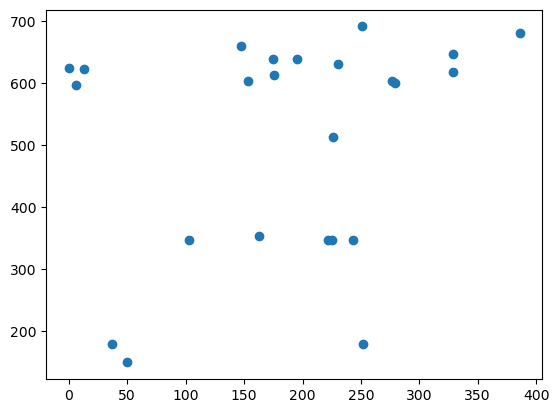

In [60]:
plt.figure()
plt.scatter(*pattern_template[0].T)
plt.show()

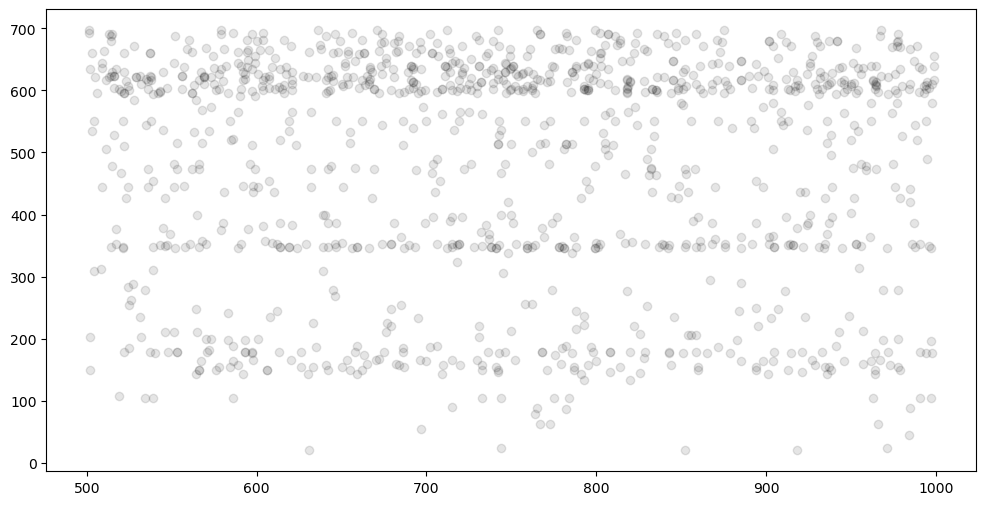

In [81]:
plt.figure(figsize=(12,6))
plt.scatter(spikes[(spikes>500) & (spikes< 1000)],labels[(spikes>500) & (spikes< 1000 )],alpha=0.1,c='black')
plt.scatter(pattern_template[0].T[0]+all_times[0][0], pattern_template[0].T[1],alpha=0.1,c='black')
plt.scatter(pattern_template[0].T[0]+all_times[0][1], pattern_template[0].T[1],alpha=0.1,c='black')
plt.show()

In [96]:
A_dense = np.zeros((1+int(np.max(spikes)),1+int(np.max(labels))))
pattern_img = np.zeros((1+np.max(pattern_template[0].T[0]),1+np.max(labels.astype('int'))))
for i in range(len(pattern_template[0])):
    pattern_img[pattern_template[0][i][0],pattern_template[0][i][1]] = 1
pattern_img.shape, np.sum(pattern_img)

((387, 698), 24.0)

In [125]:
np.sum(pattern_img), np.sum(A_dense)

(24.0, 0.0)

In [135]:
D_ = pattern_img.shape[0]
sanity_check = np.zeros((np.max(spikes)))
j=0
for i in range(np.max(spikes)-D_):
    sanity_check[i] = np.sum(pattern_img*A_dense.T[:,i:i+D_].T)
sanity_check = sanity_check/np.sum(pattern_img)

In [134]:
np.sum(pattern_img)

24.0

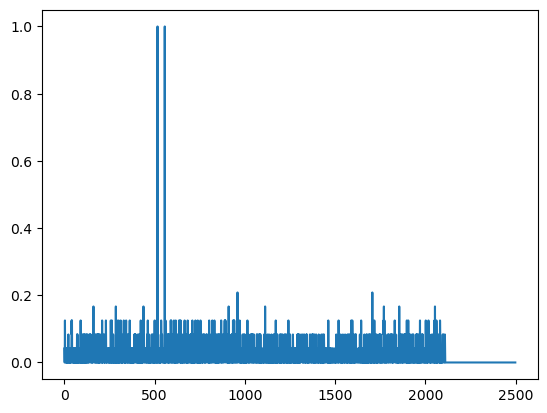

In [136]:
plt.figure()
plt.plot(sanity_check)
plt.show()

In [99]:
sanity_check.shape, pattern_img.shape

((2500, 698), (387, 698))

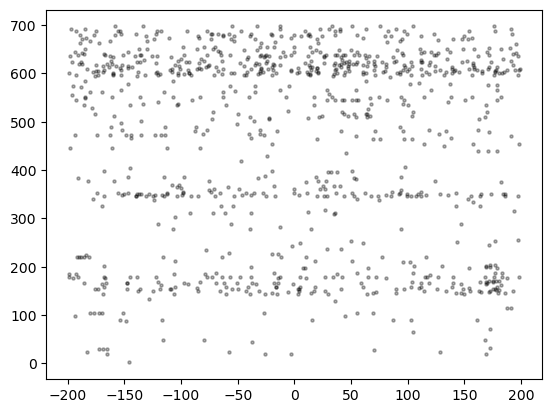

In [67]:
debug=[]
debug.append([])
for time_ in [all_times[-1][0]]:
    condition = (T_labels > time_-window_dim*2) & (T_labels < time_ + window_dim*2)
    pattern = [tuple(k) for k in np.array([T_labels[condition]-time_, N_labels[condition]]).T]
    debug[-1] += pattern
    
plt.figure()
plt.scatter(*np.array(pattern).T,s=5,alpha=0.3,c='black')
plt.show()

In [73]:
all_times[-2]

array([1228, 2169])

In [126]:
A_dense = np.zeros((1+int(np.max(spikes)),1+int(np.max(labels))))
A_dense.shape

(2500, 698)

In [127]:
for i in range(len(spikes)):
    A_dense[spikes[i],labels.astype('int')[i]]=1
np.sum(A_dense)

6295.0

In [105]:
(A_dense[t:t+np.max(pattern_template[j].T[0])]).shape

(331, 698)

In [107]:
all_times[-3]

array([462, 485])

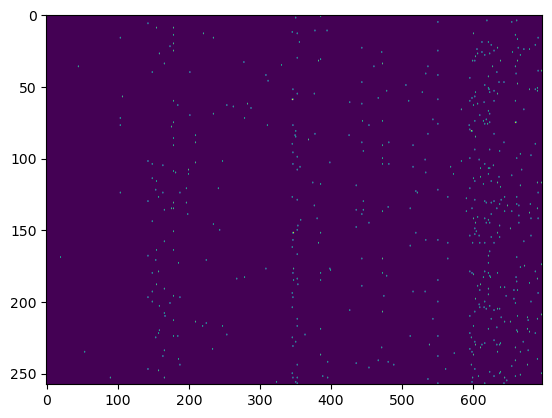

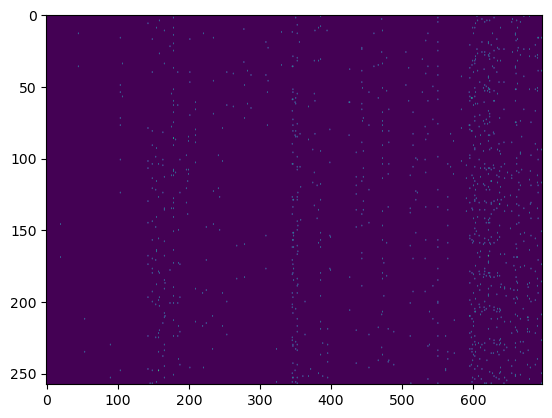

In [109]:
j=-3
test = np.zeros_like(A_dense[0:0+np.max(pattern_template[j].T[0])])
for t in all_times[j]:
    plt.figure()
    test += A_dense[t:t+np.max(pattern_template[j].T[0])]
    plt.imshow(test,aspect='auto')

In [98]:
np.max(pattern_template[-2].T[0])

362

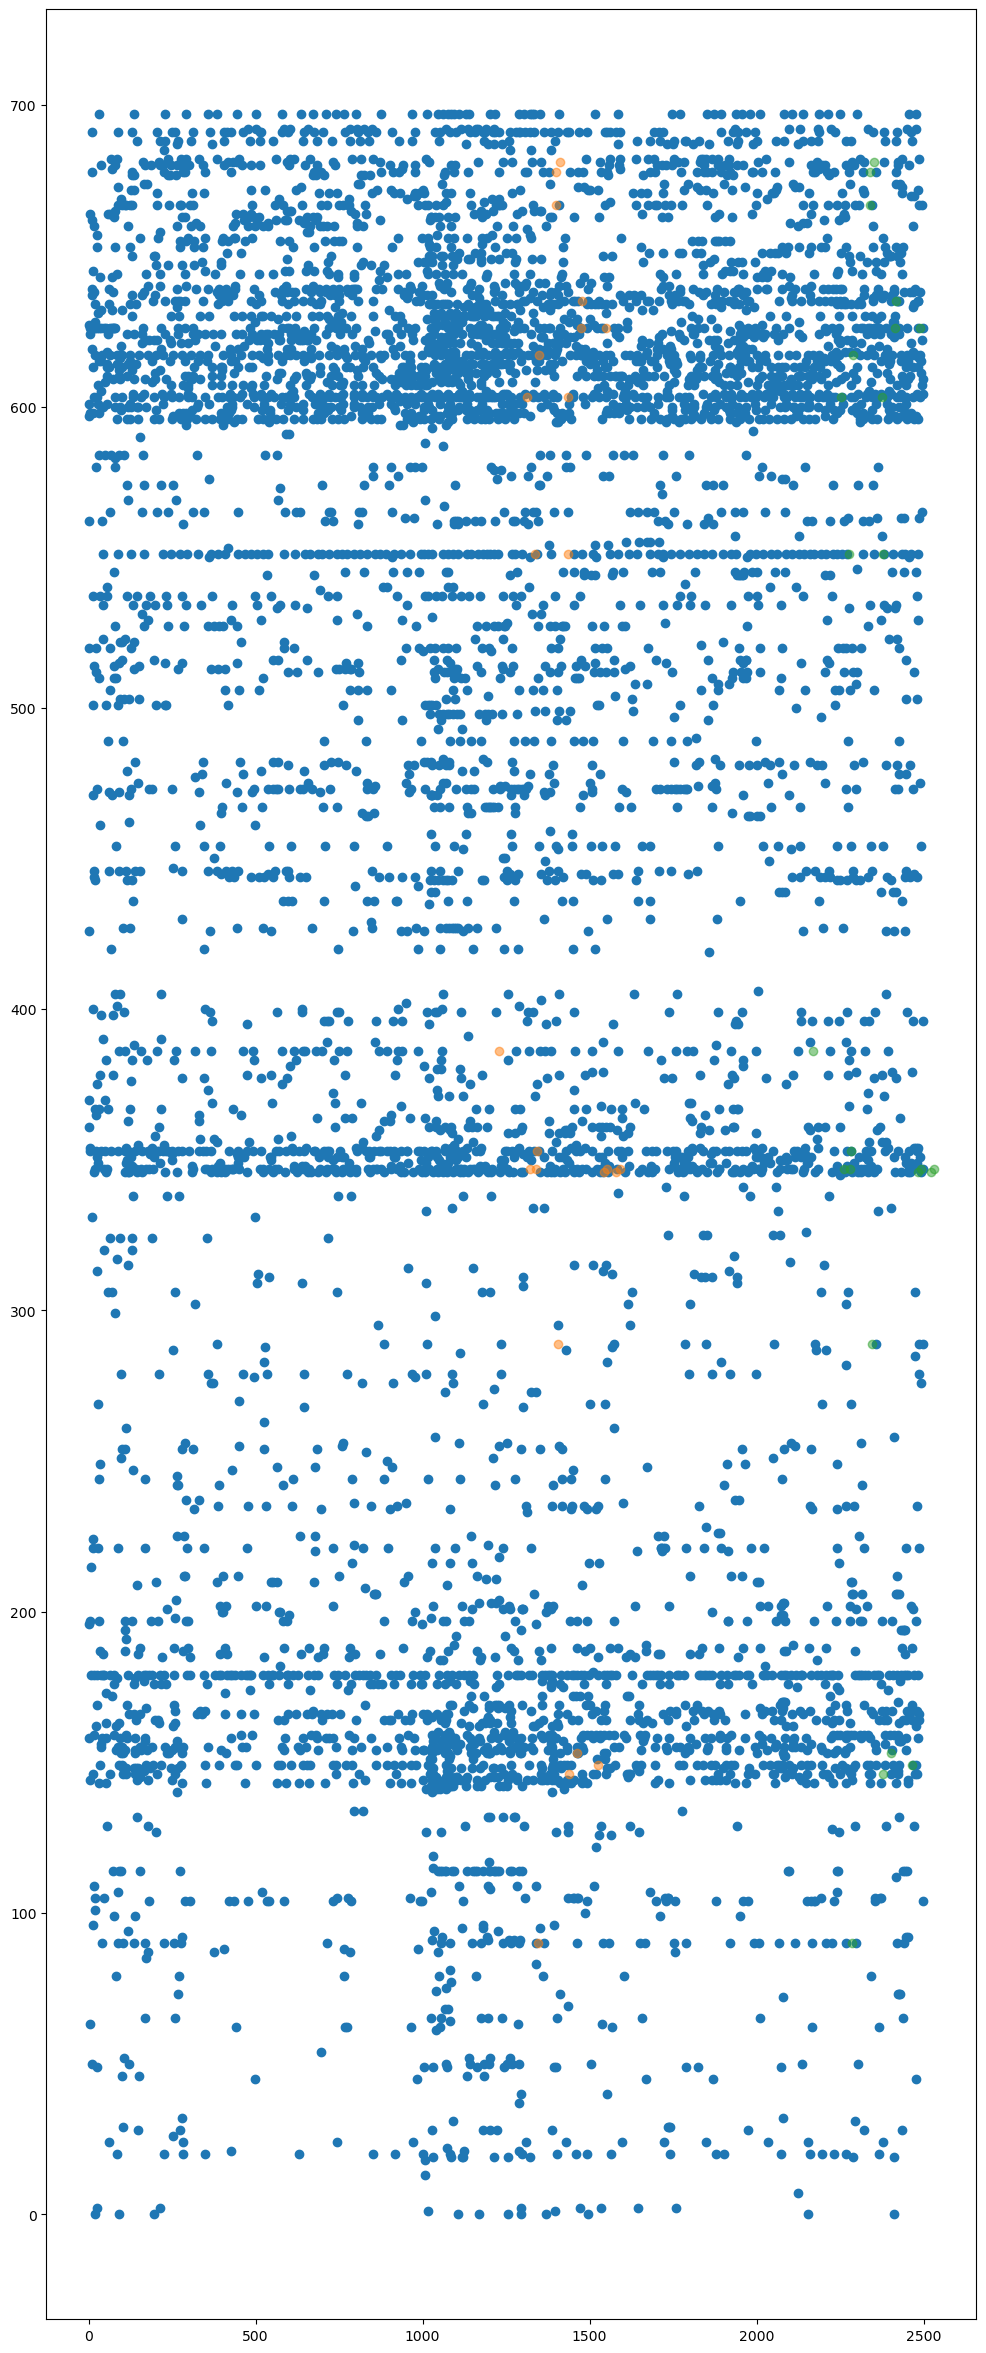

In [80]:
plt.figure(figsize=(12,30))
plt.scatter(spikes,labels)
for t in all_times[-2]:
    plt.scatter(pattern_template[-2].T[0] + t, pattern_template[-2].T[1],alpha=0.5)
plt.show()

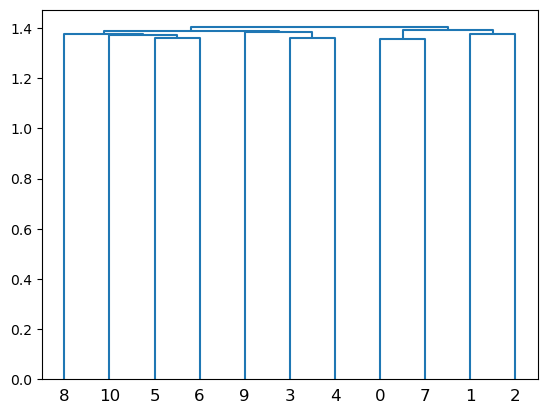

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage
HDP = linkage(sim_mats[0], method='complete')
dn = dendrogram(HDP)

C:\Users\miles\AppData\Local\Temp\ipykernel_11492\821431271.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


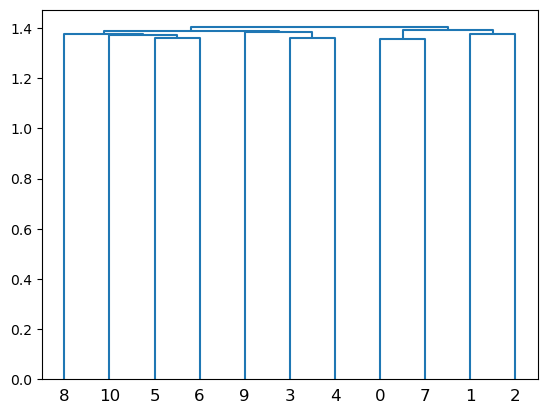

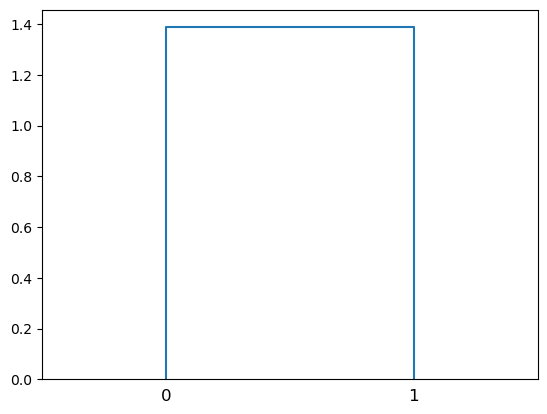

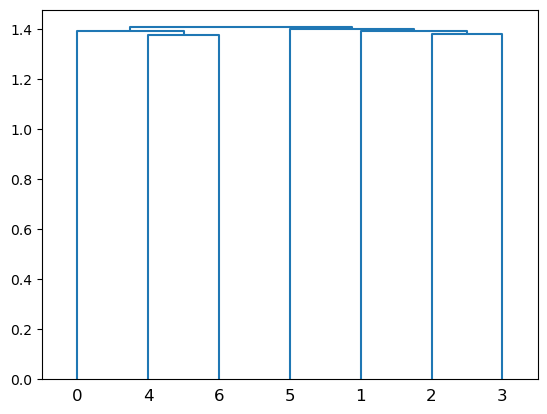

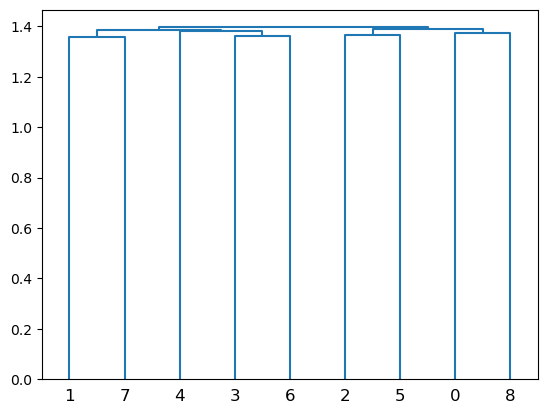

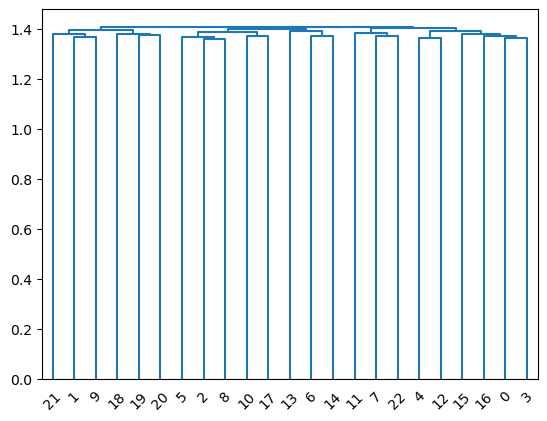

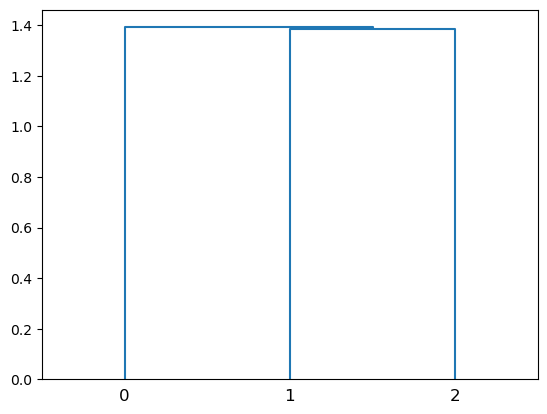

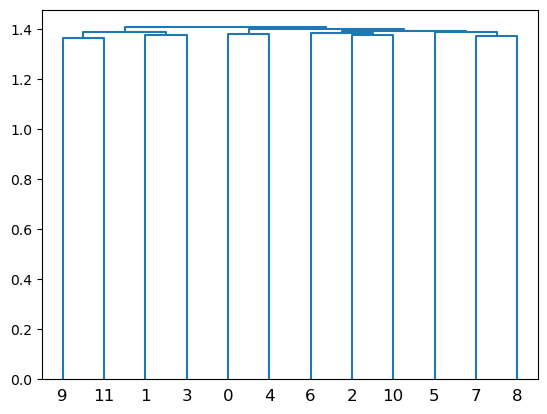

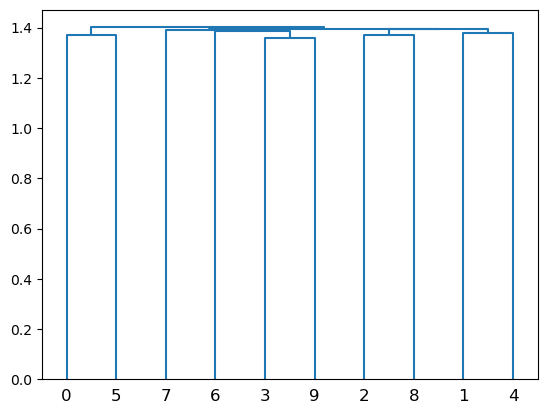

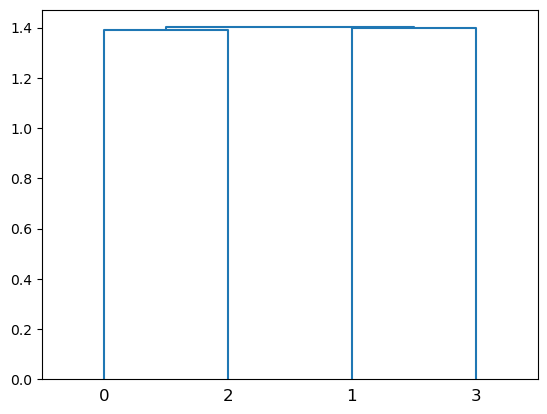

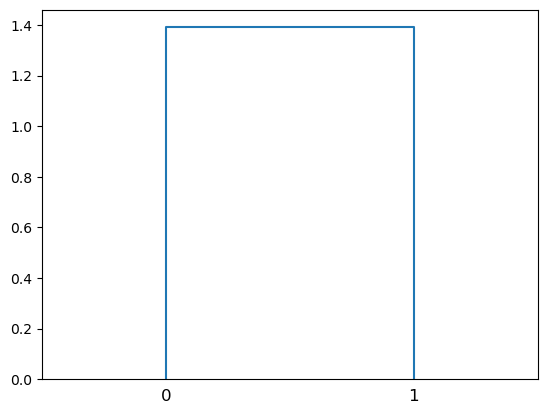

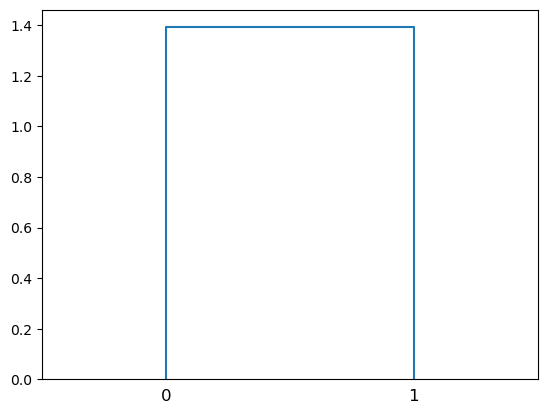

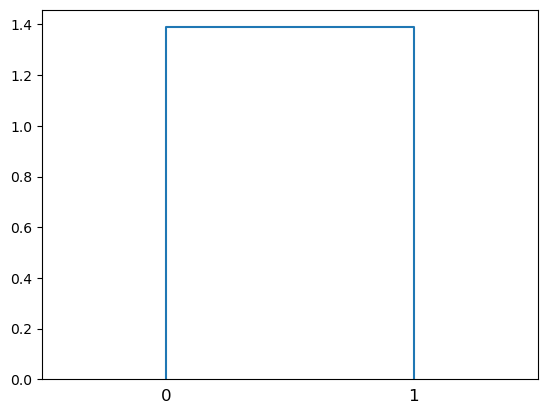

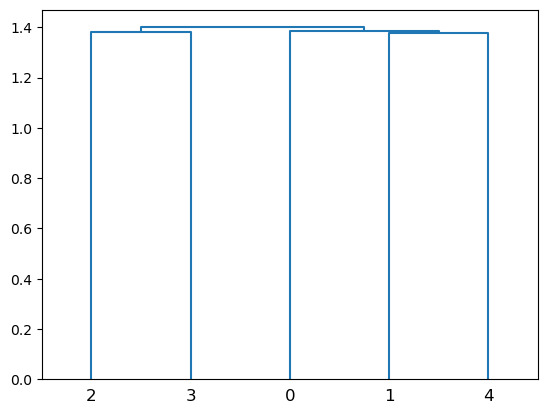

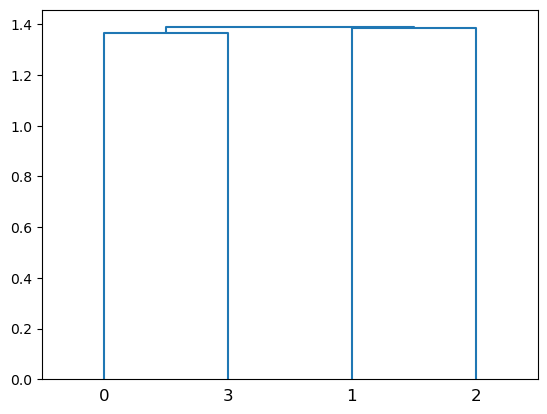

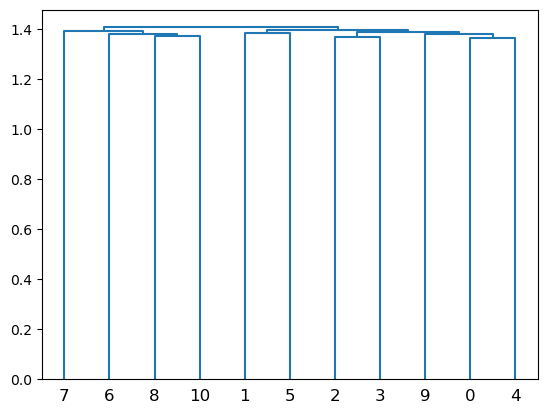

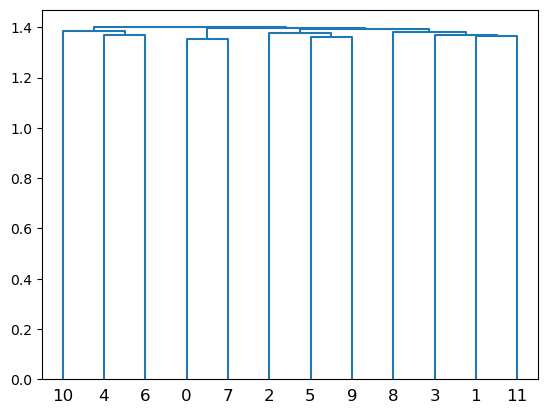

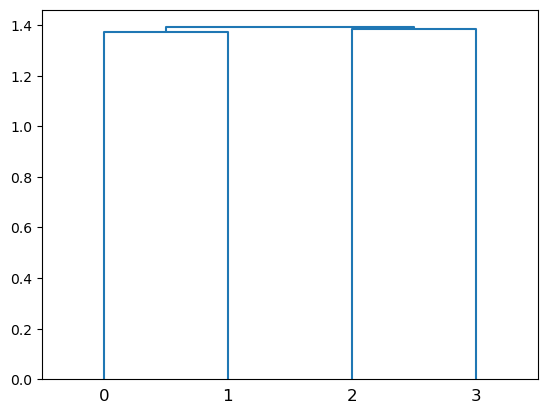

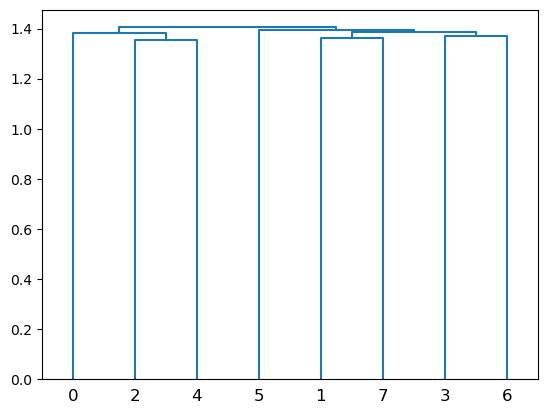

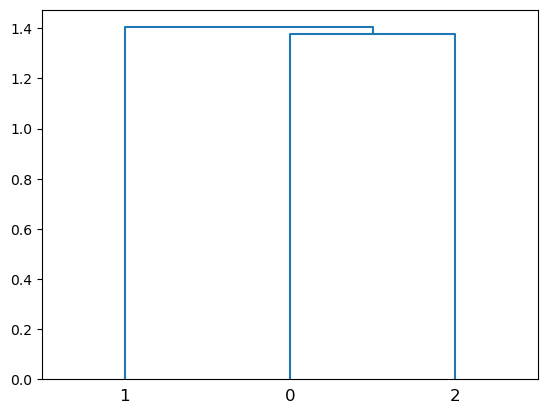

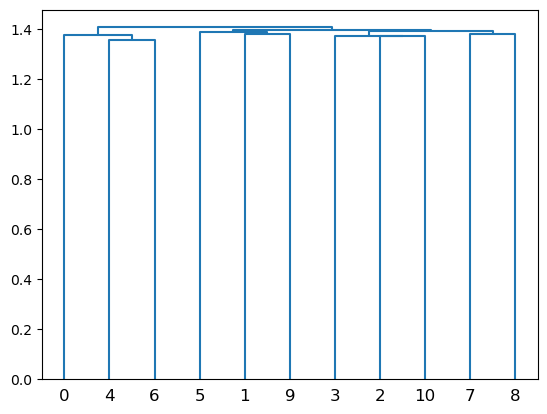

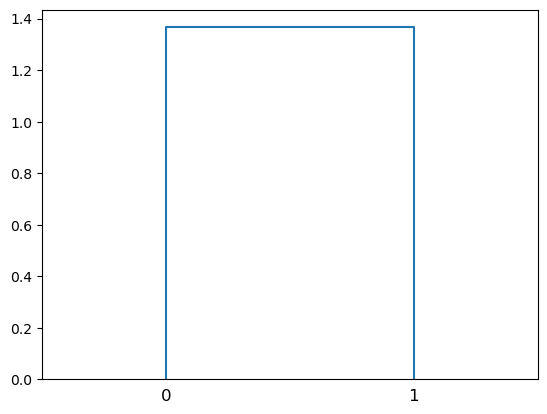

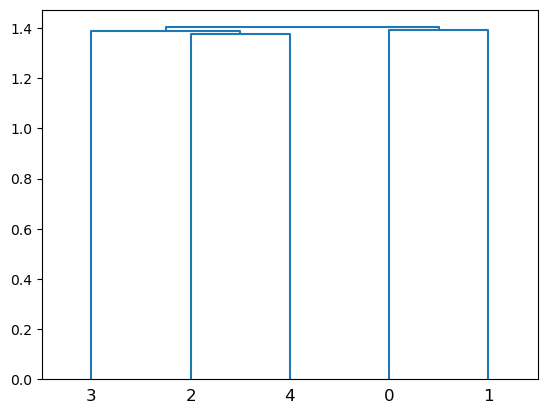

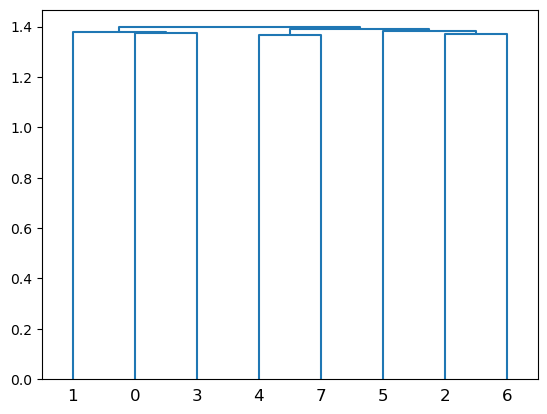

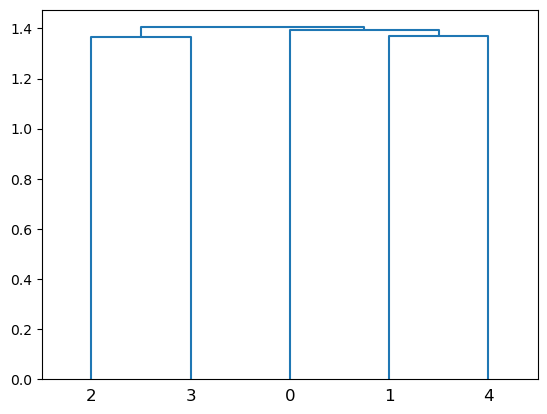

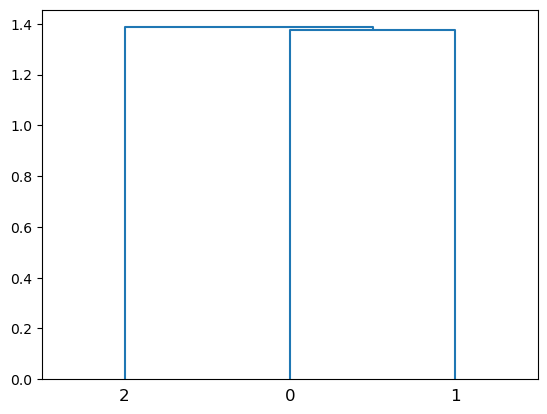

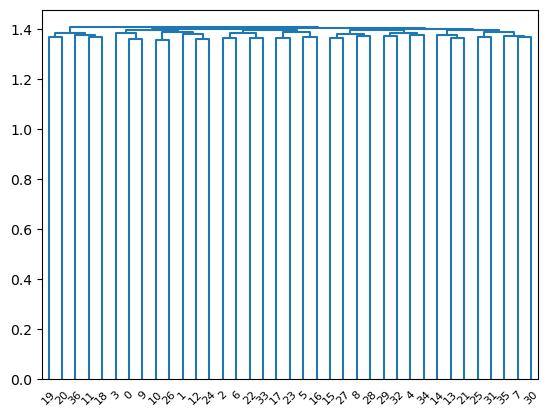

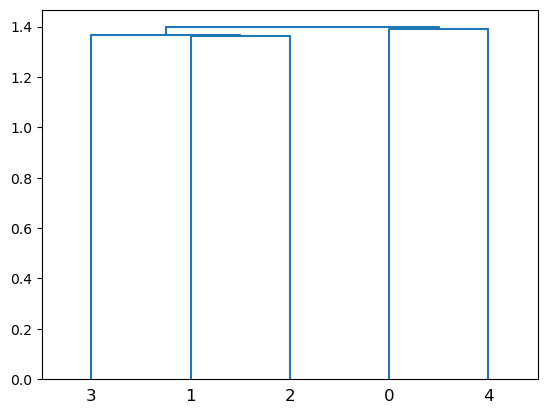

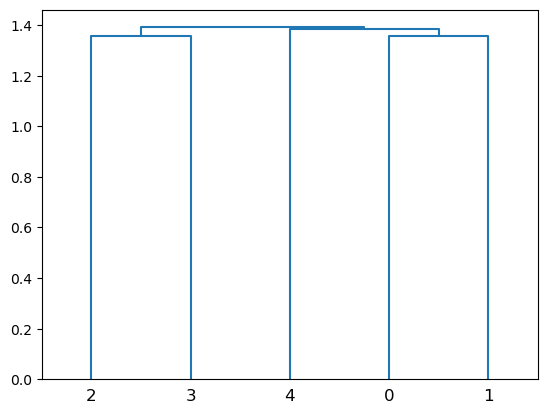

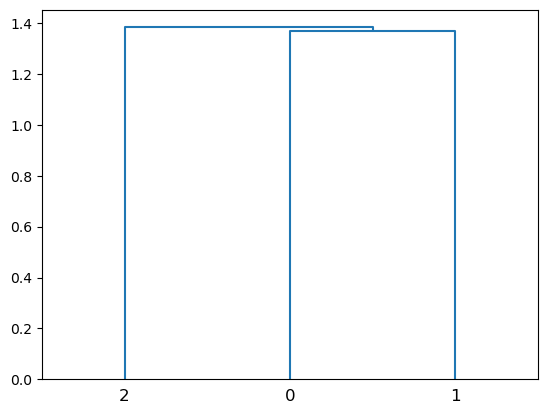

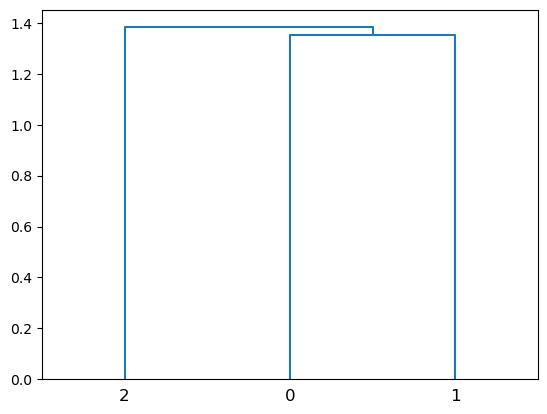

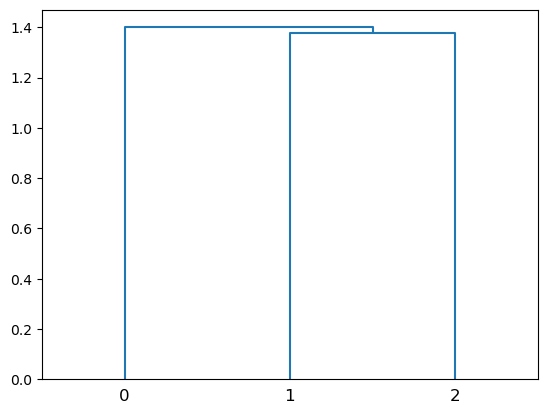

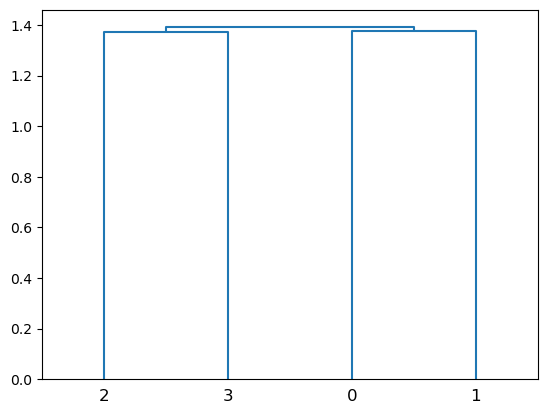

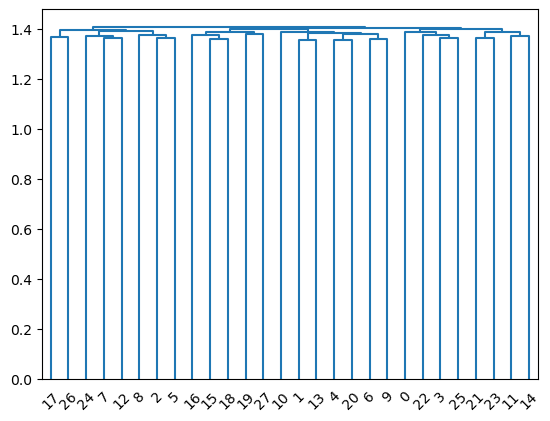

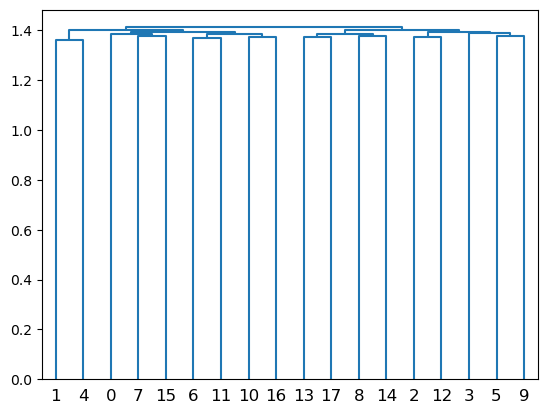

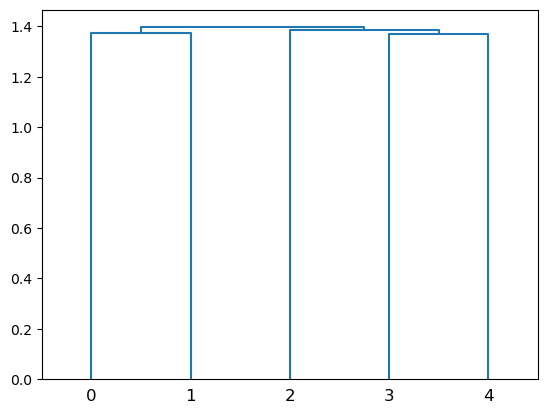

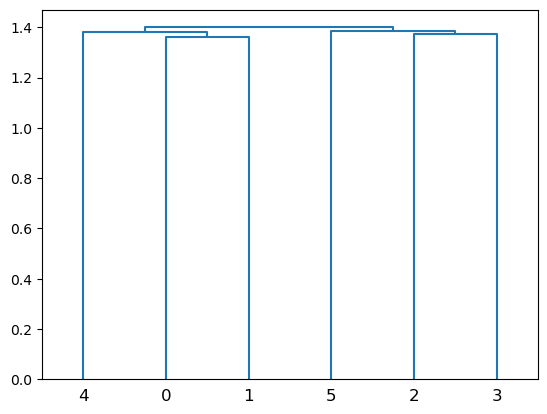

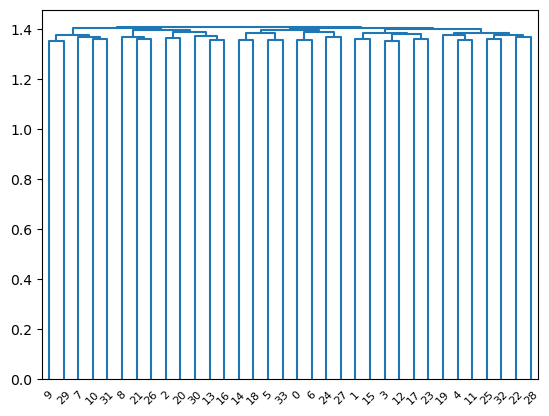

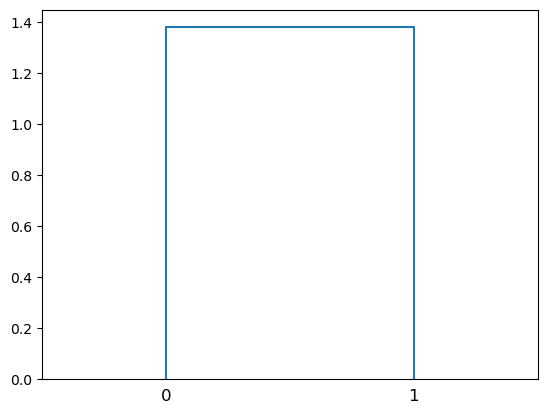

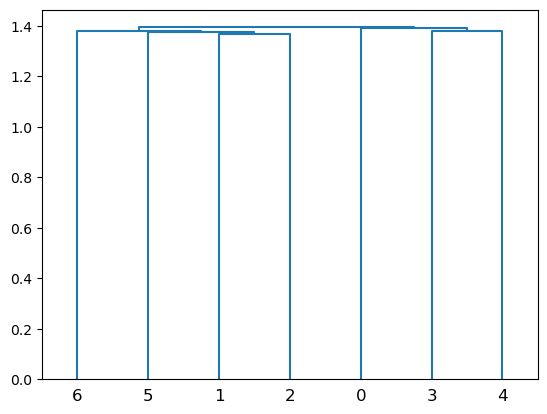

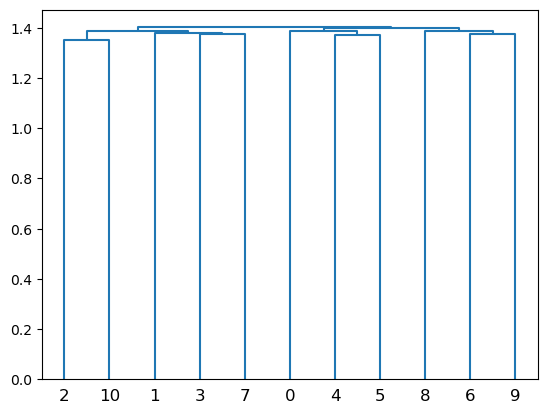

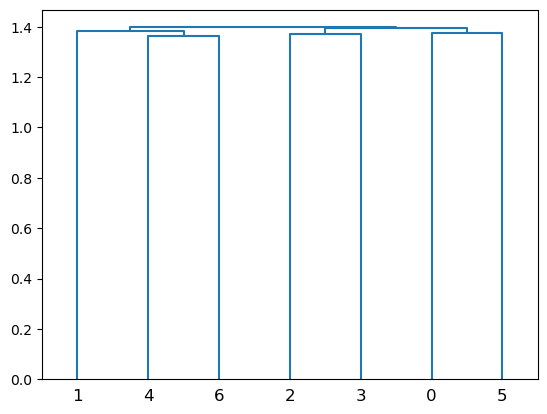

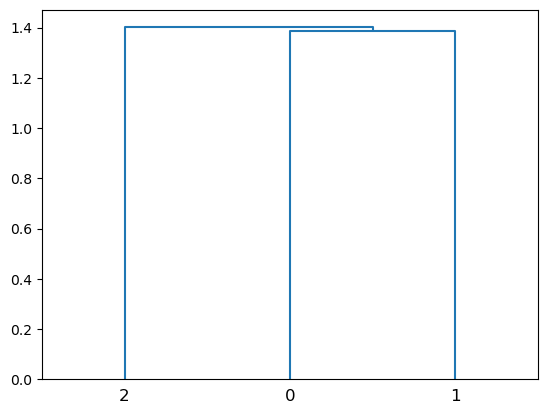

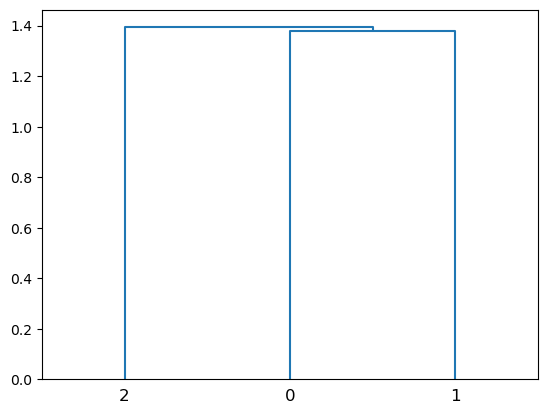

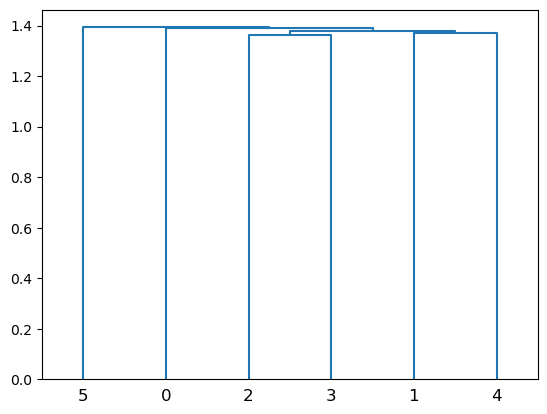

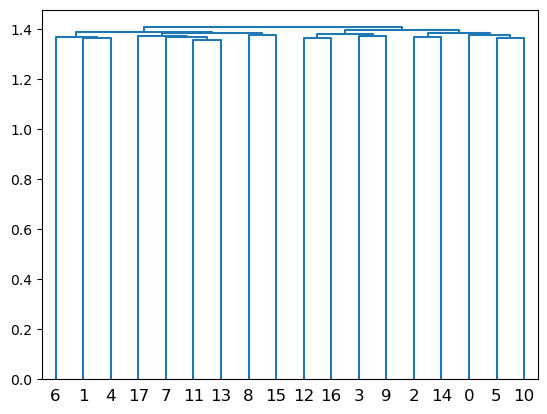

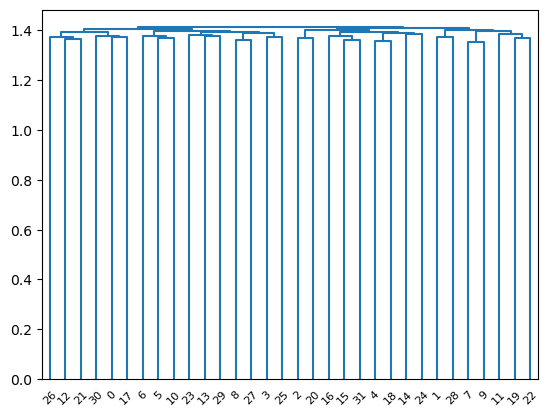

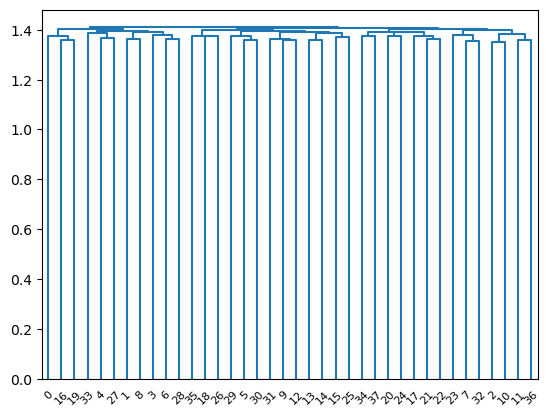

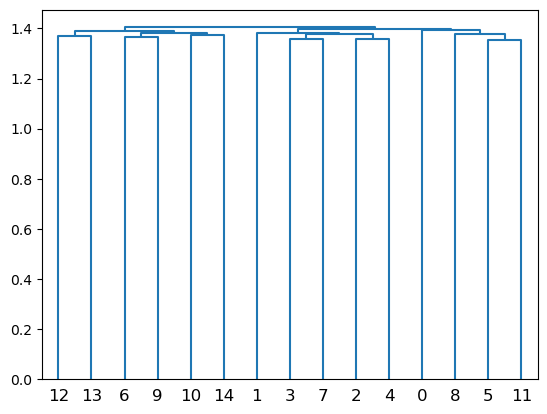

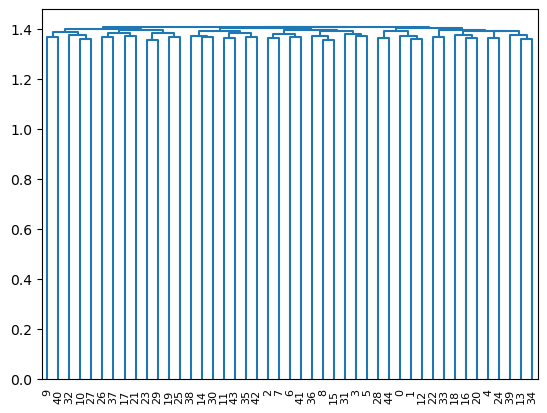

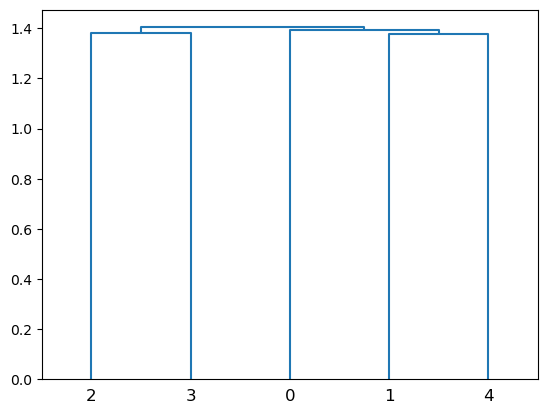

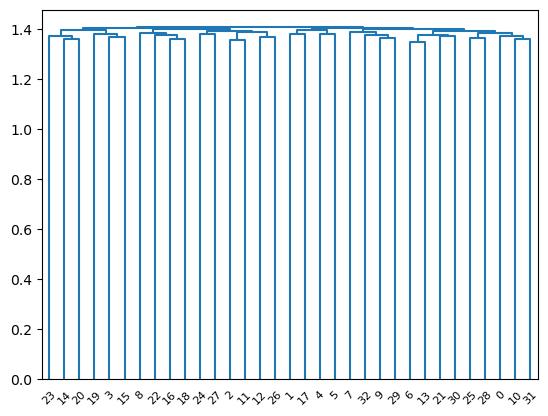

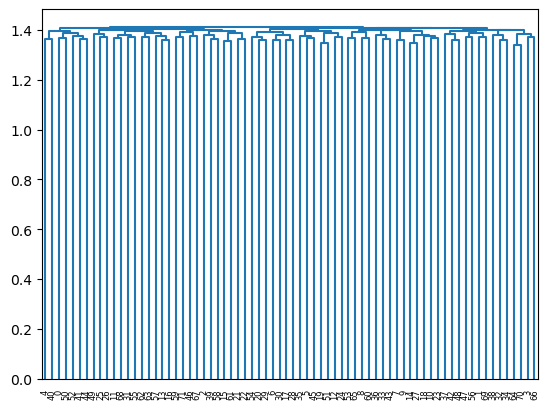

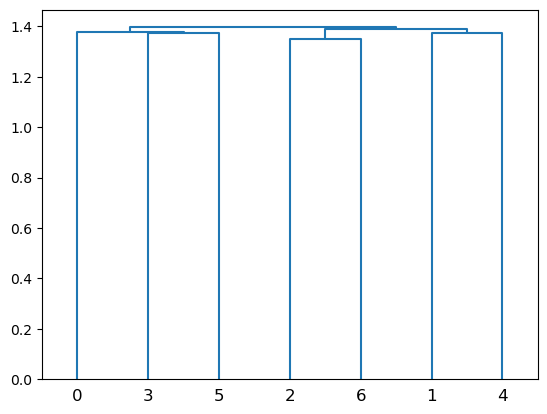

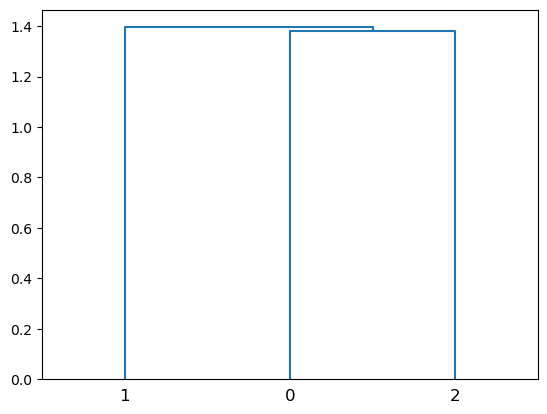

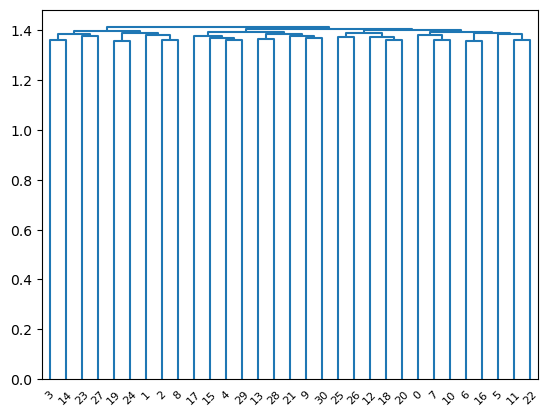

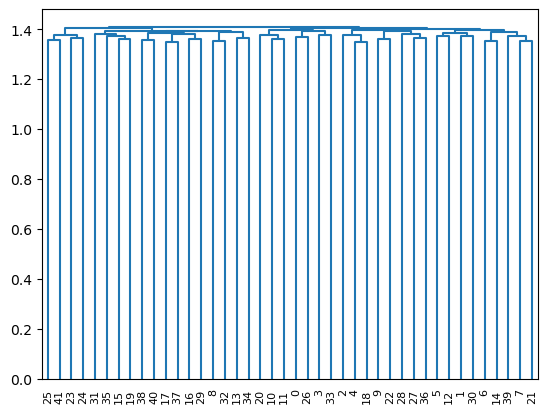

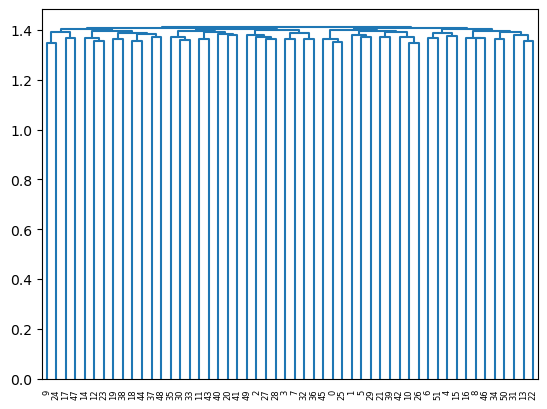

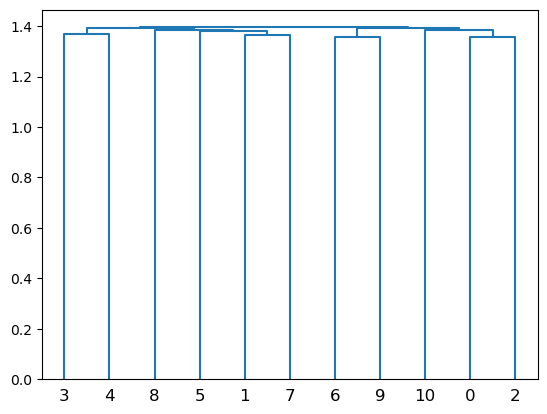

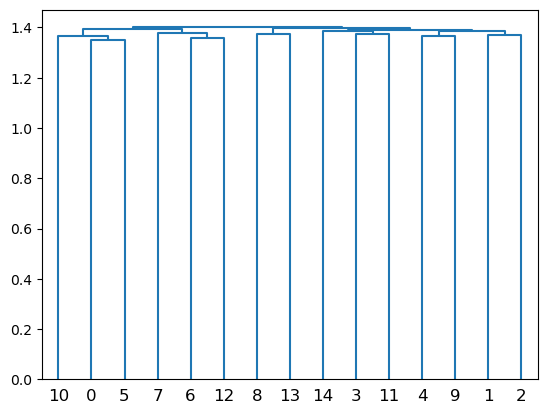

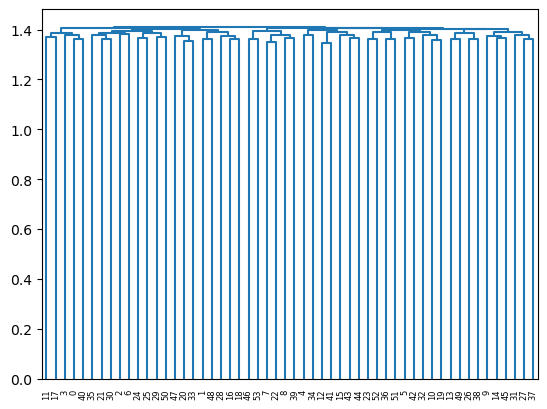

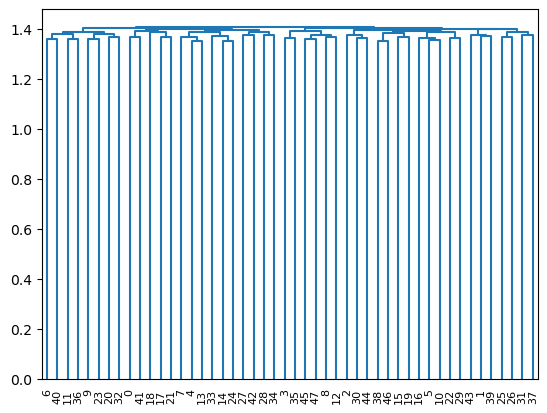

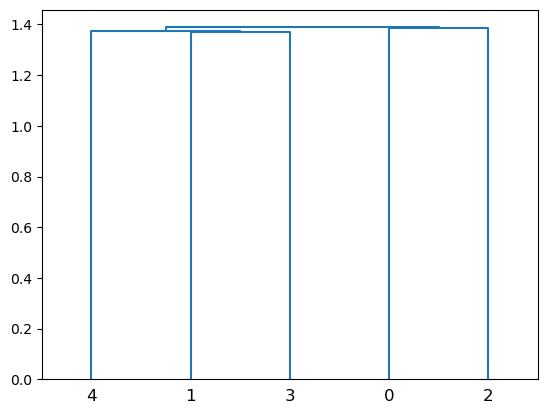

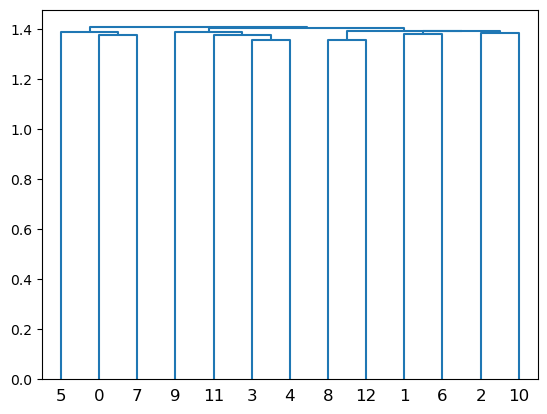

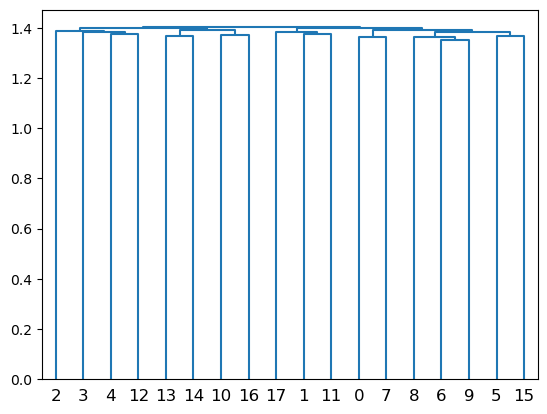

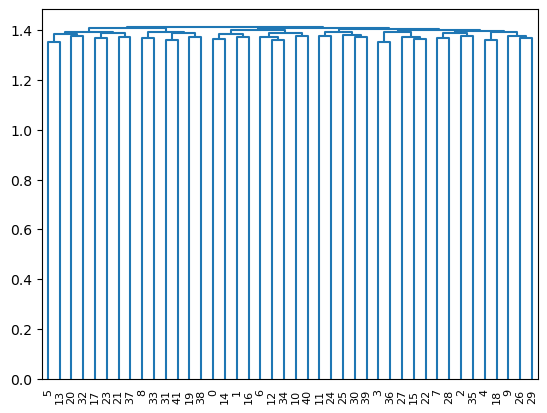

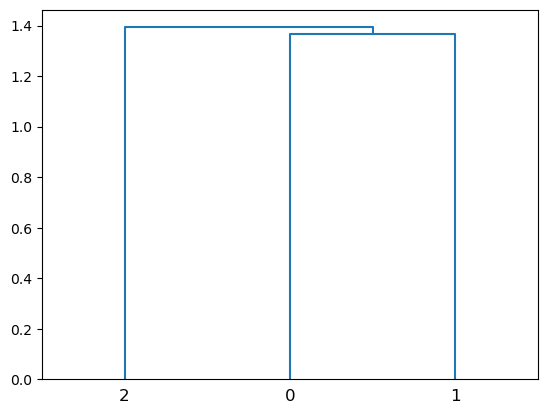

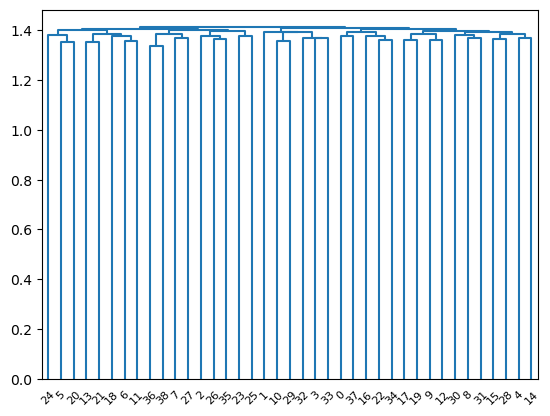

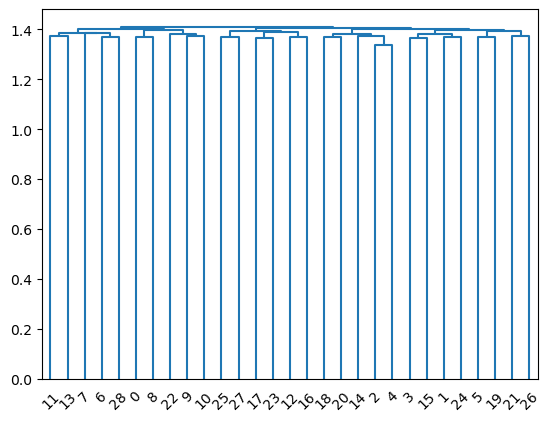

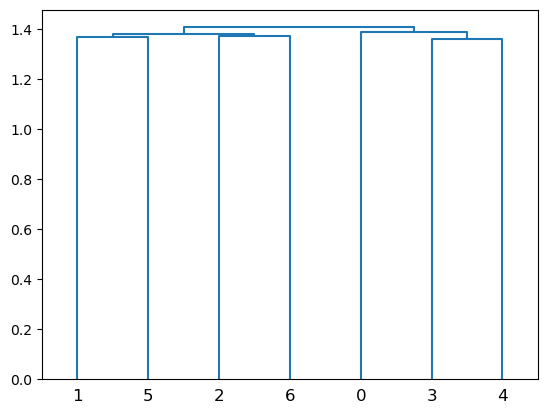

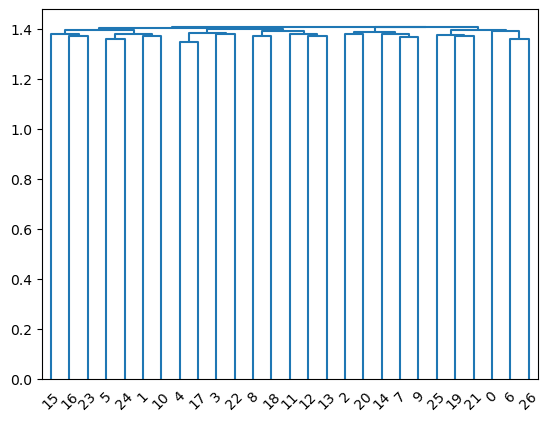

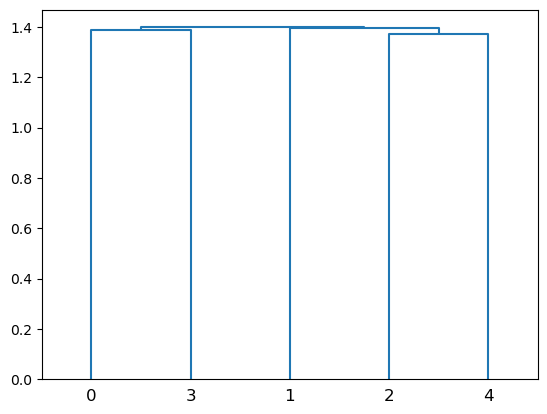

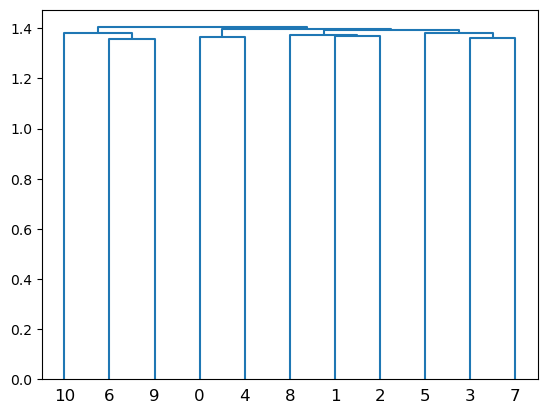

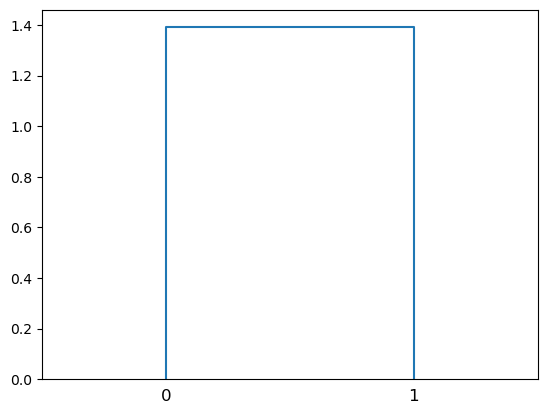

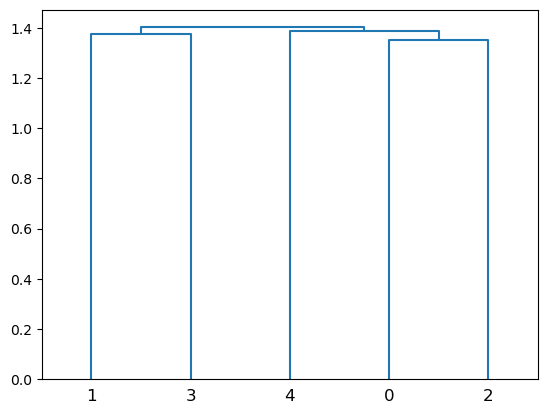

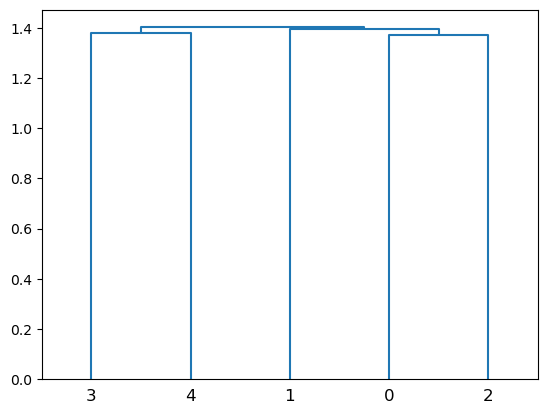

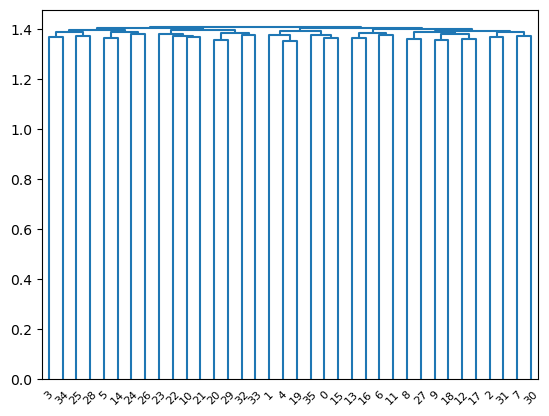

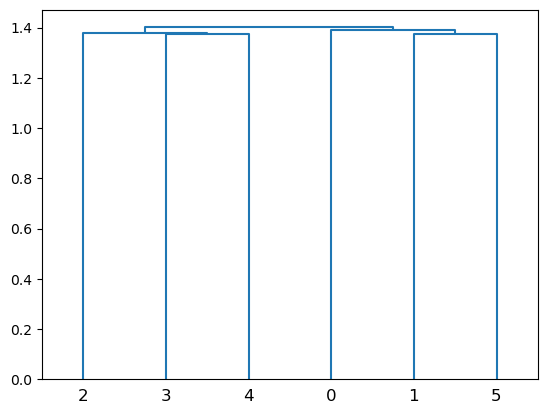

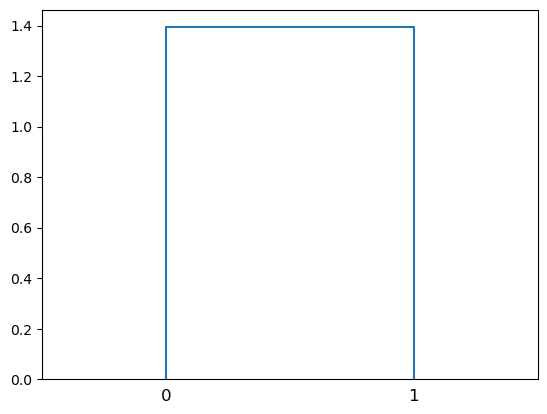

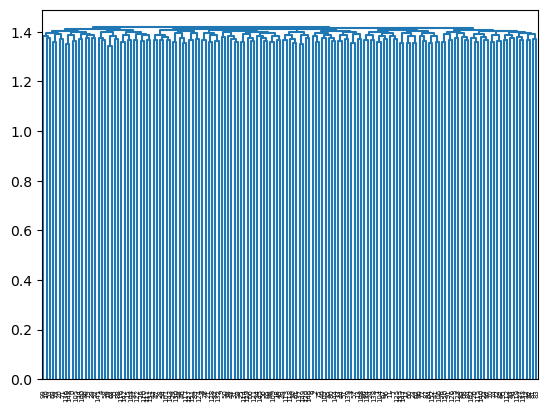

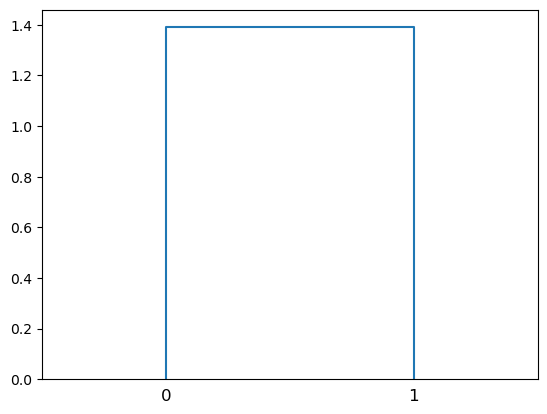

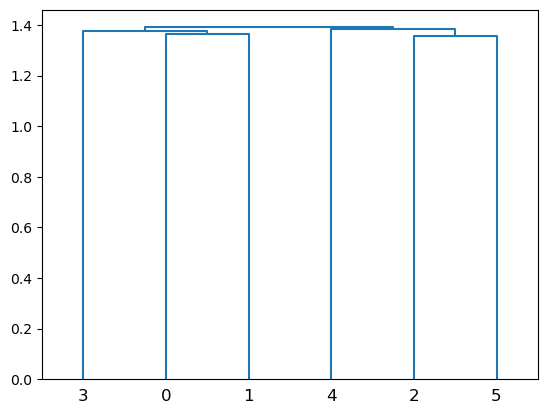

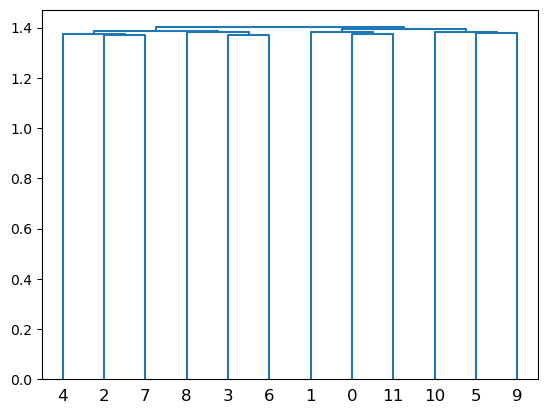

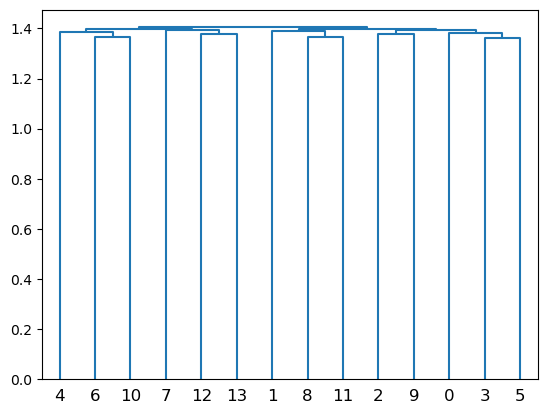

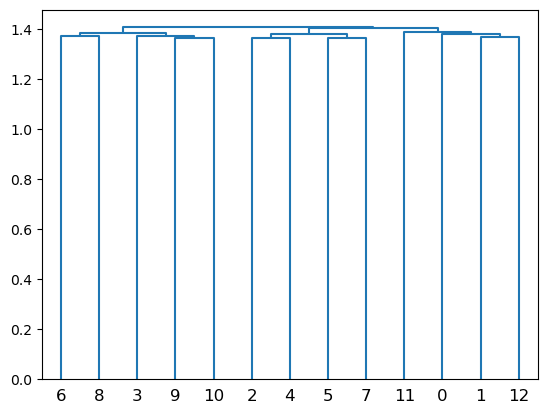

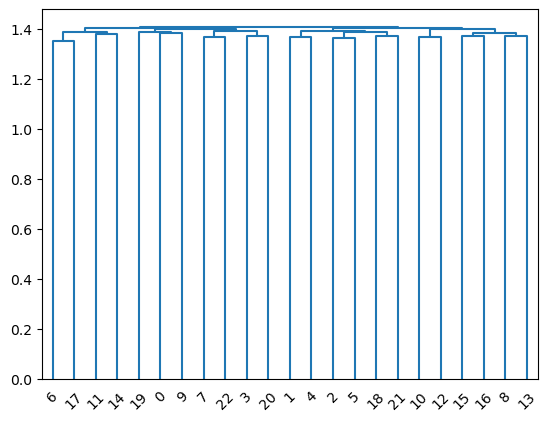

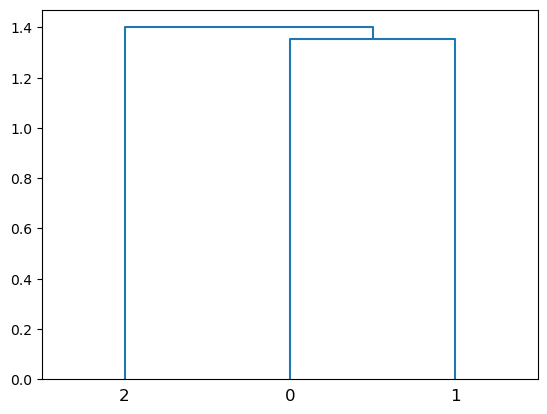

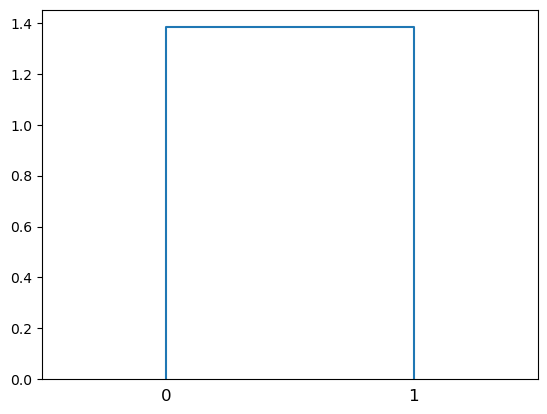

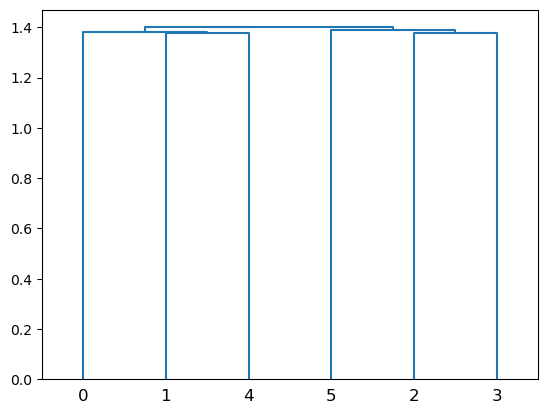

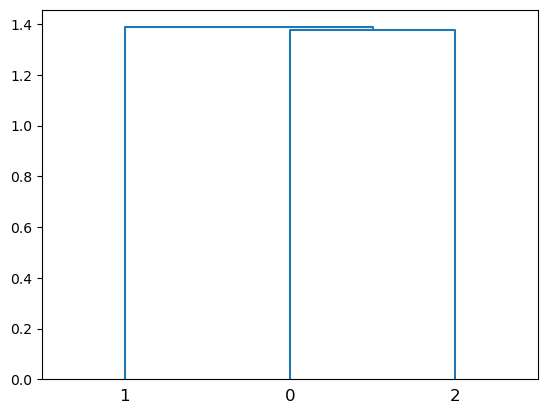

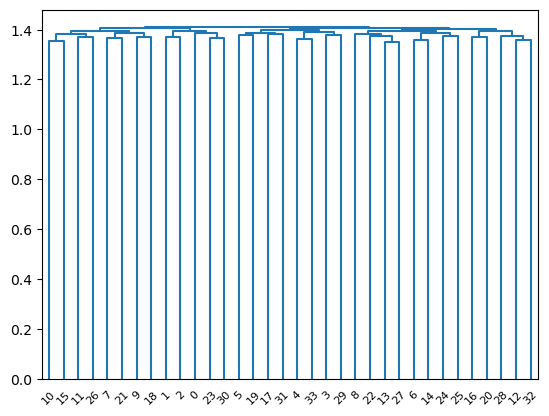

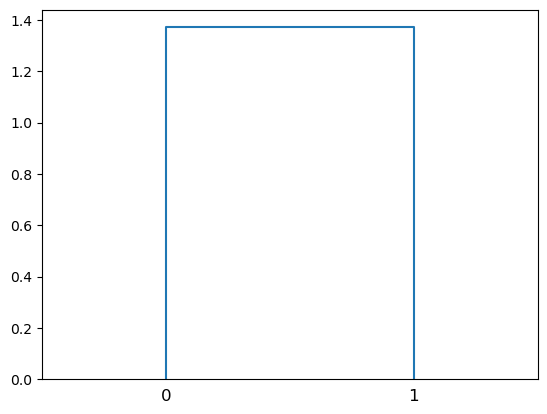

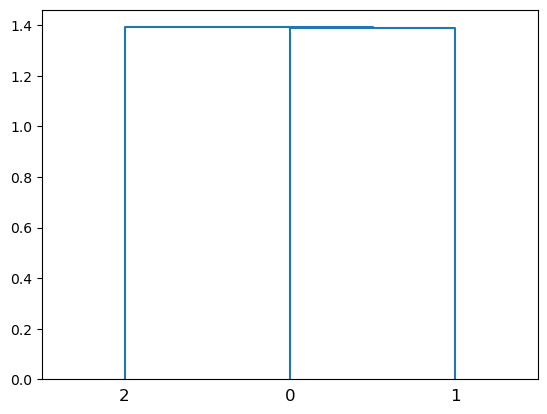

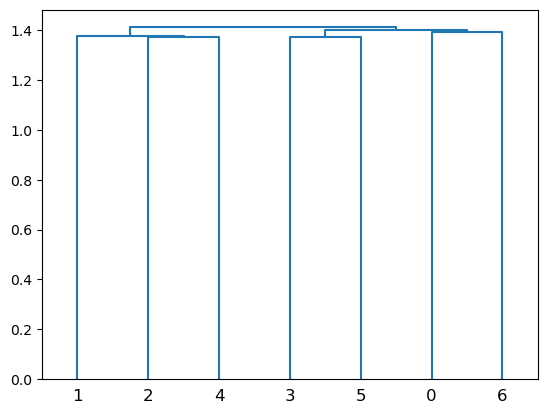

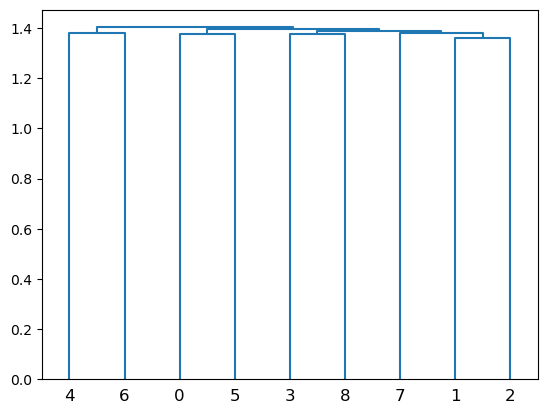

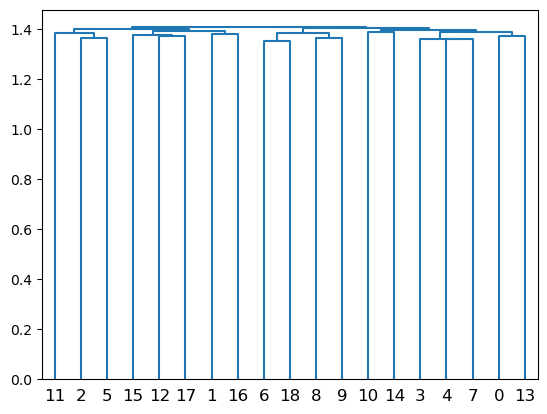

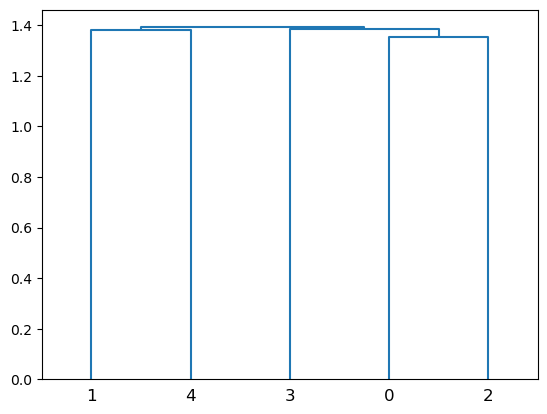

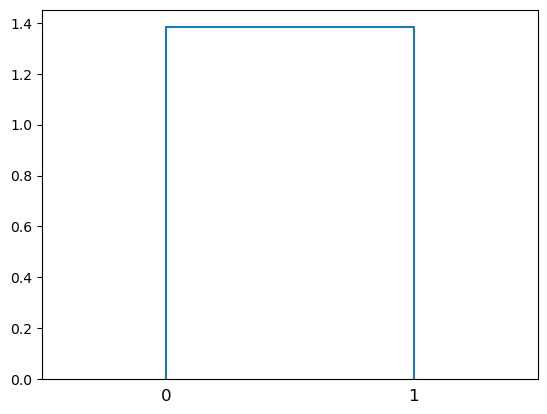

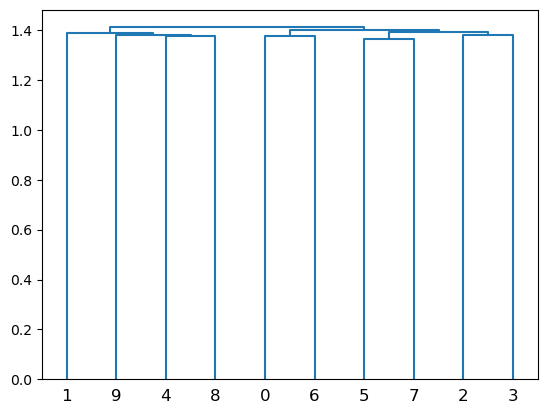

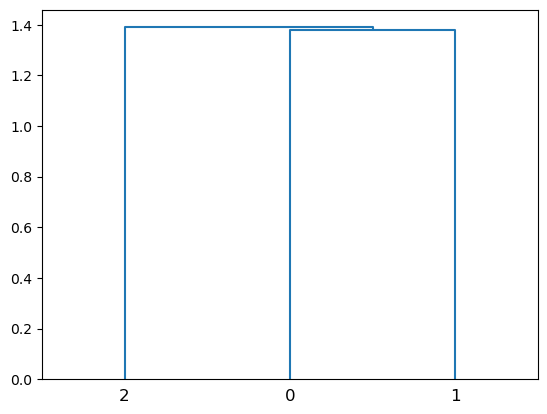

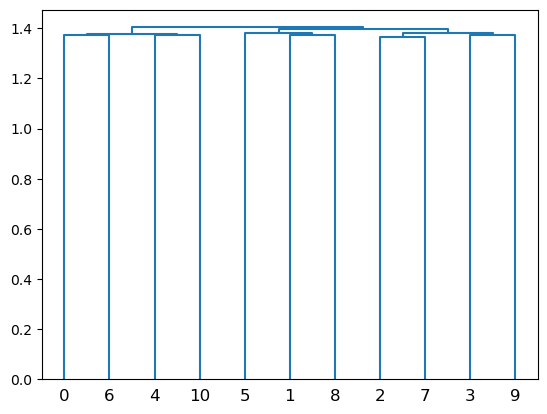

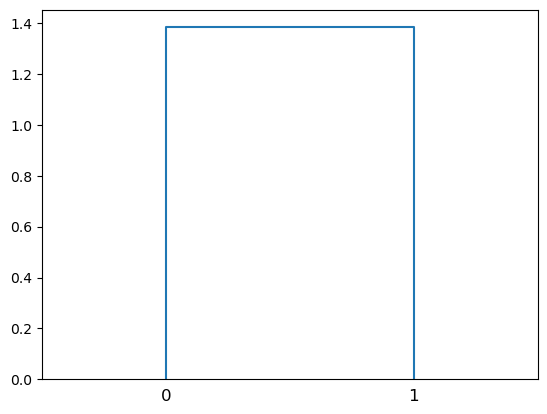

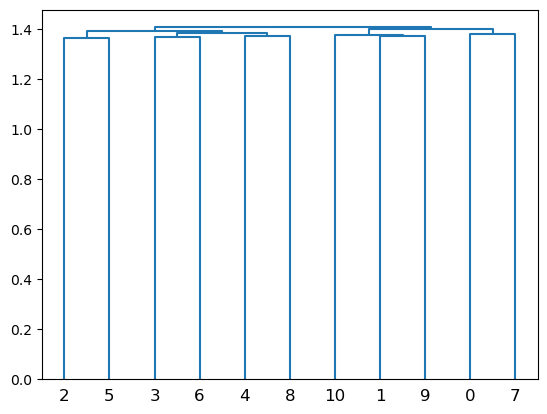

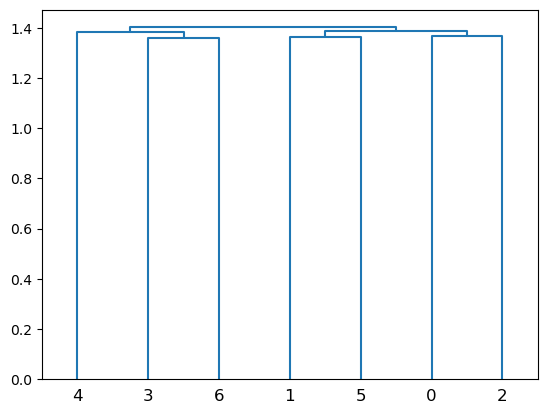

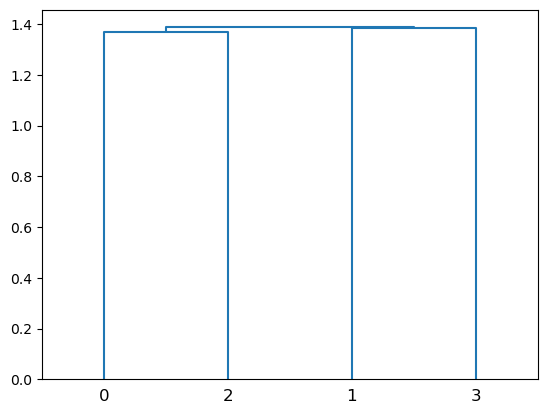

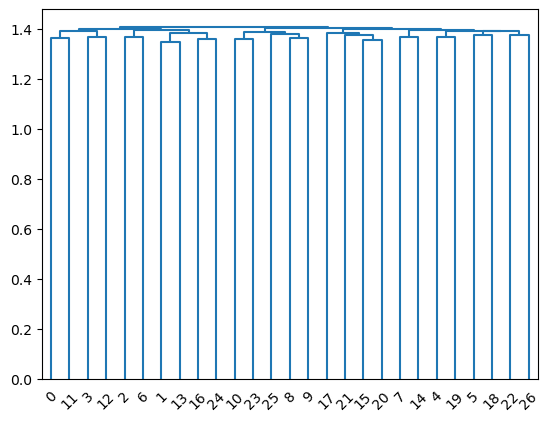

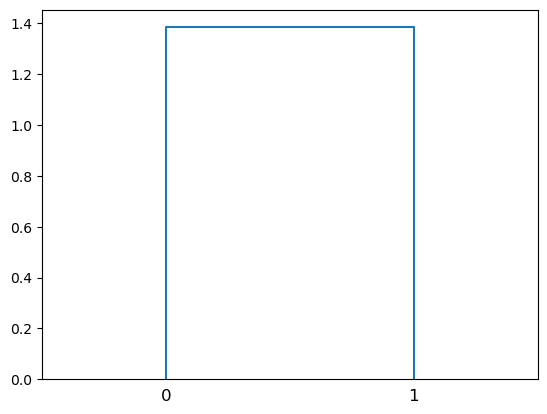

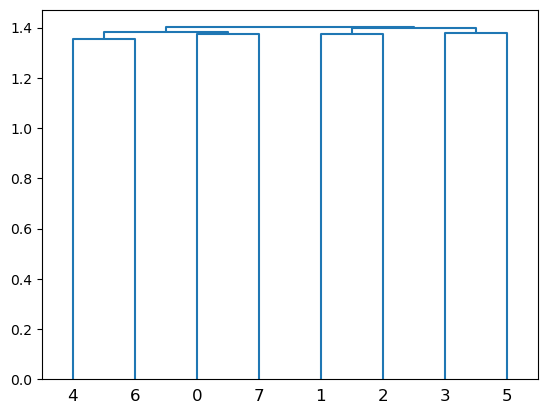

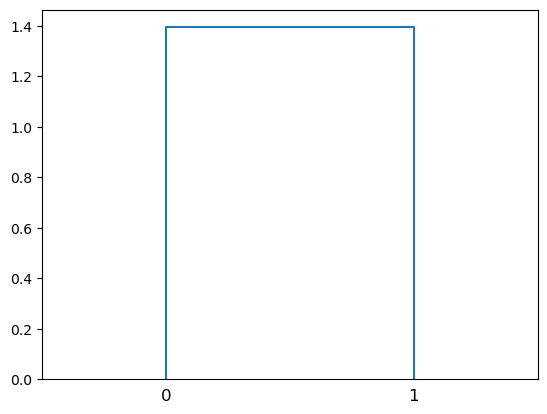

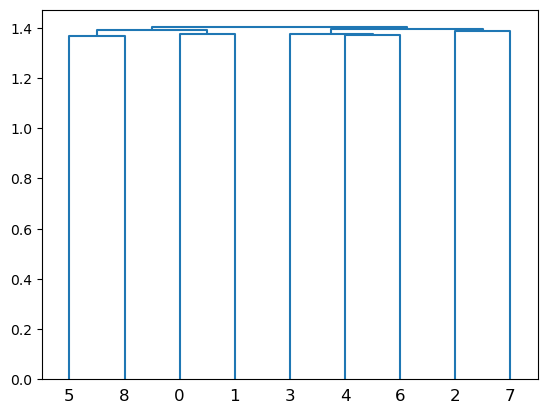

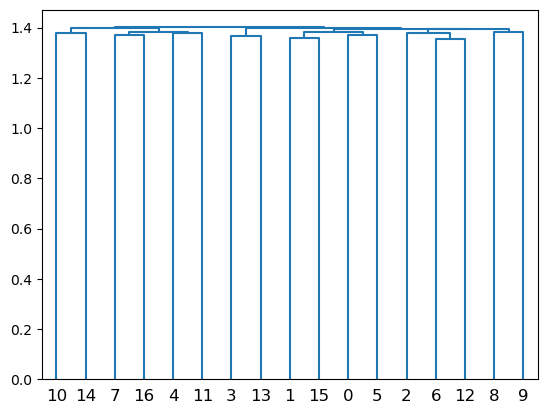

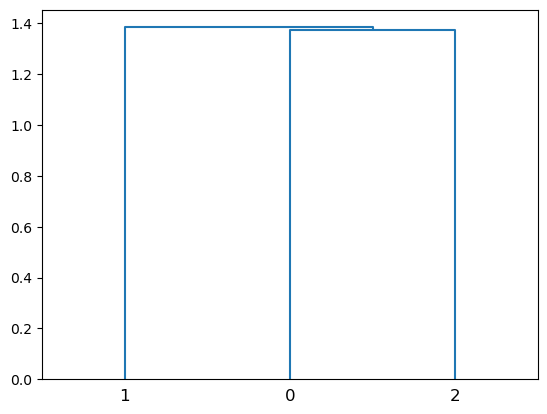

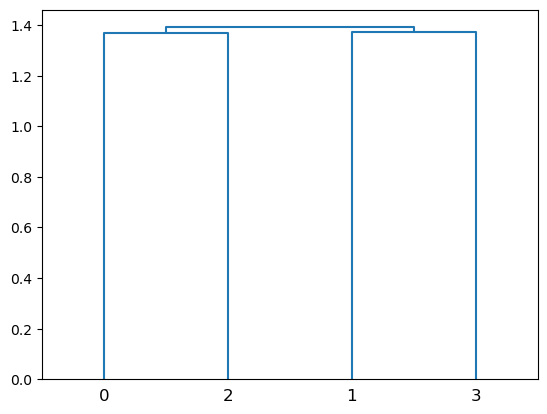

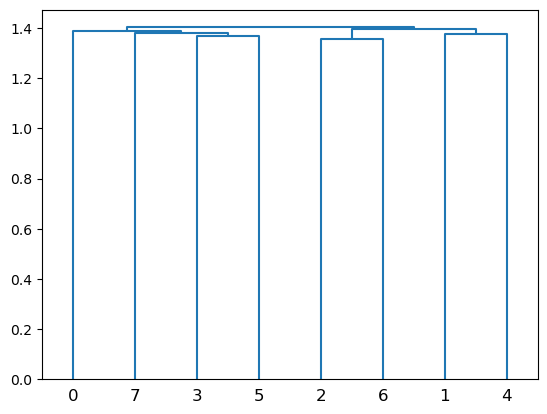

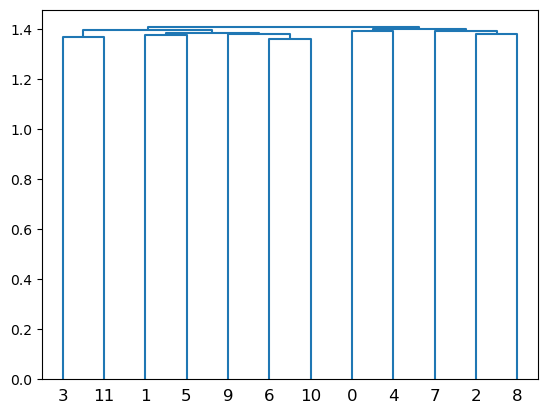

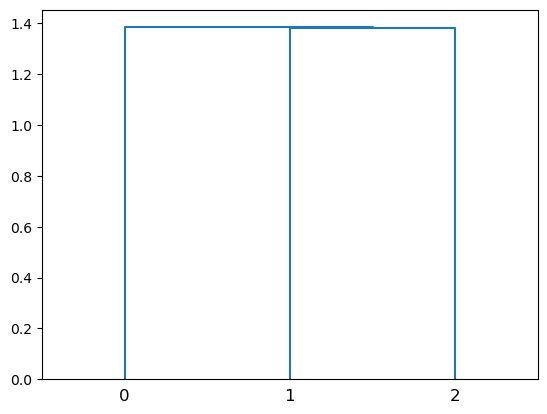

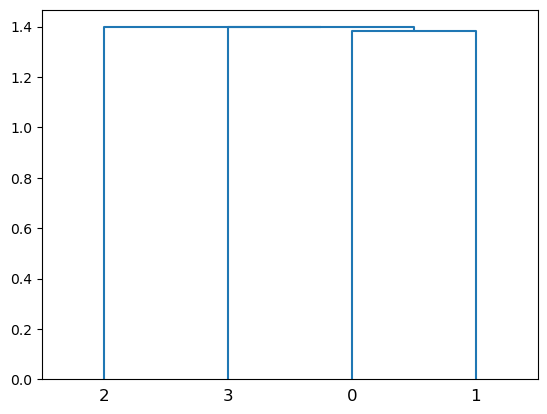

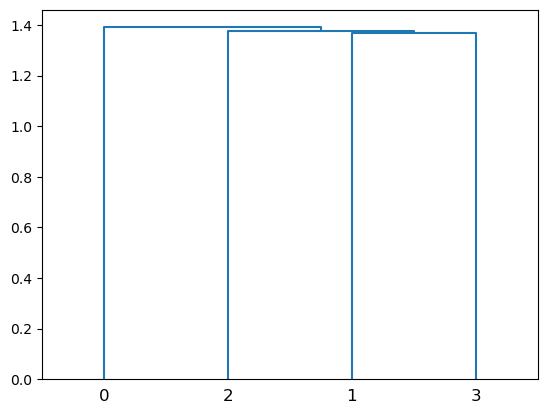

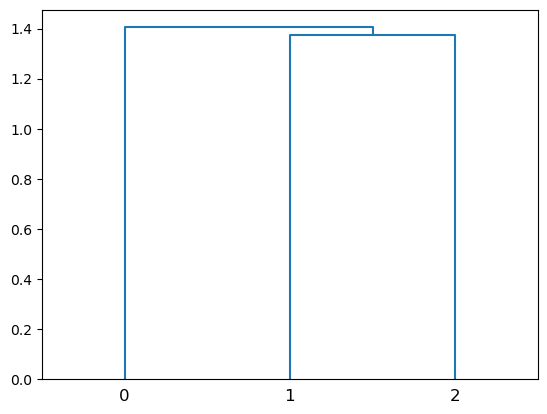

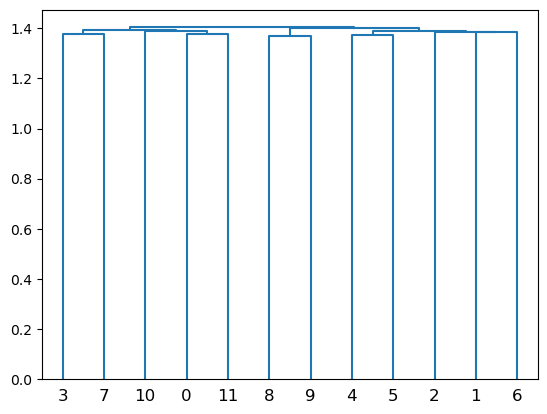

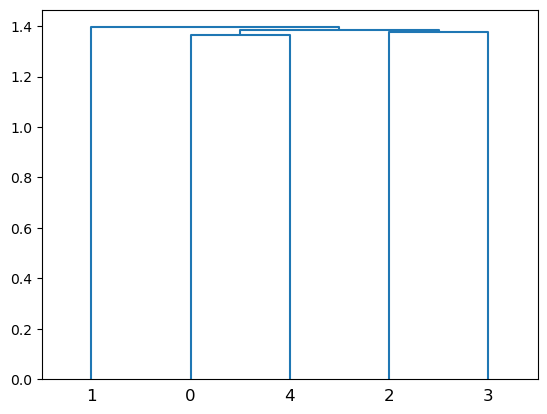

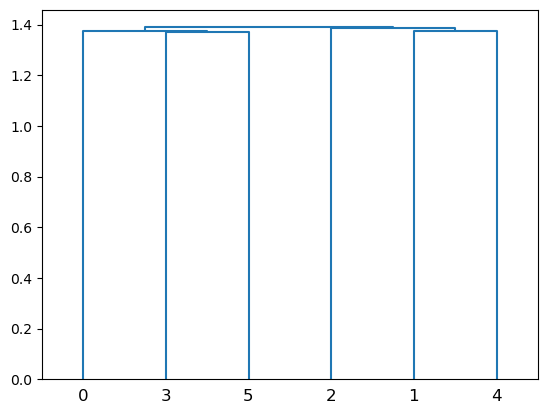

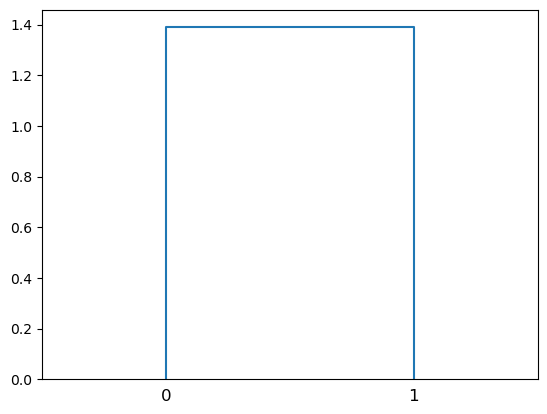

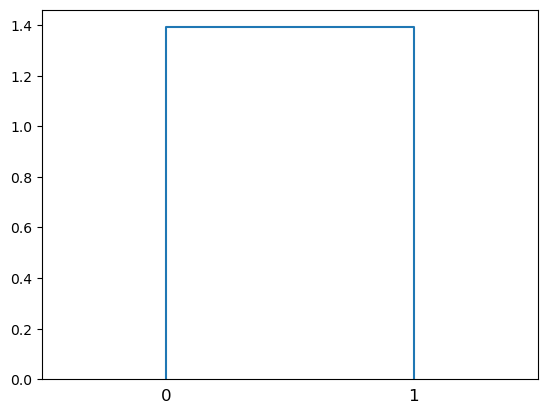

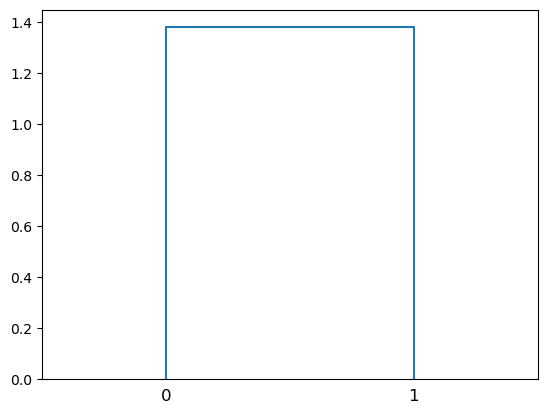

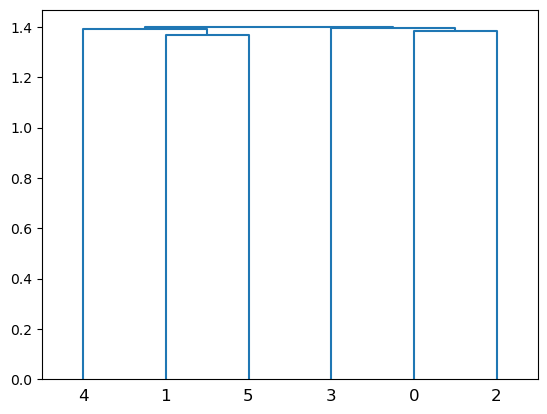

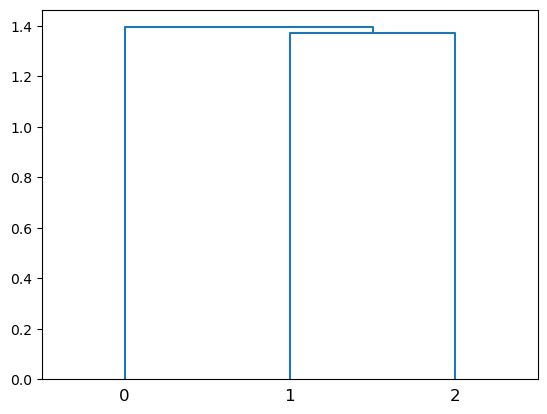

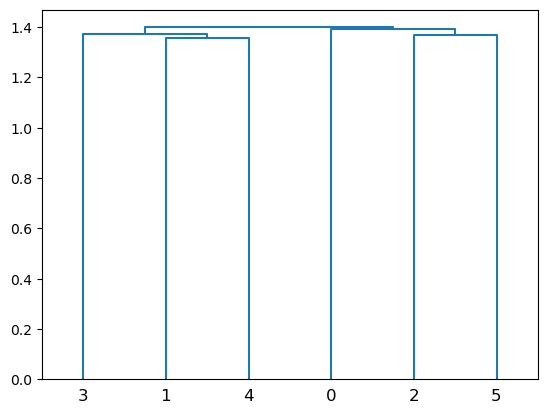

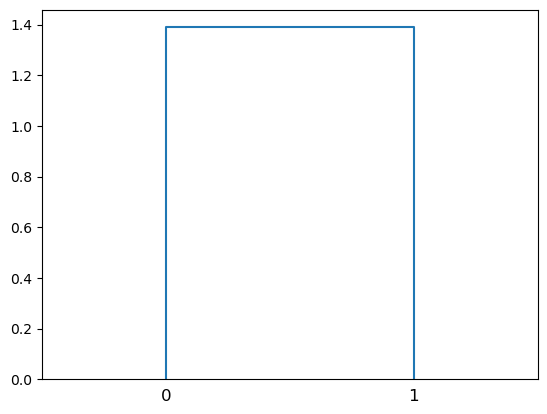

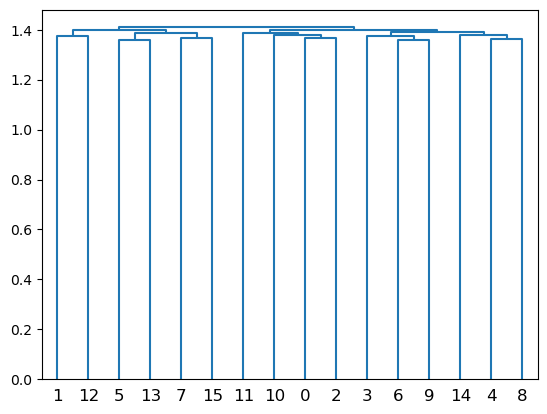

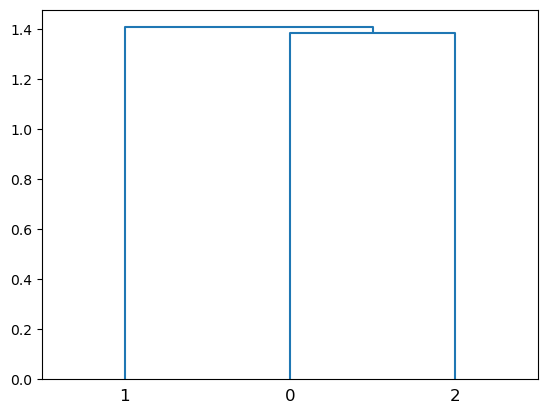

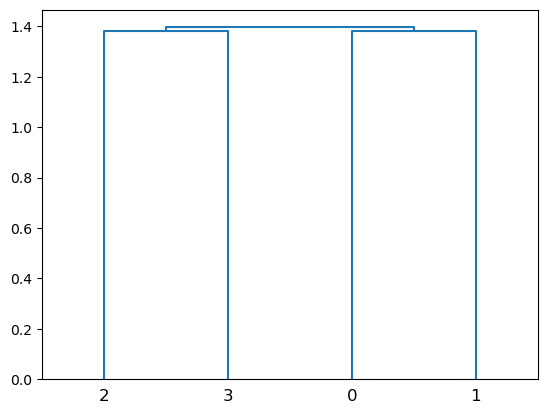

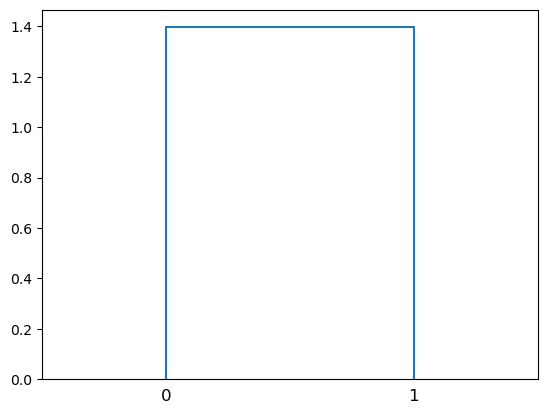

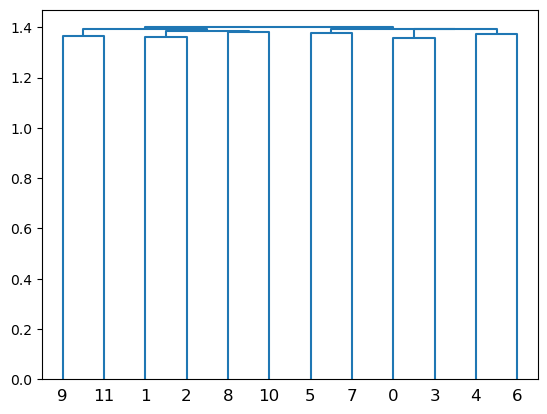

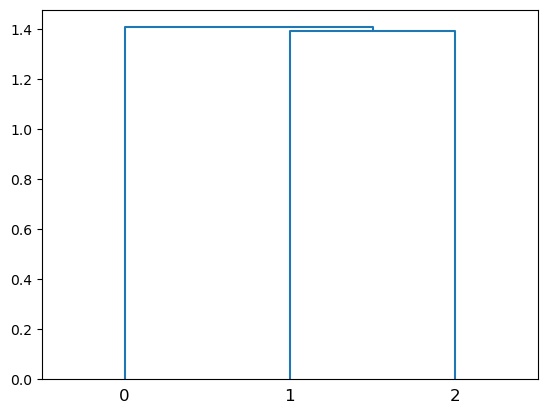

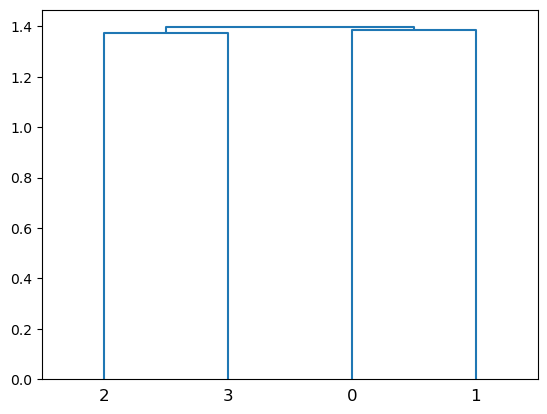

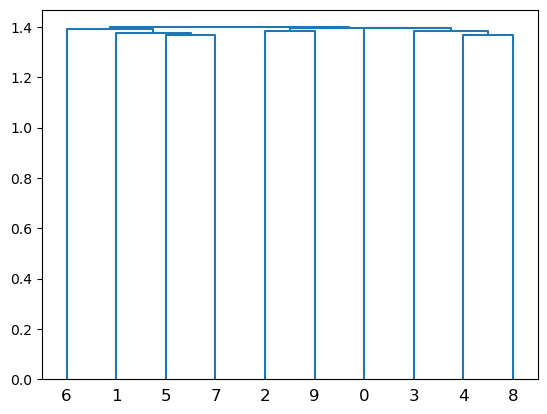

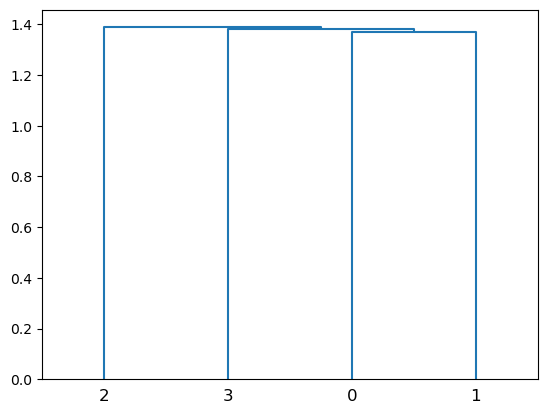

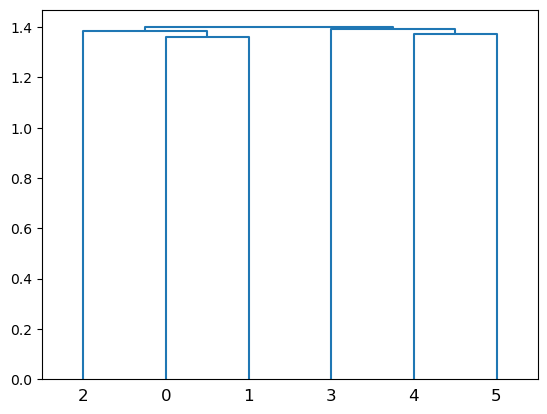

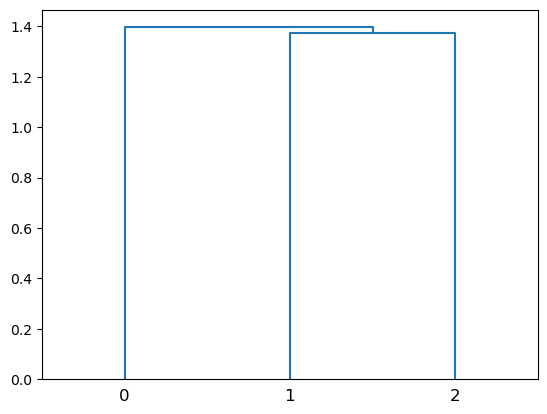

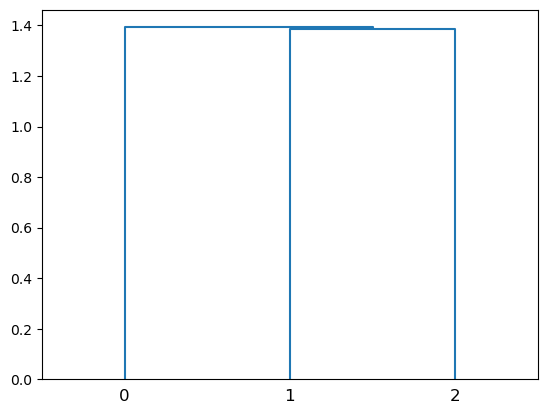

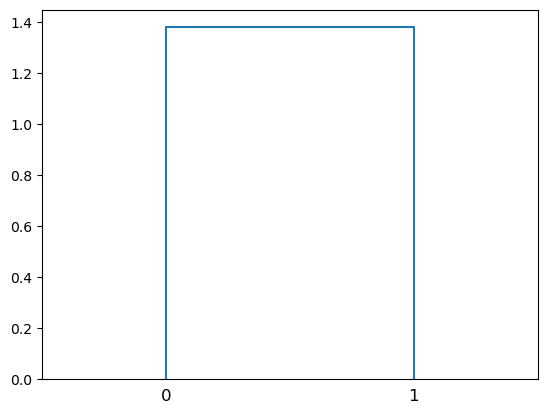

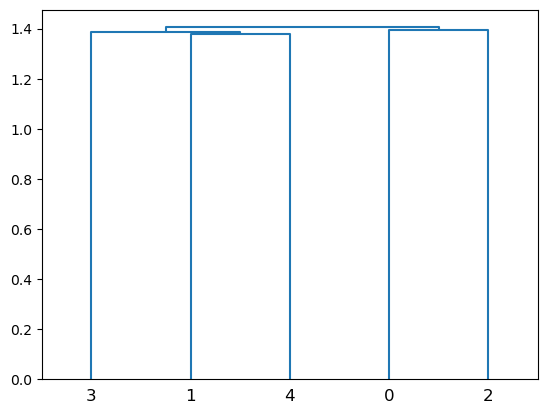

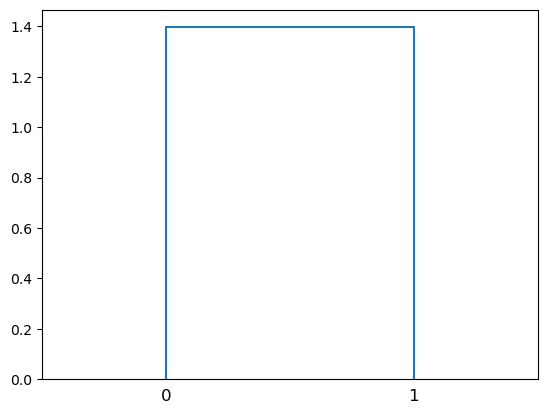

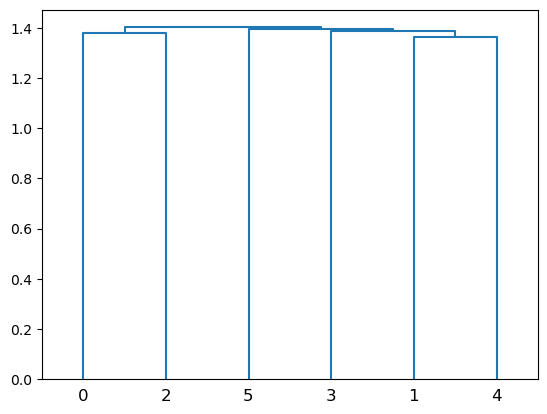

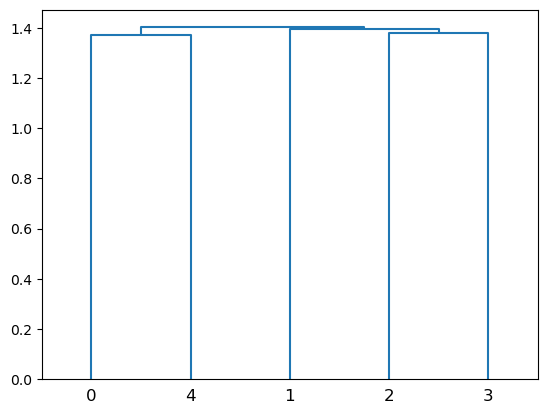

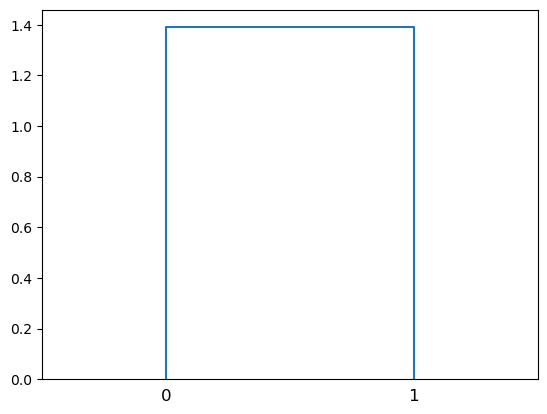

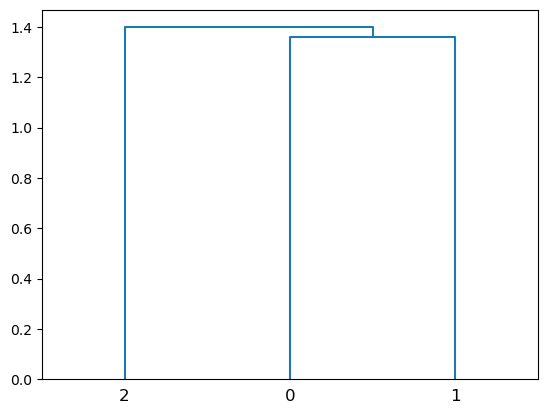

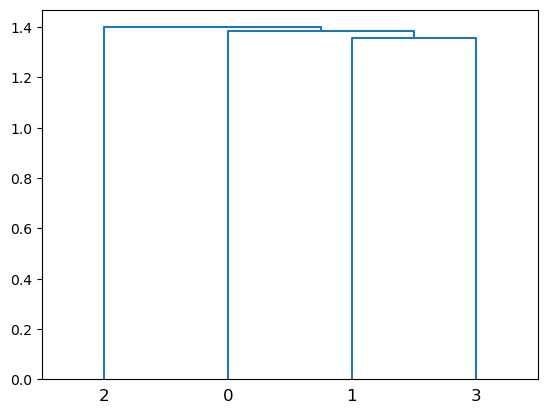

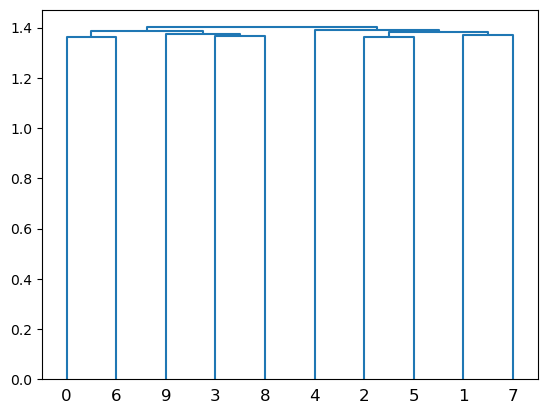

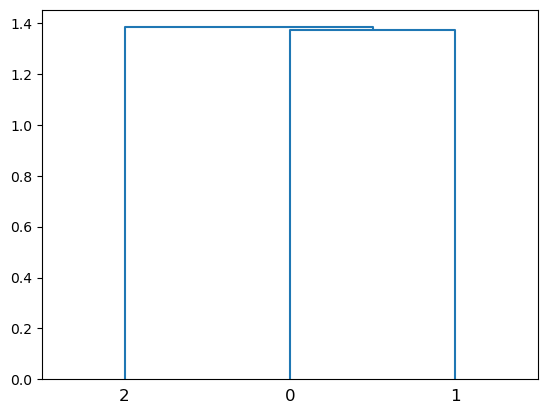

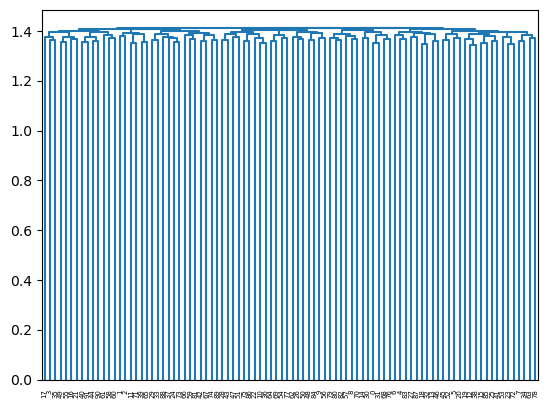

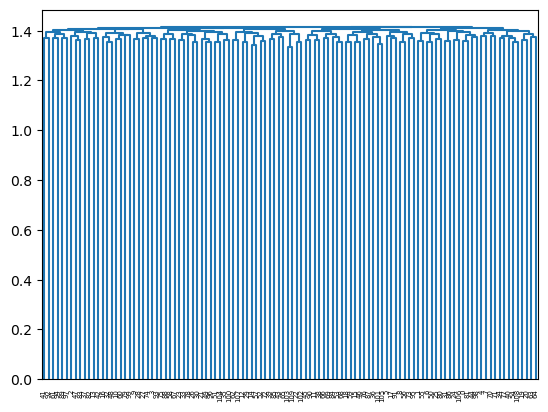

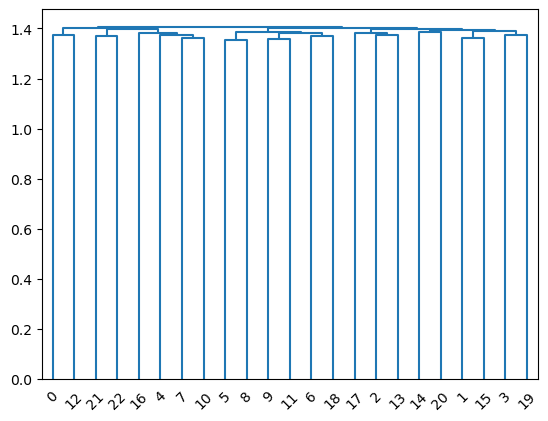

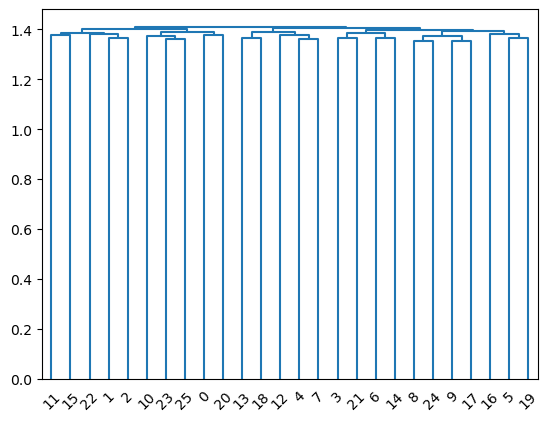

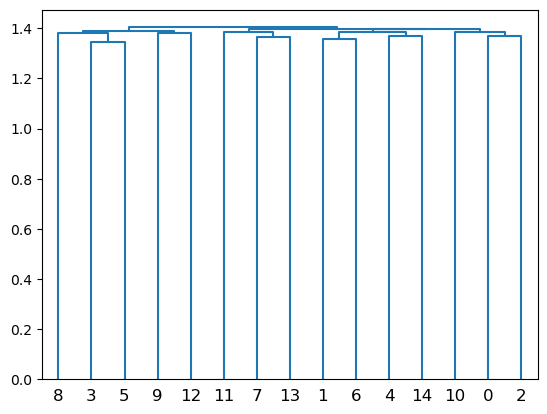

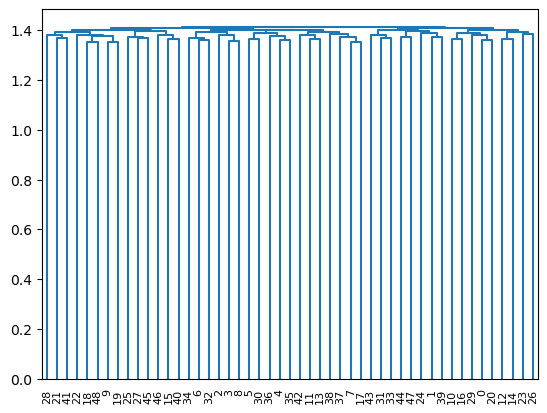

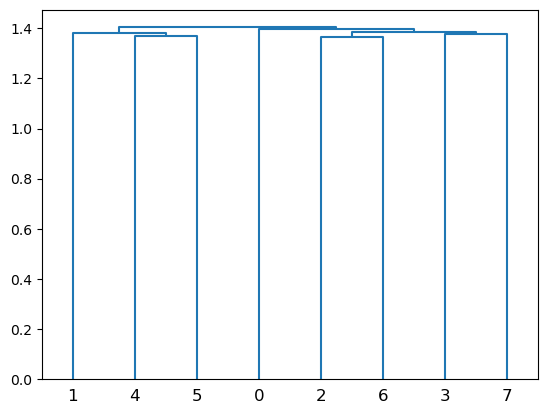

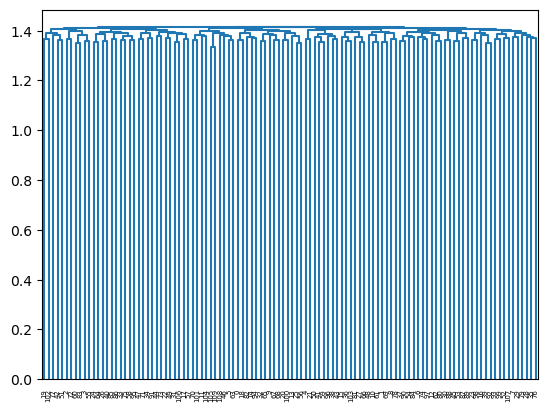

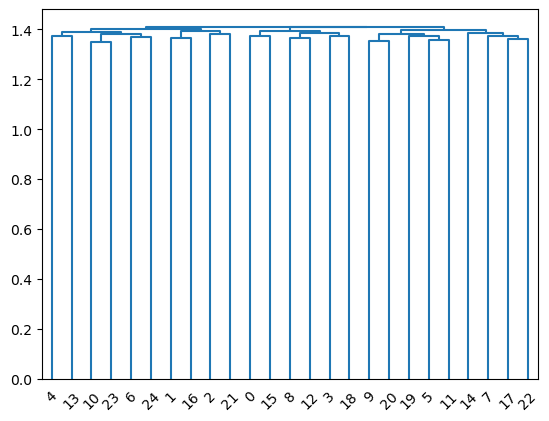

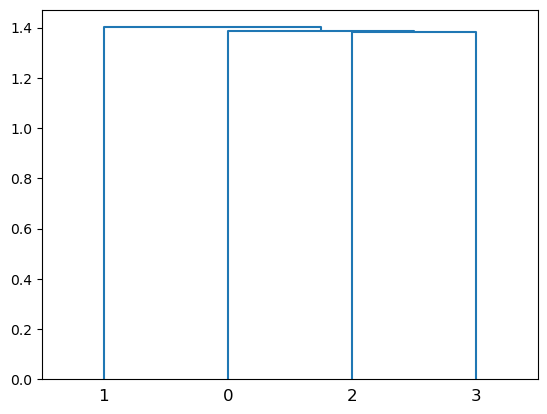

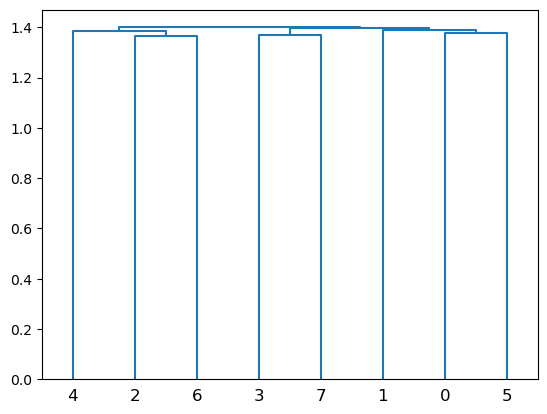

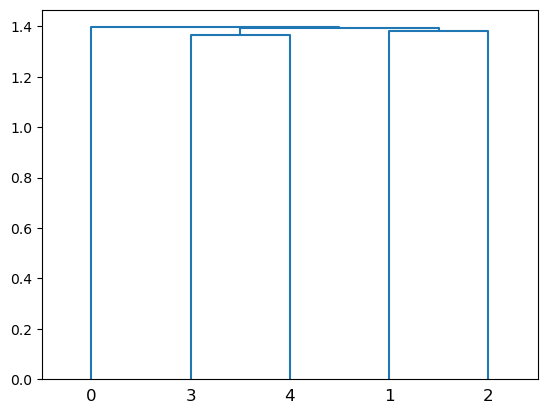

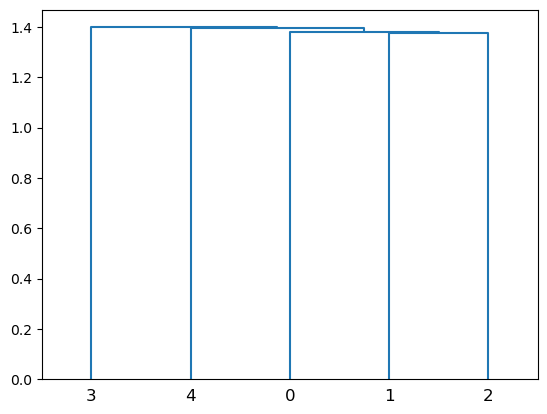

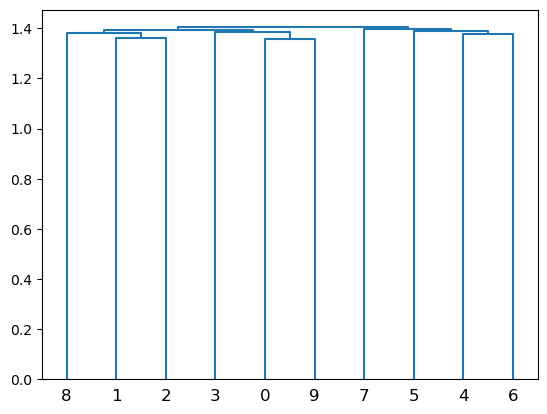

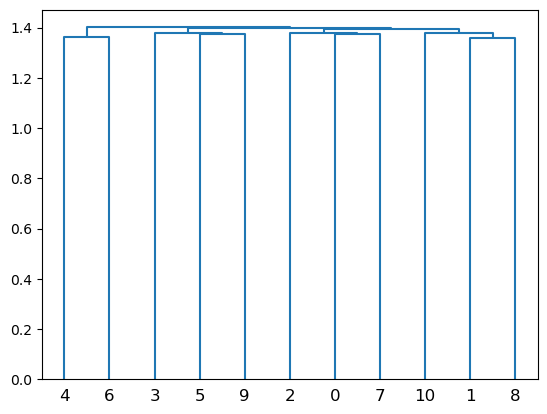

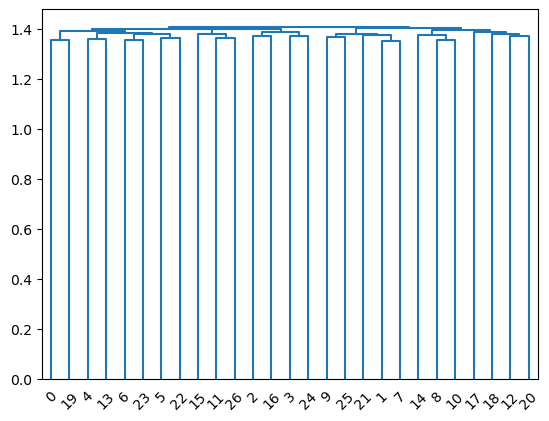

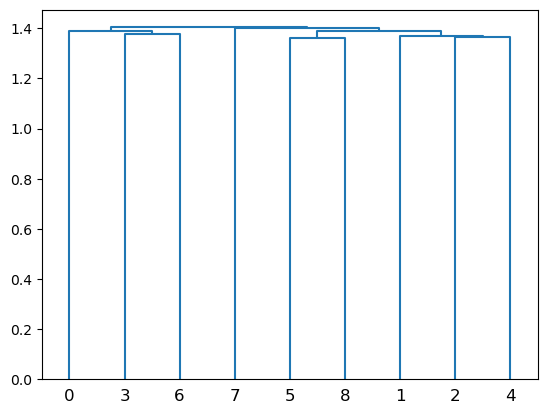

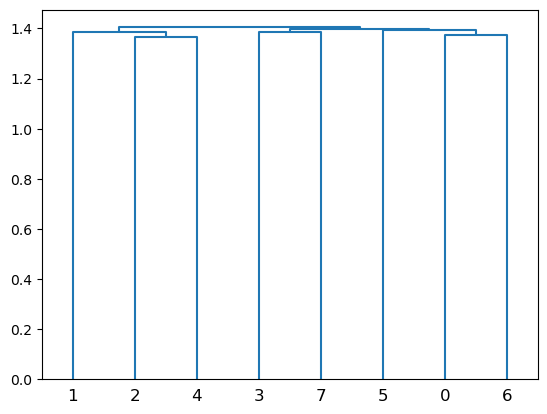

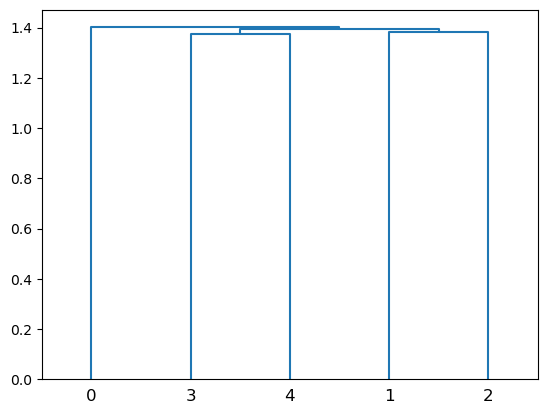

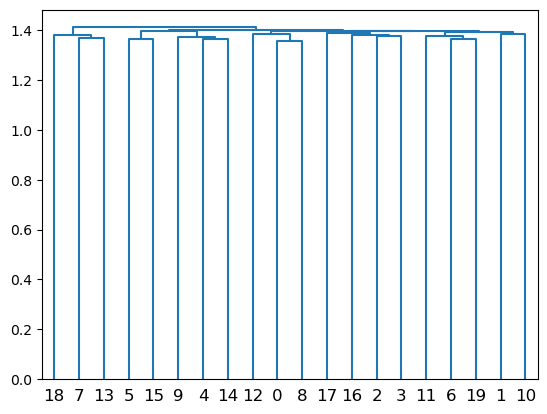

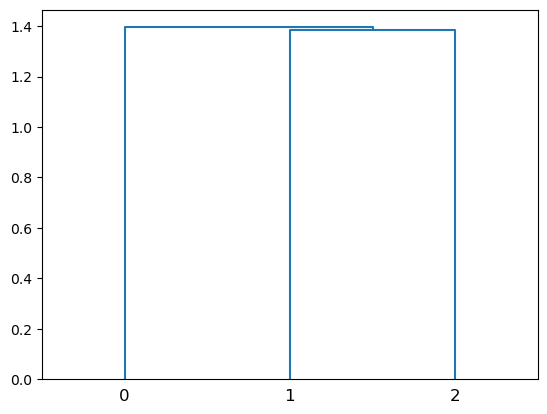

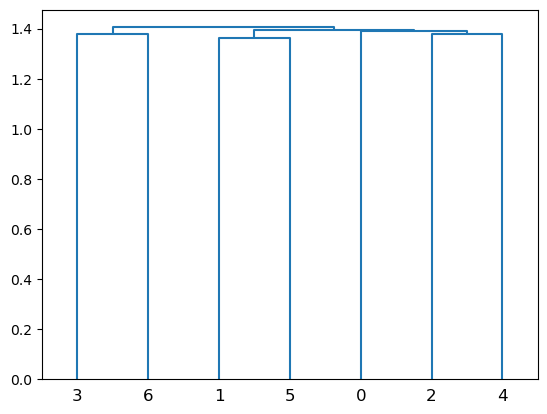

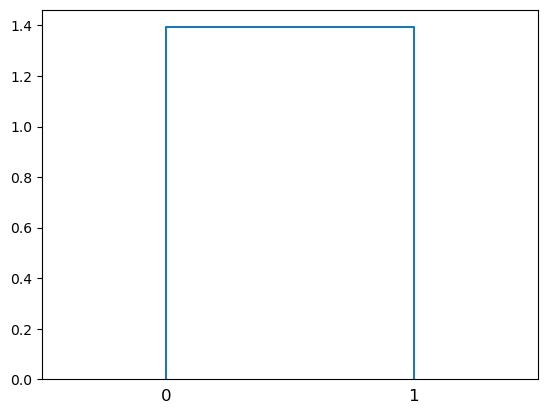

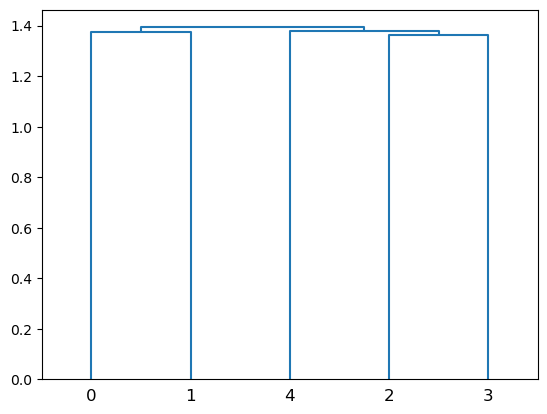

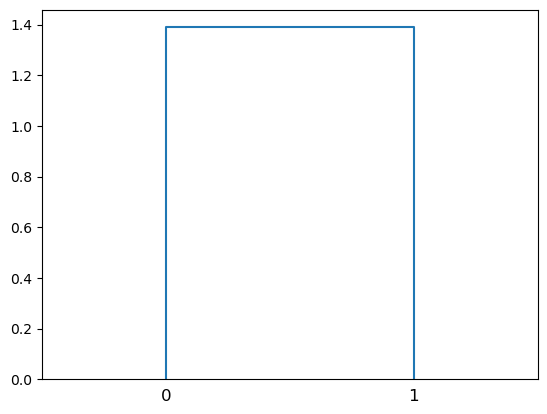

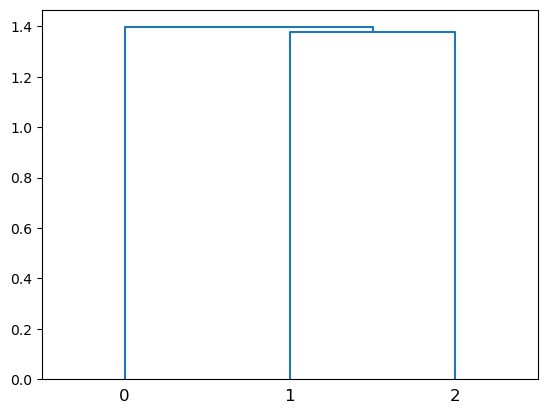

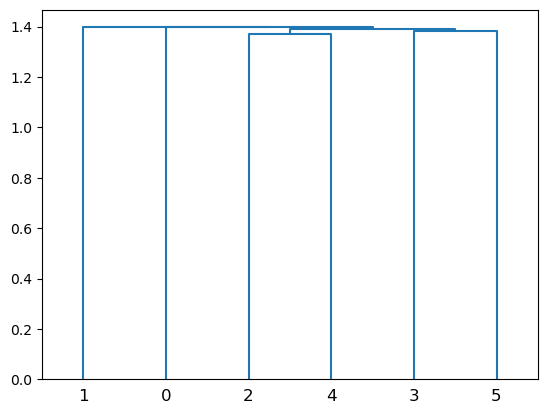

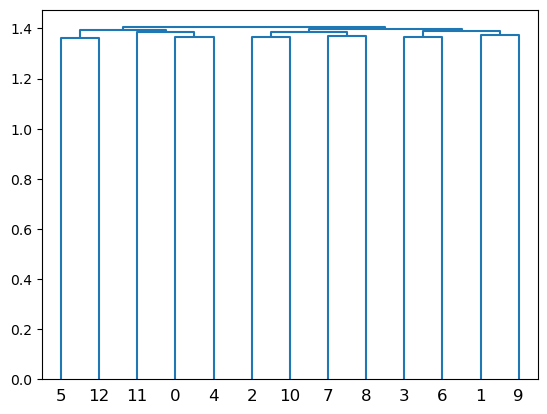

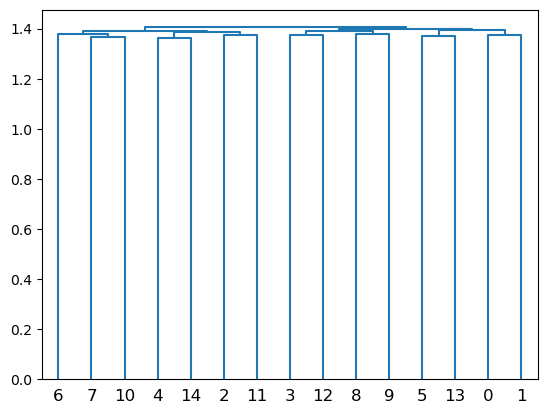

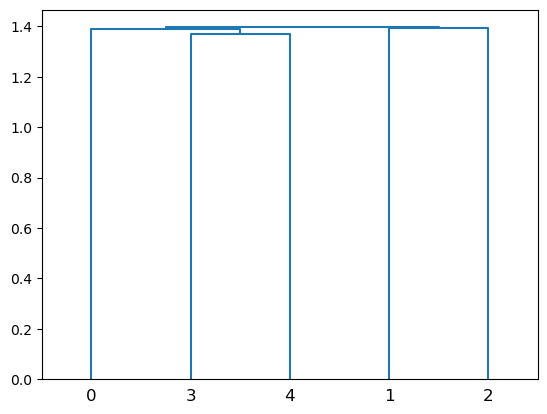

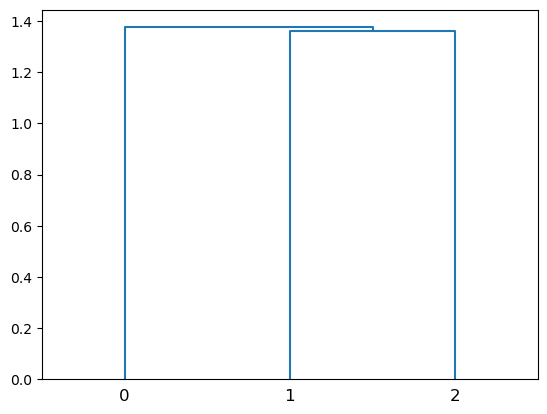

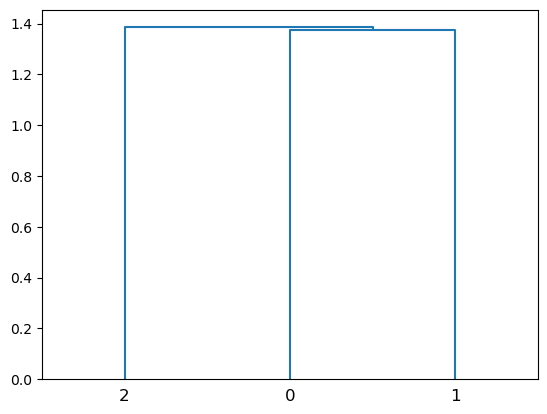

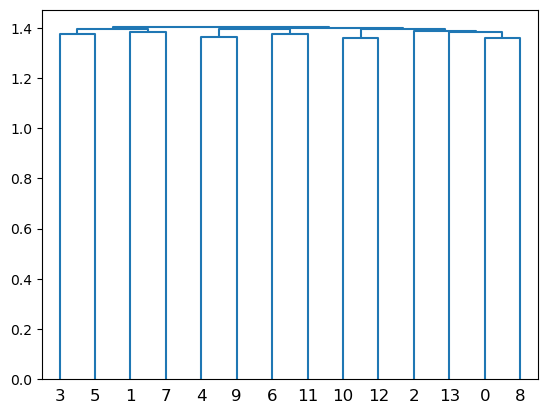

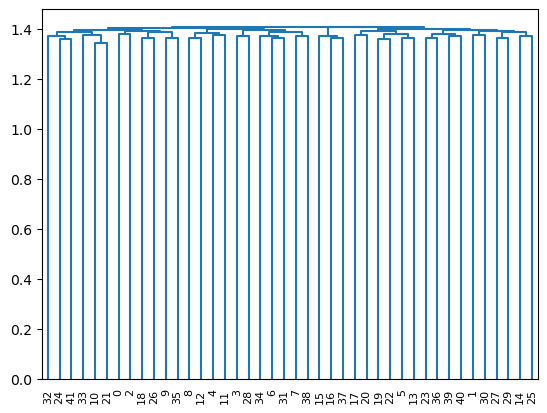

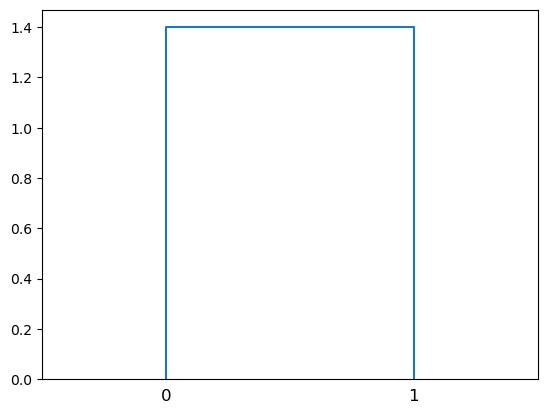

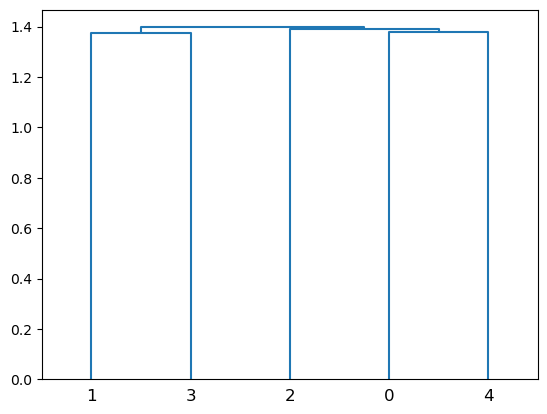

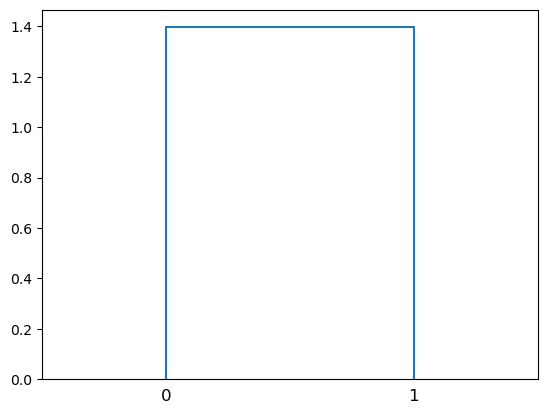

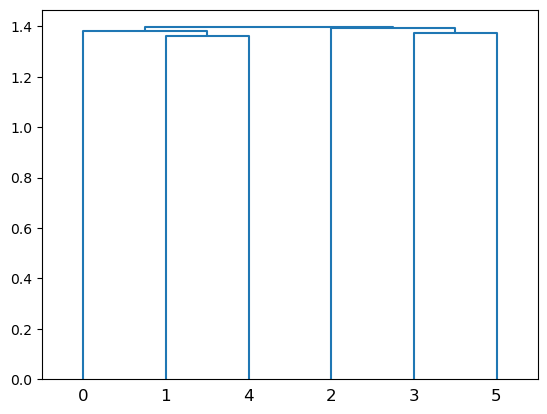

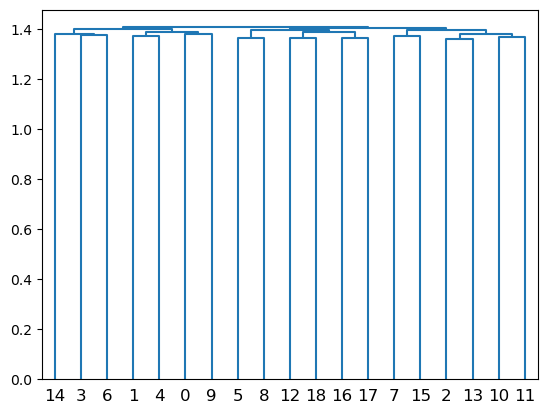

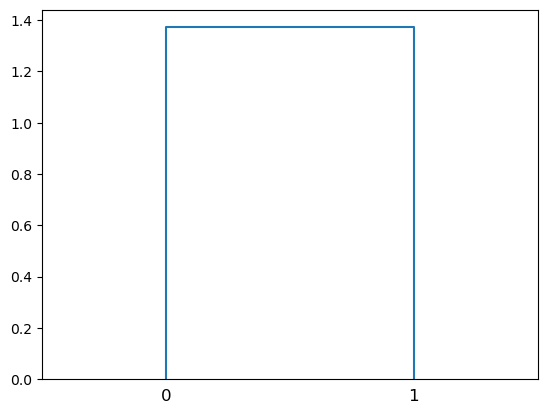

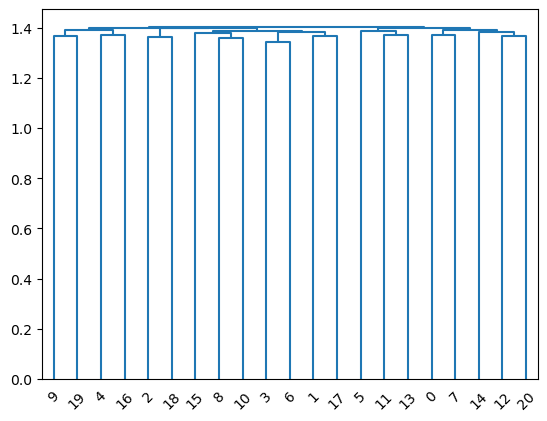

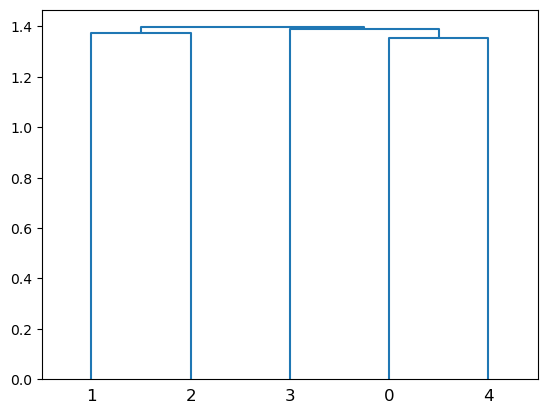

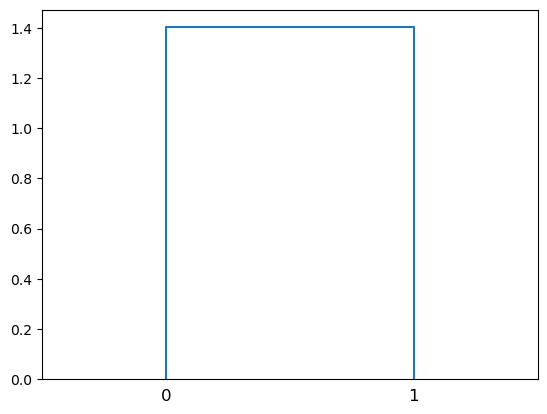

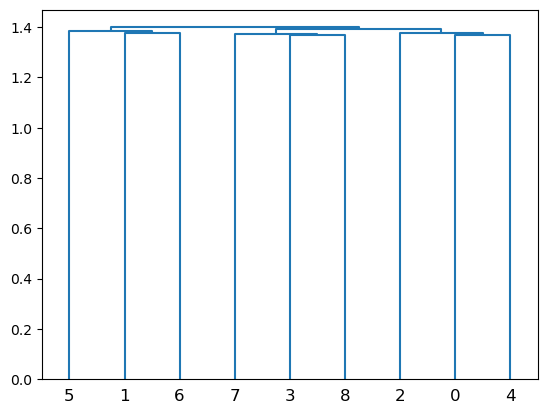

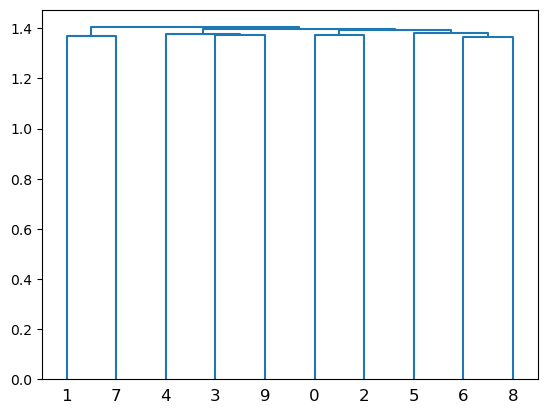

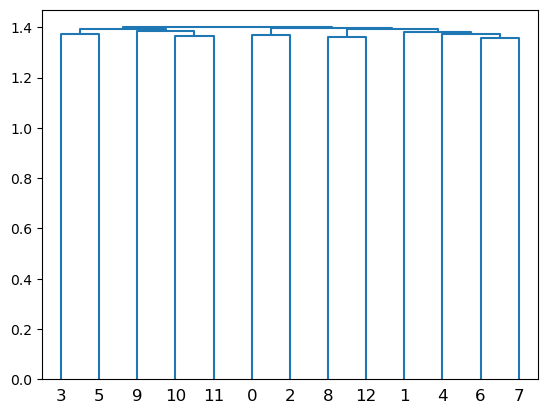

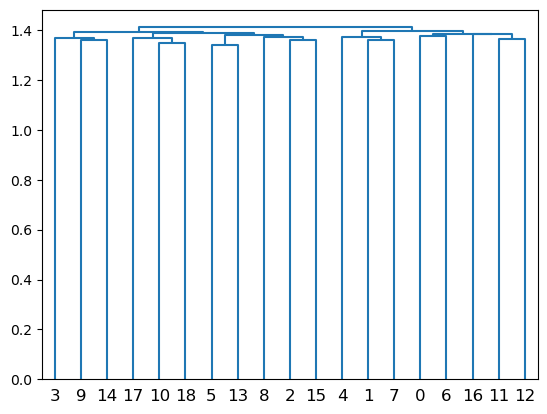

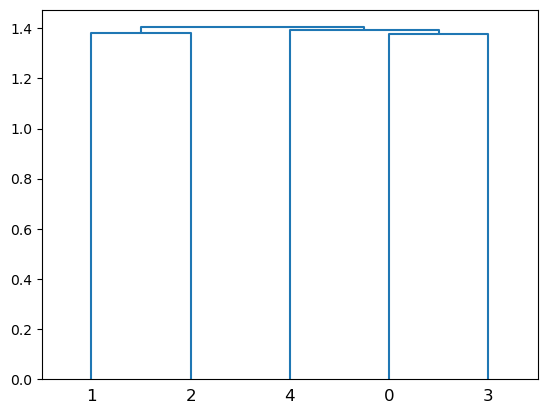

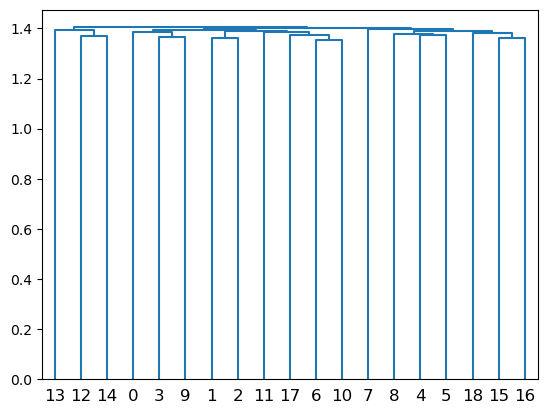

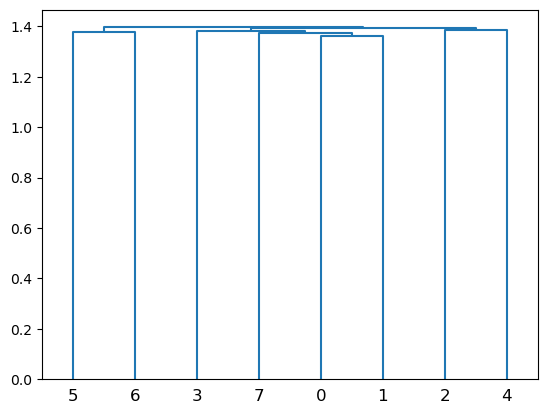

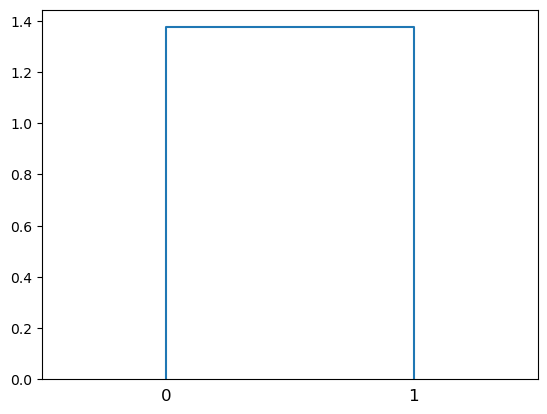

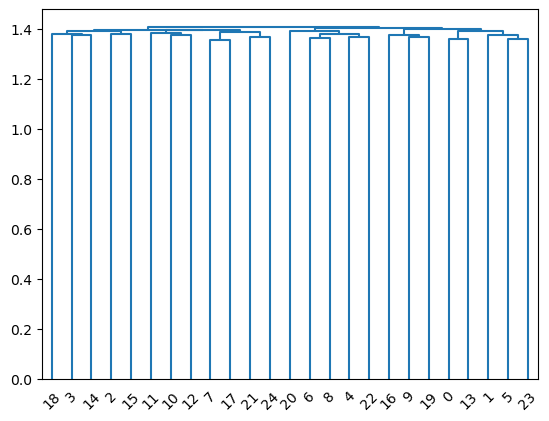

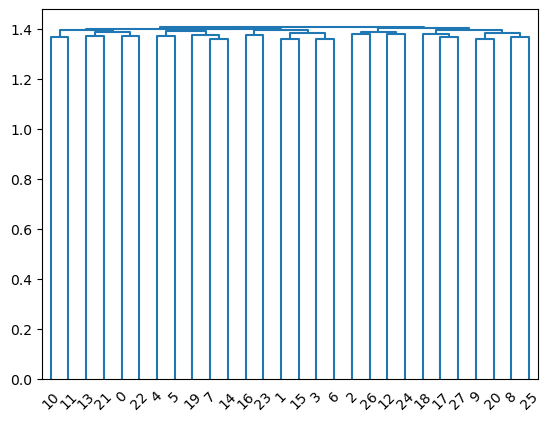

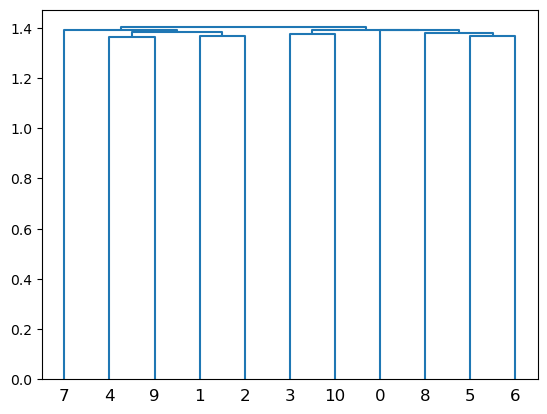

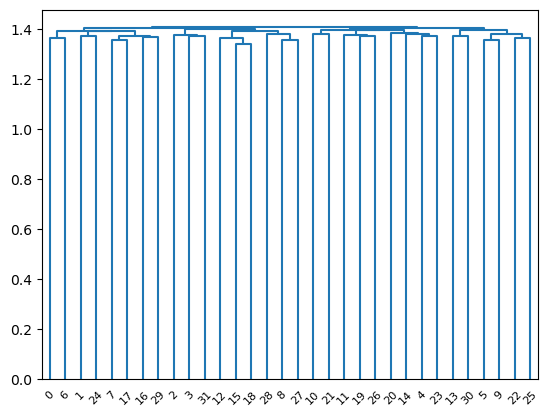

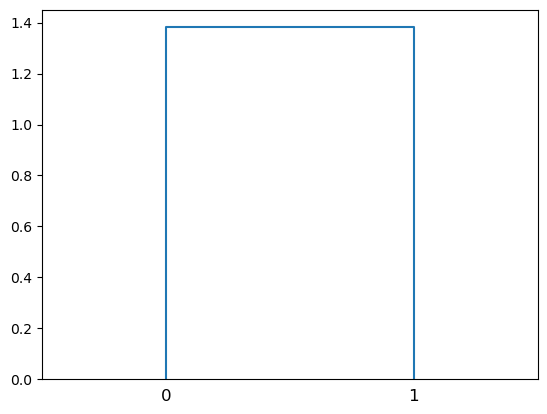

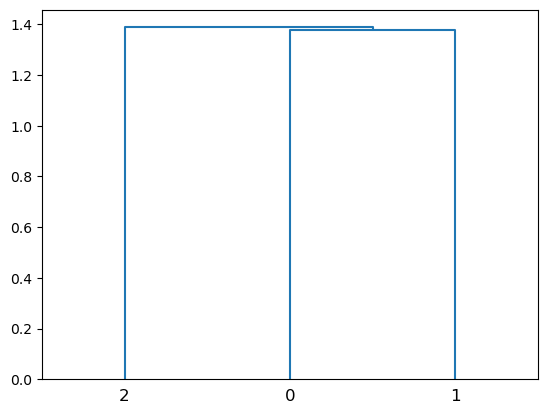

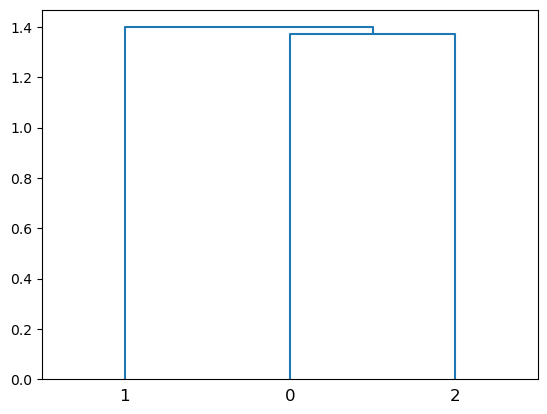

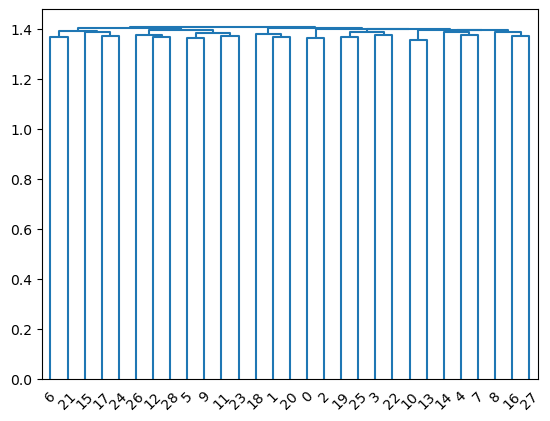

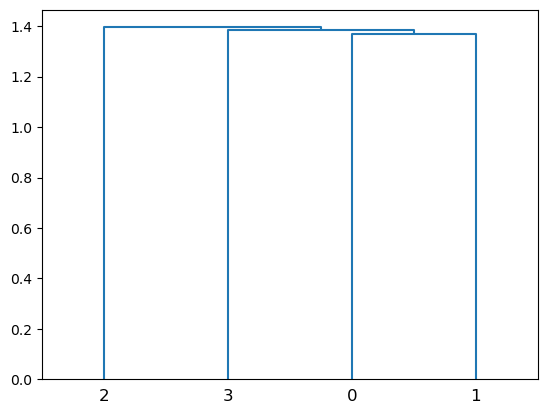

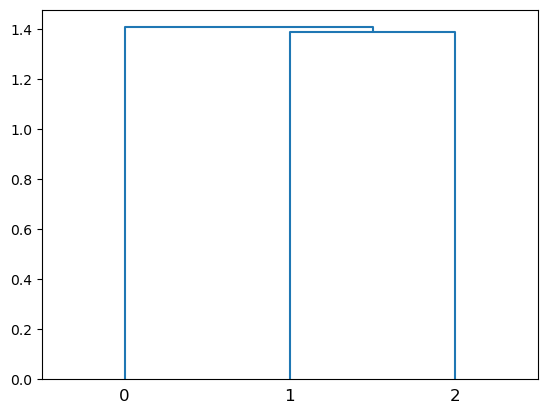

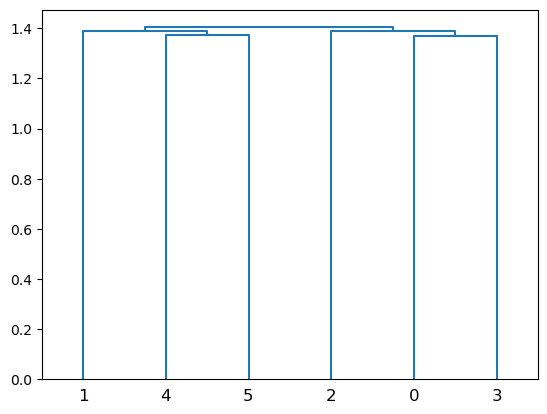

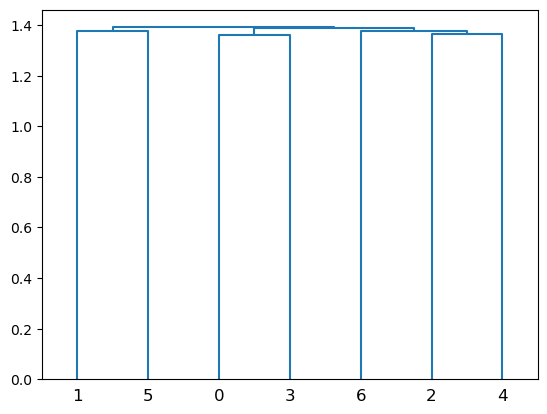

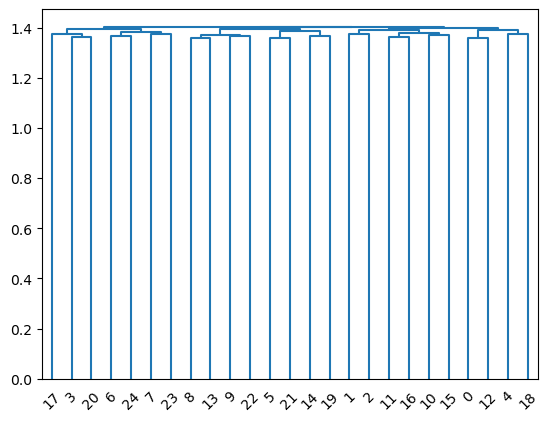

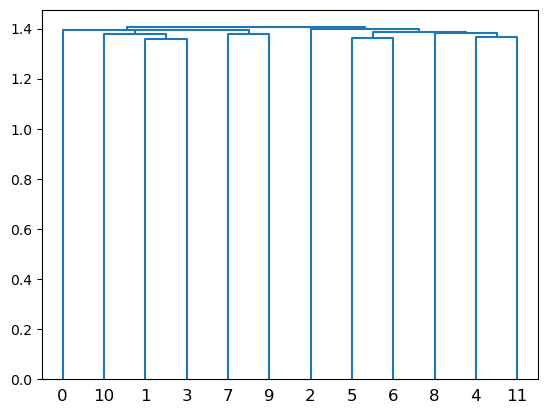

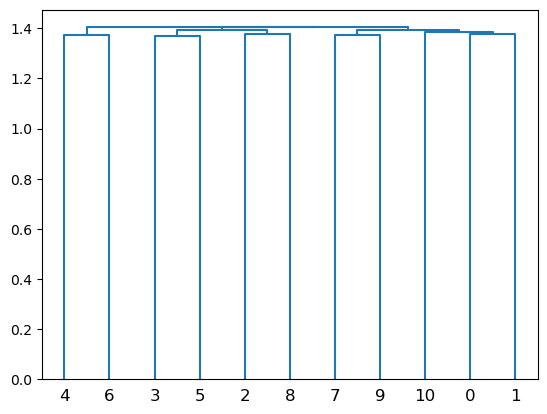

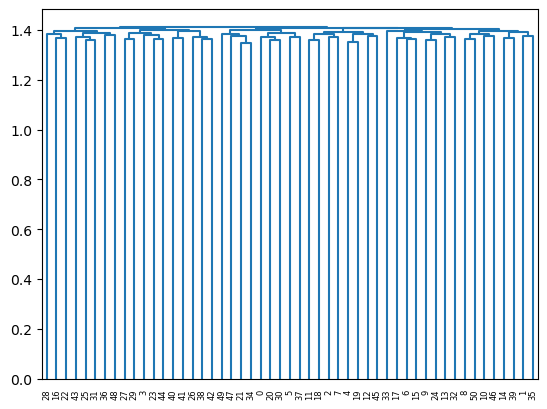

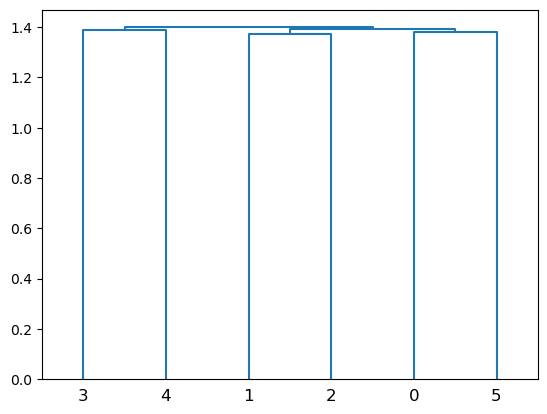

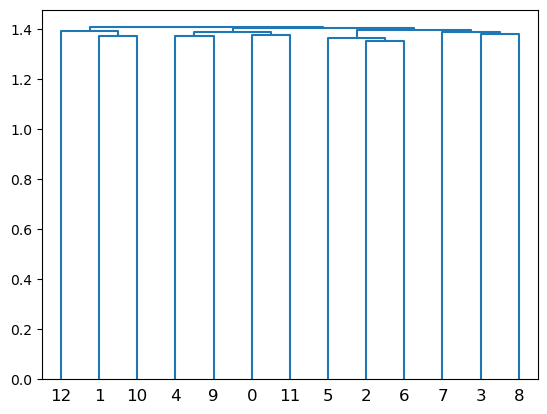

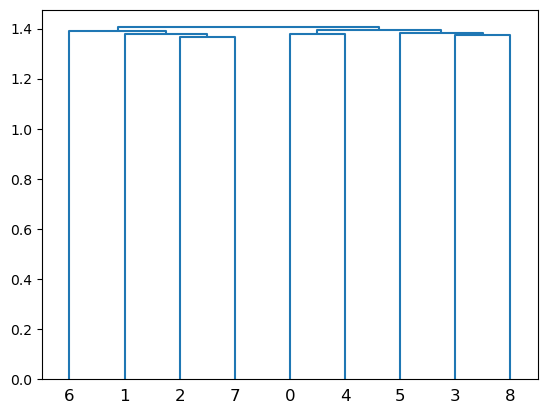

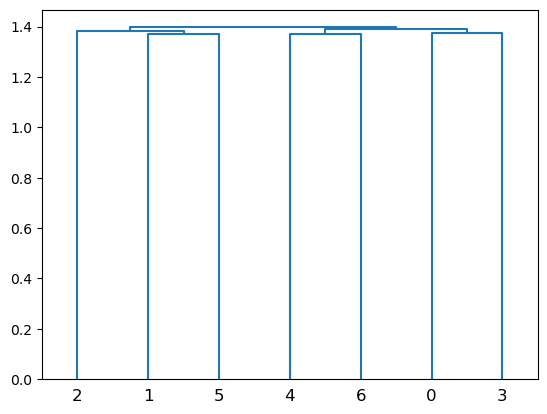

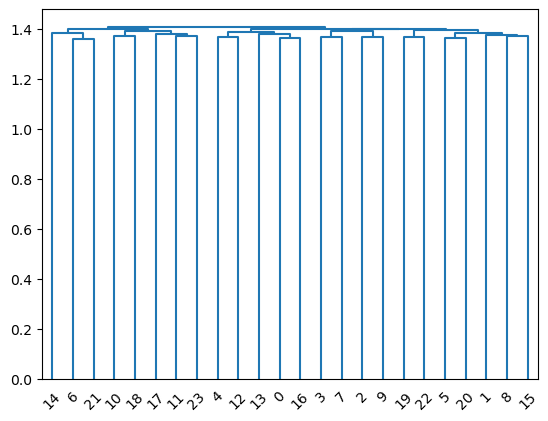

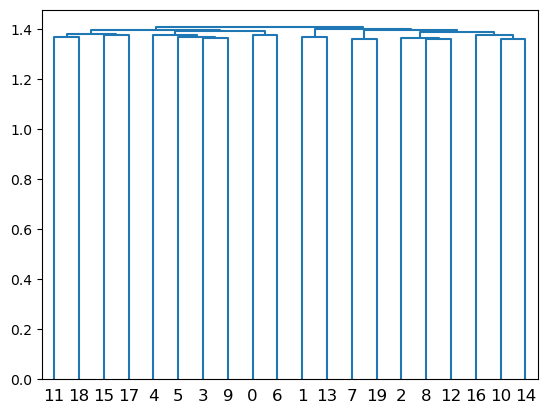

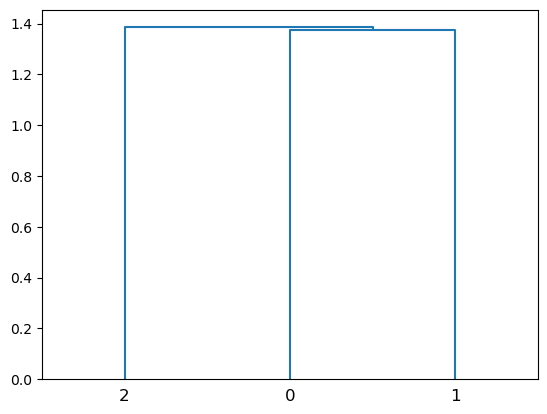

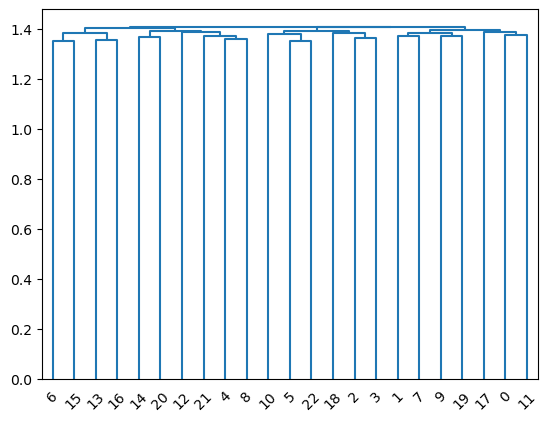

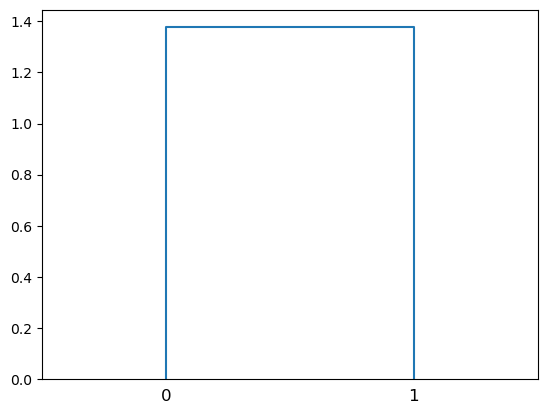

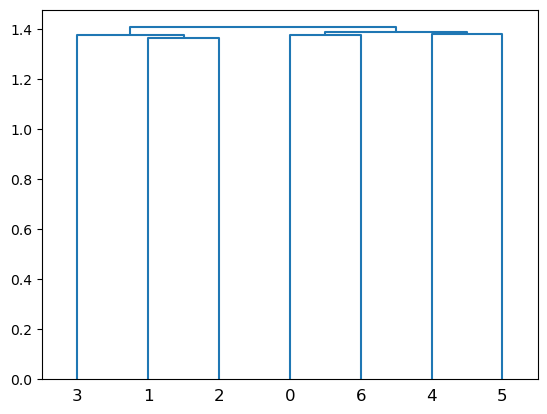

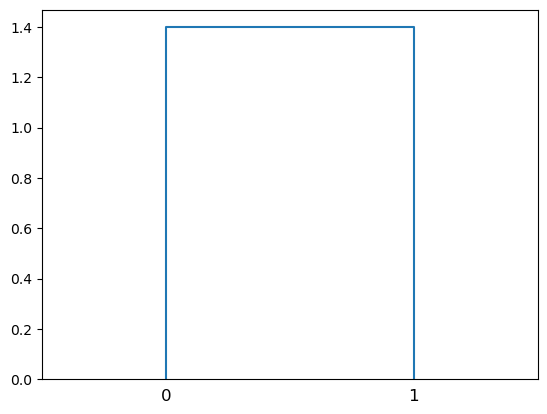

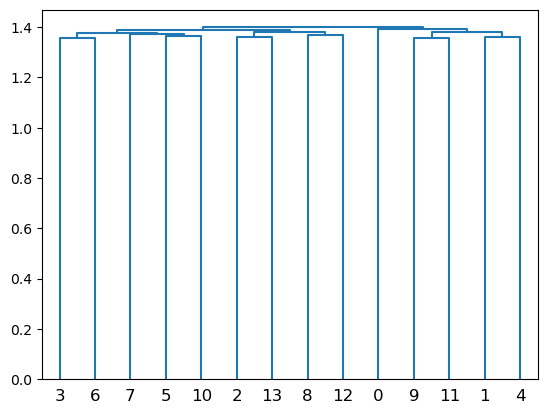

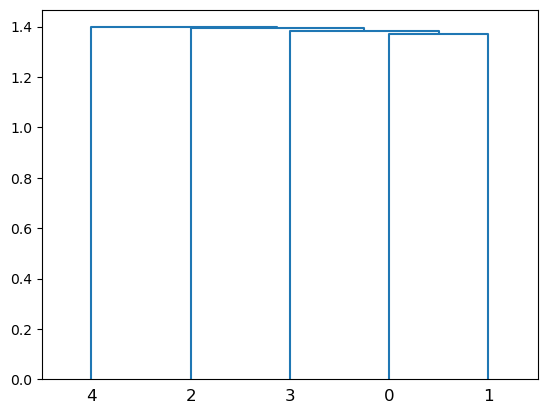

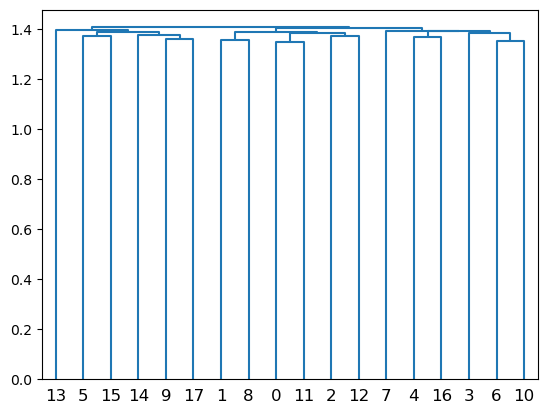

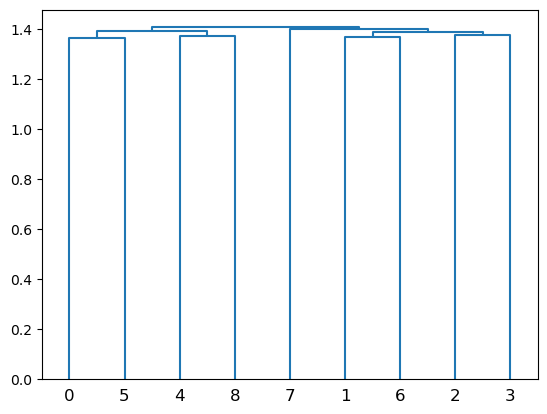

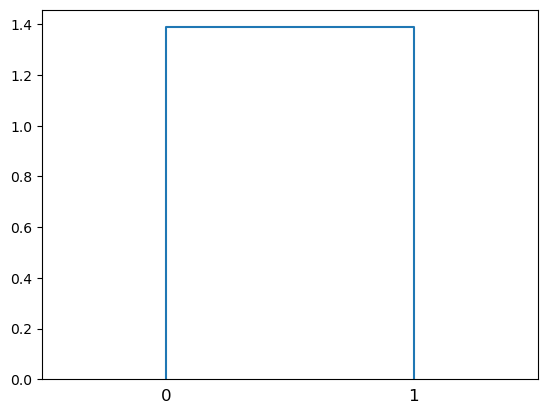

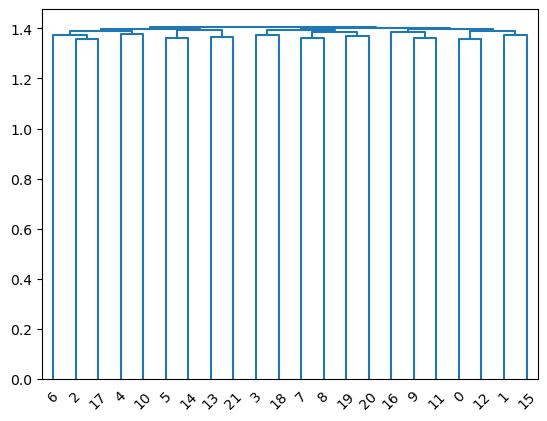

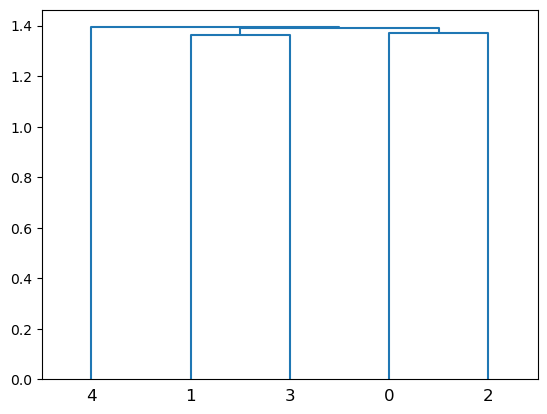

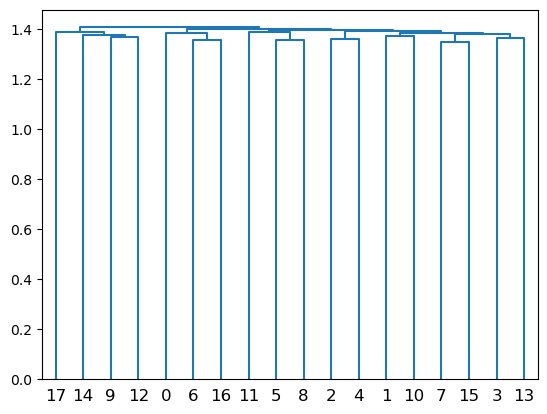

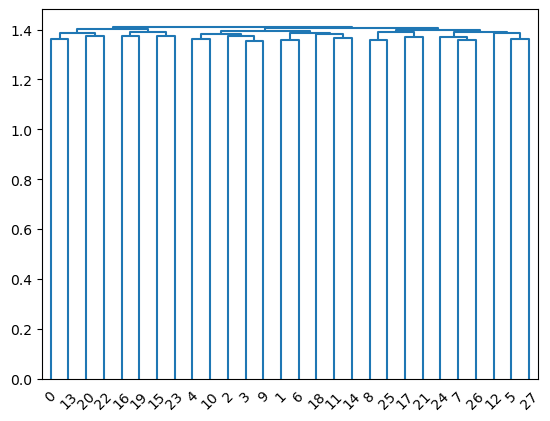

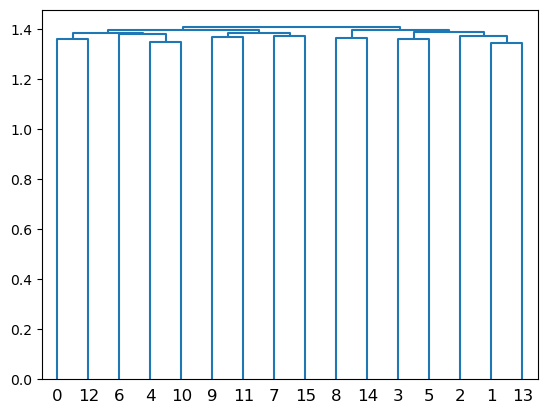

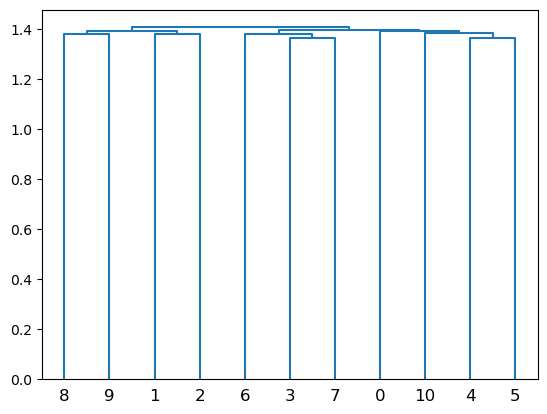

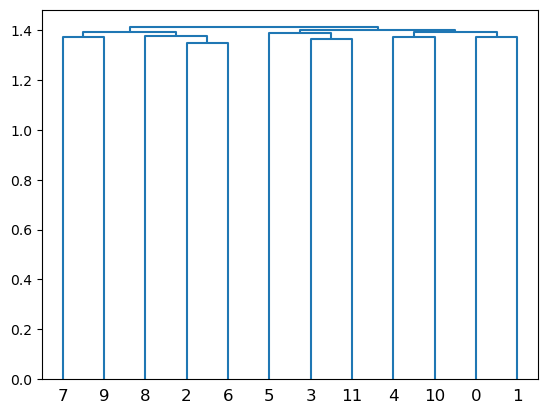

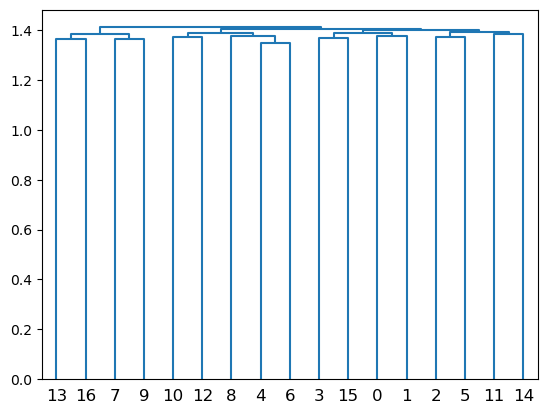

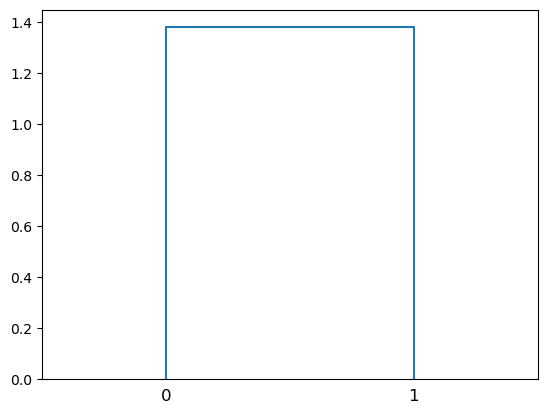

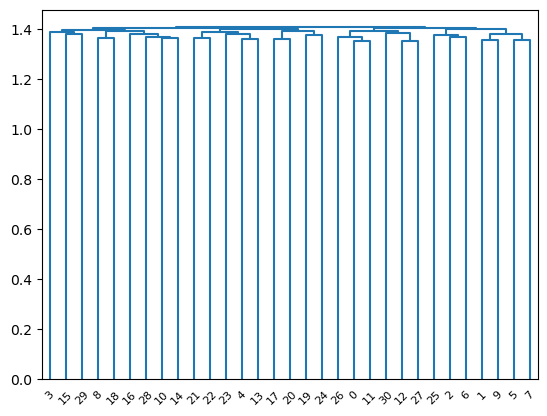

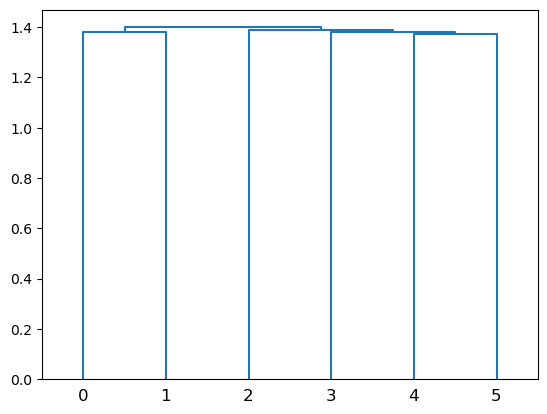

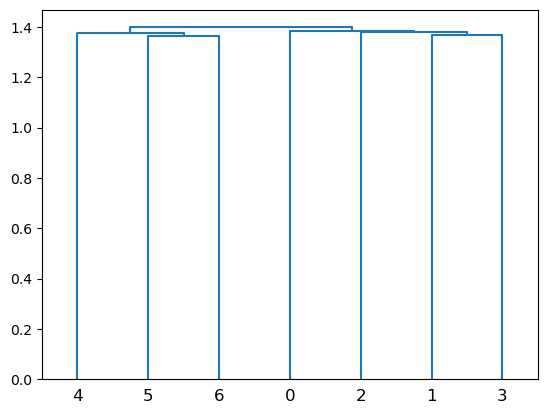

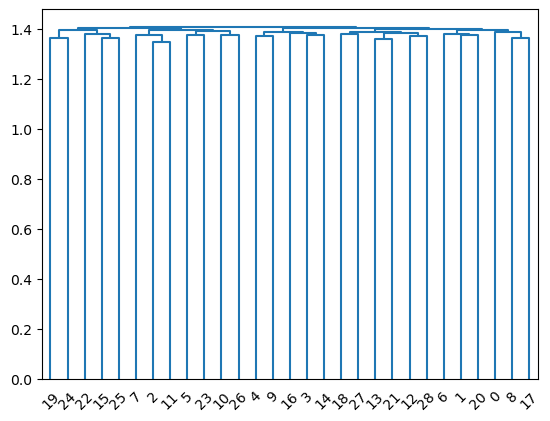

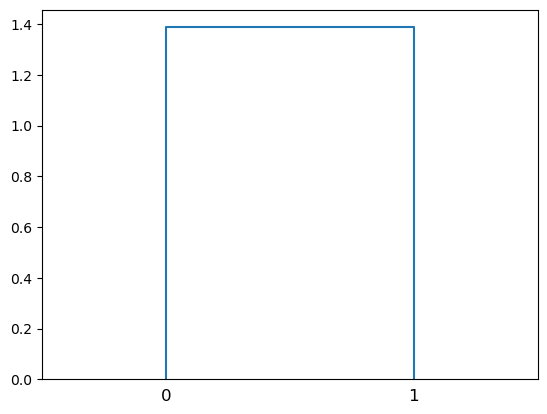

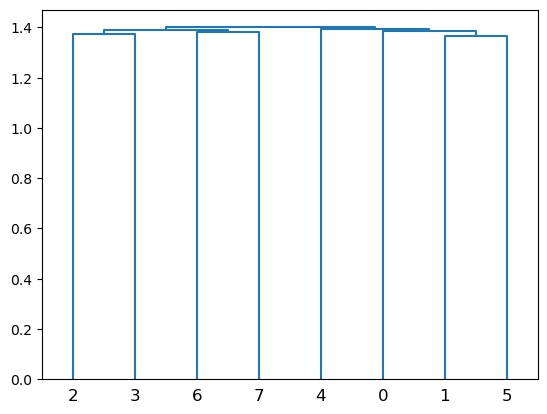

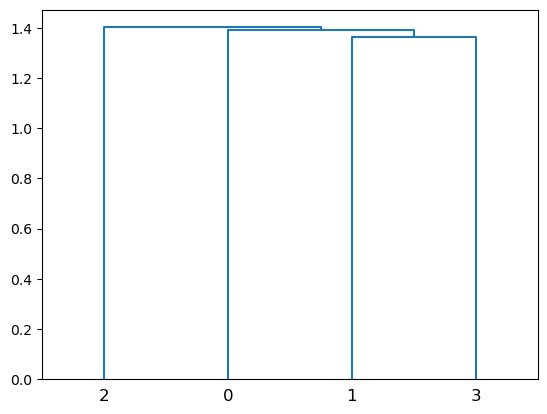

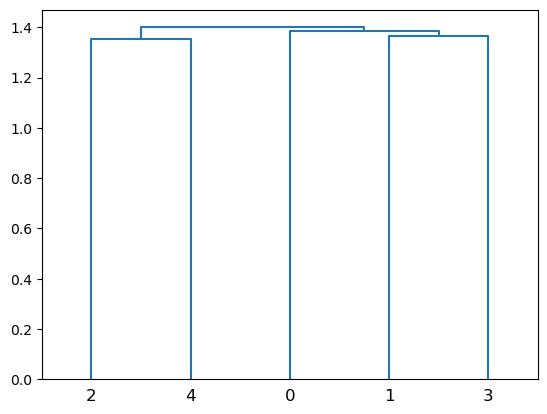

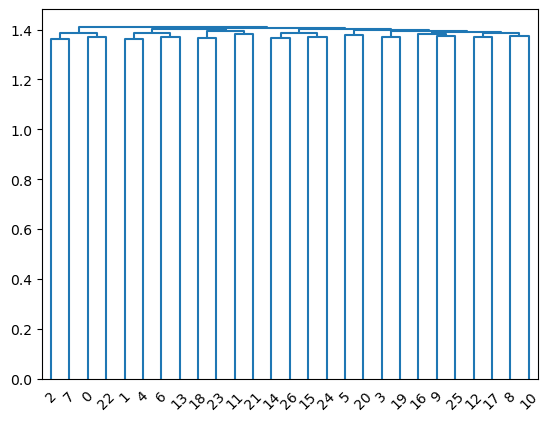

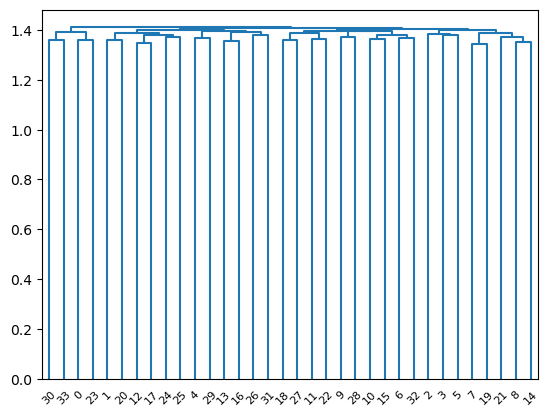

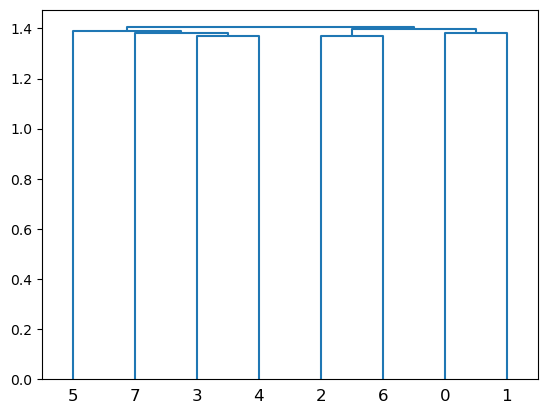

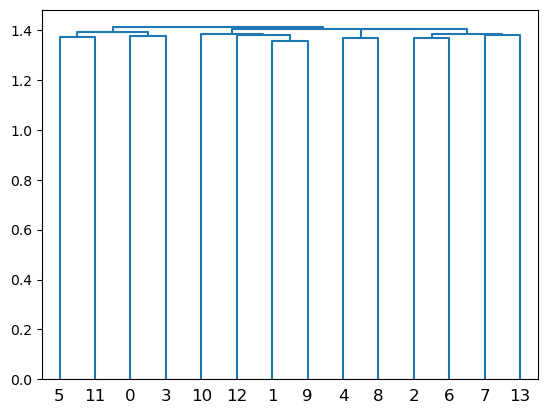

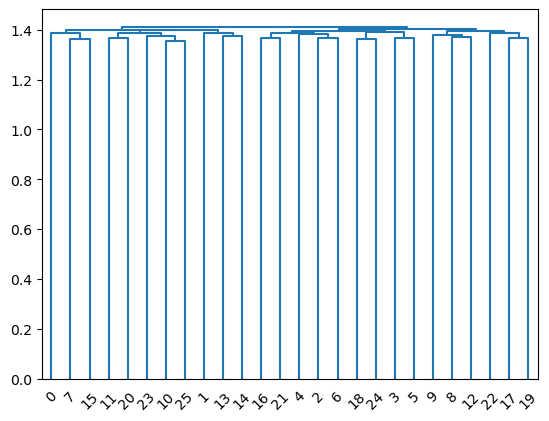

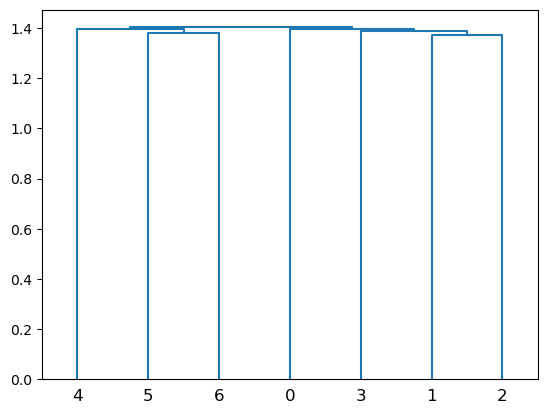

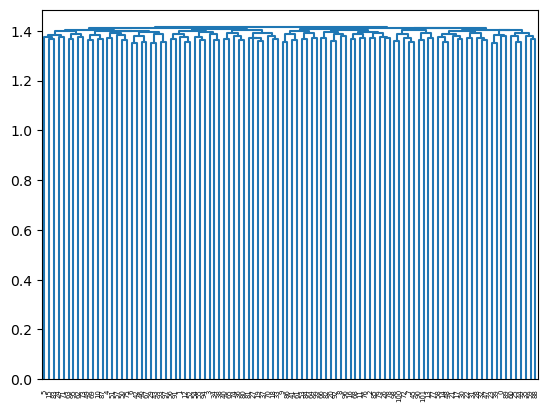

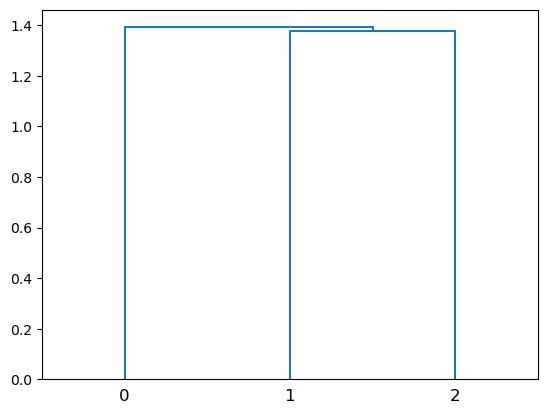

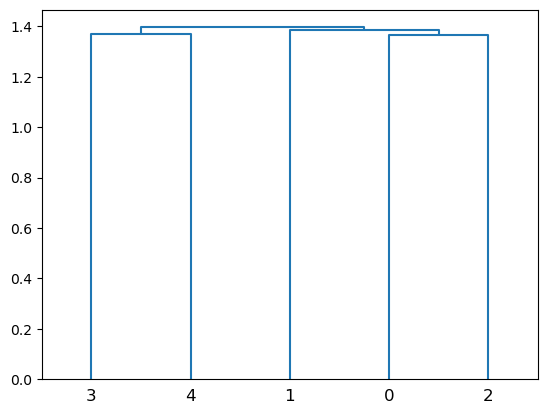

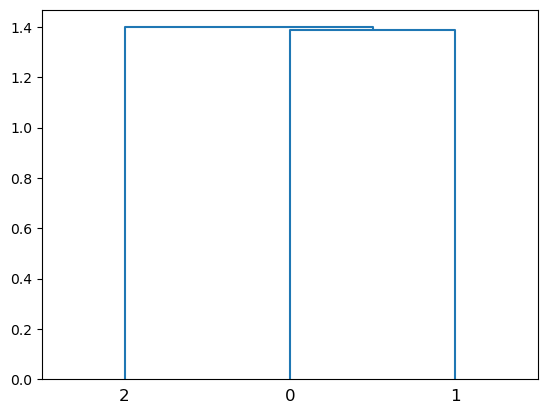

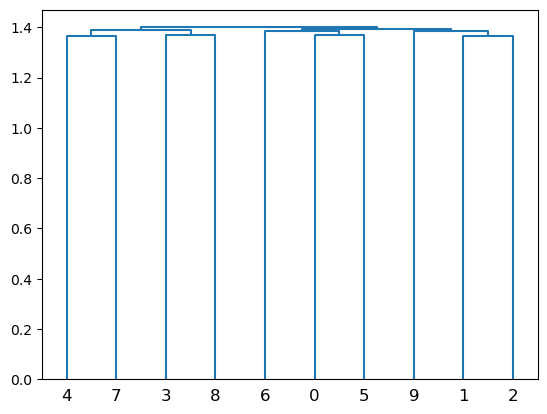

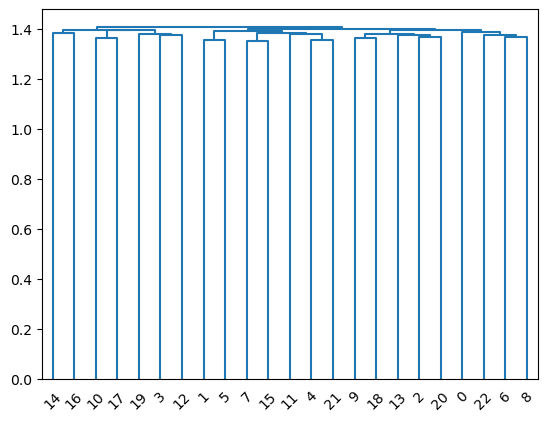

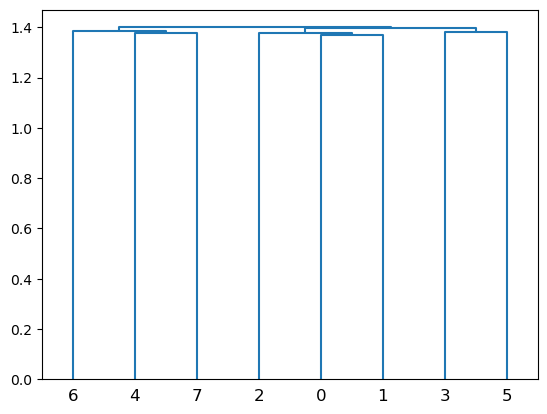

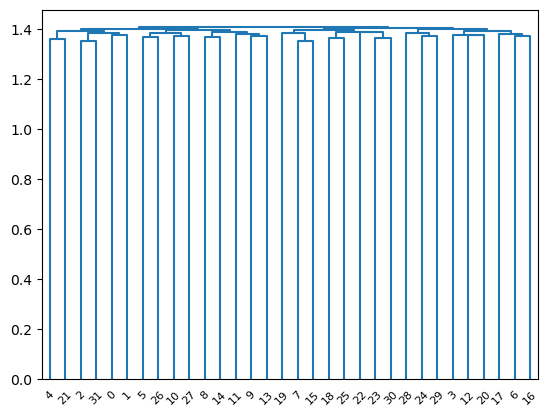

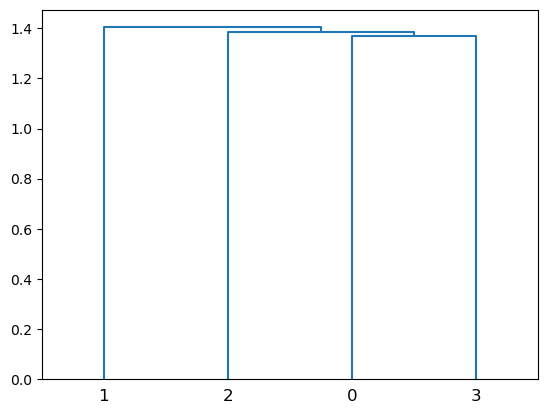

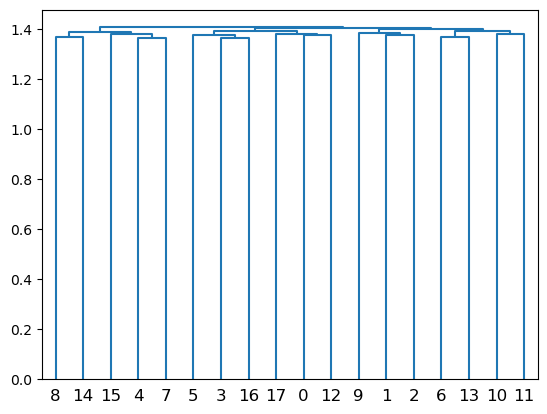

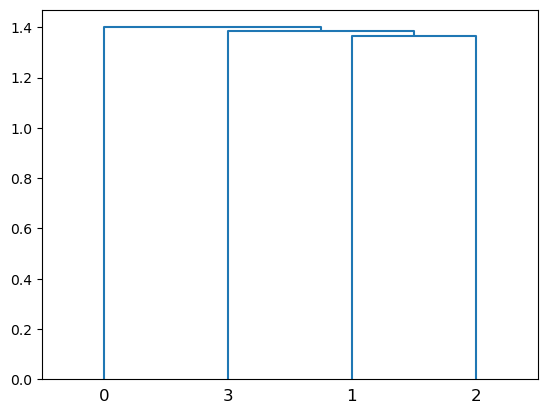

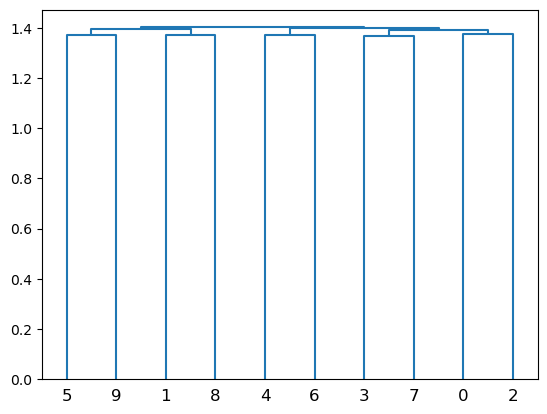

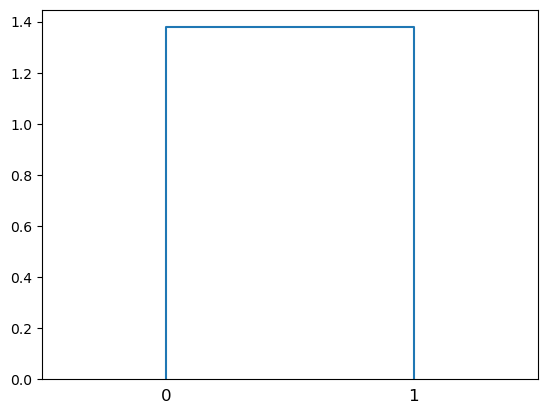

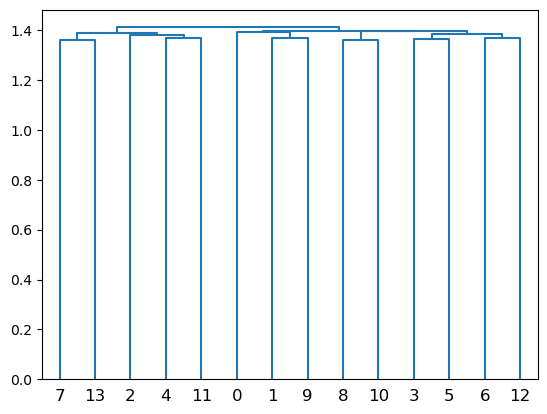

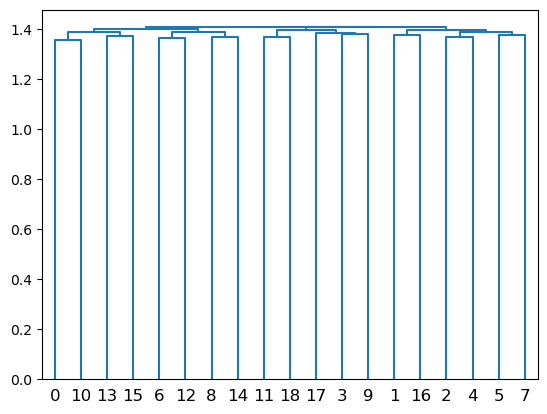

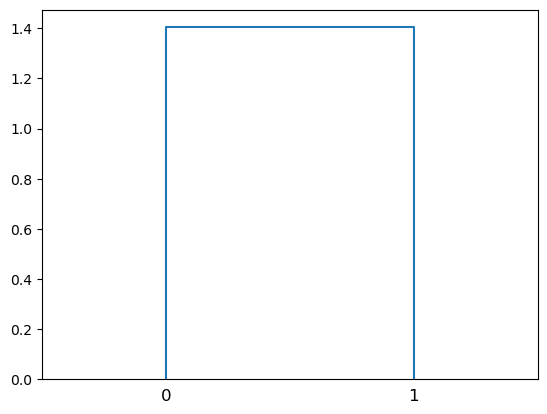

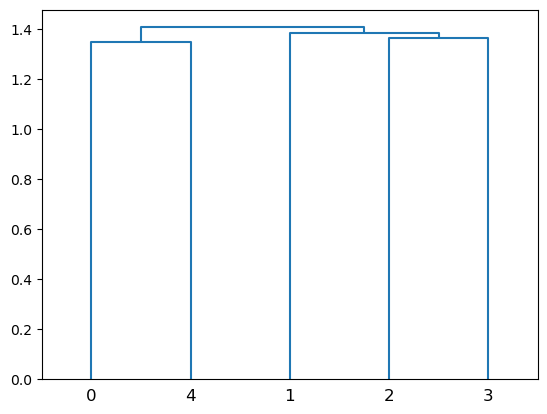

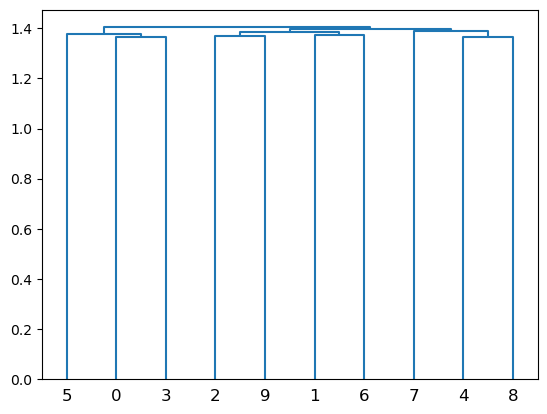

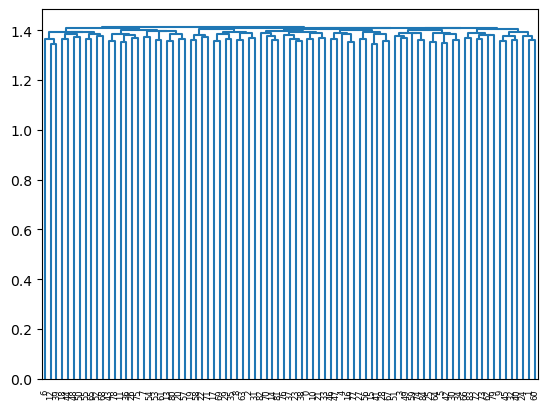

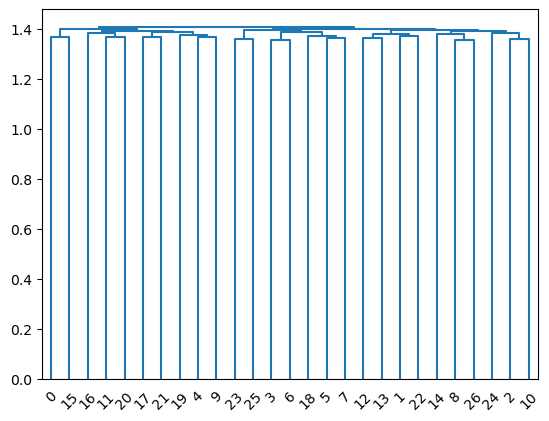

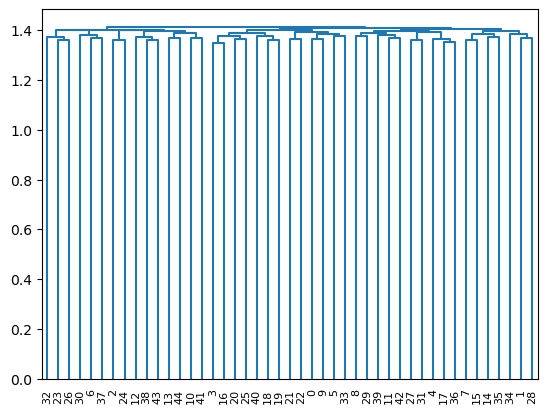

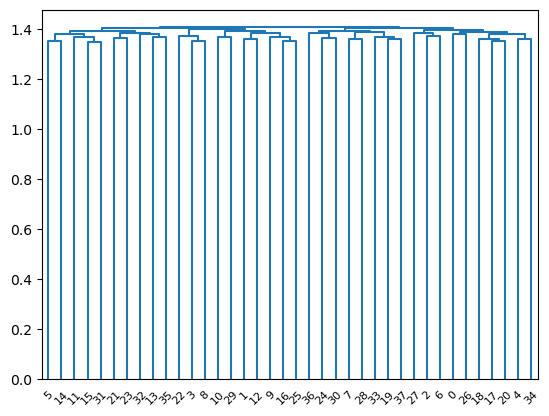

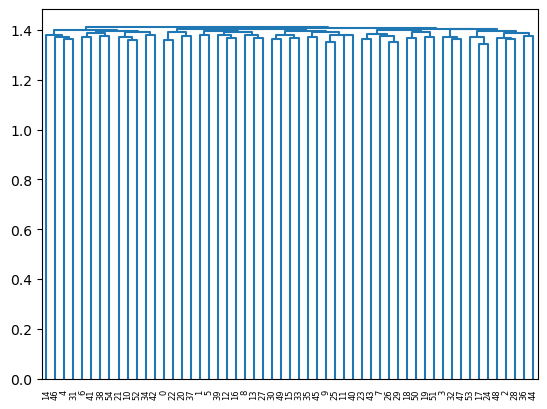

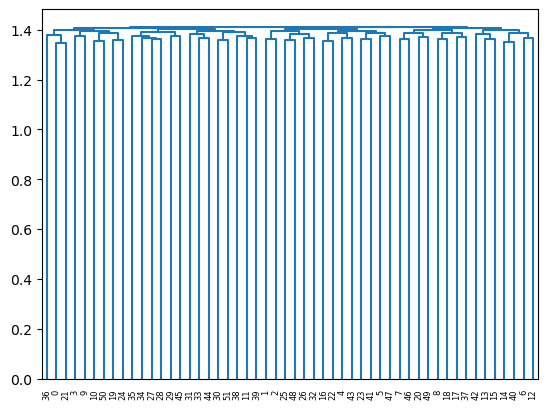

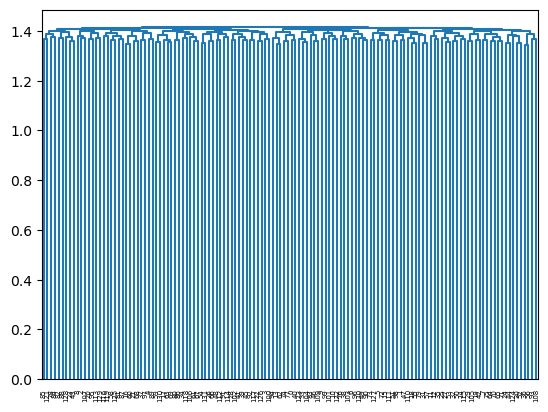

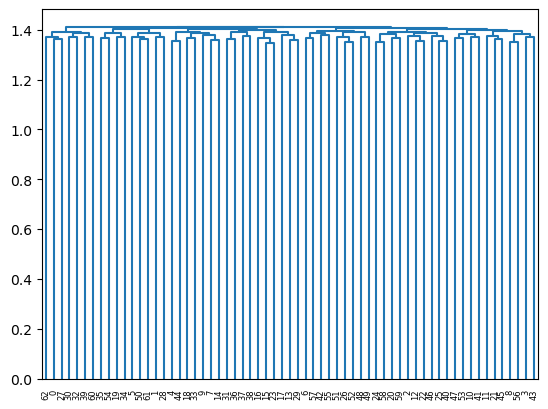

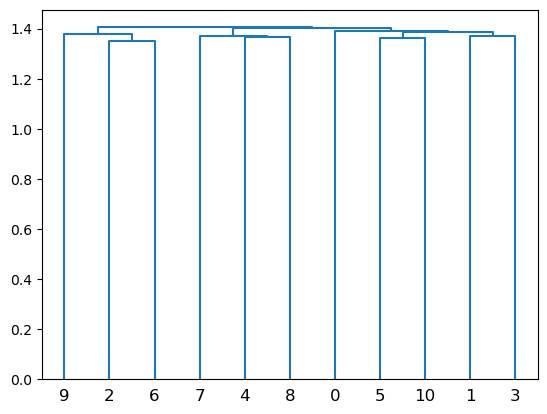

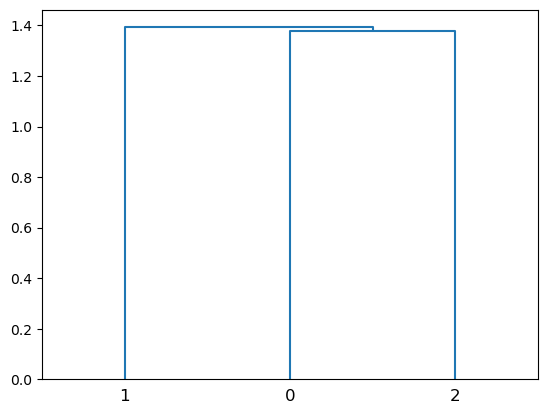

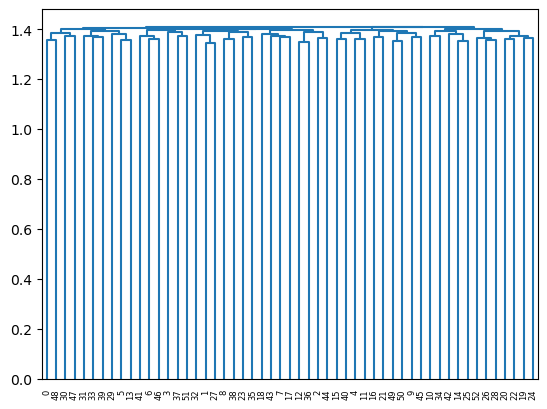

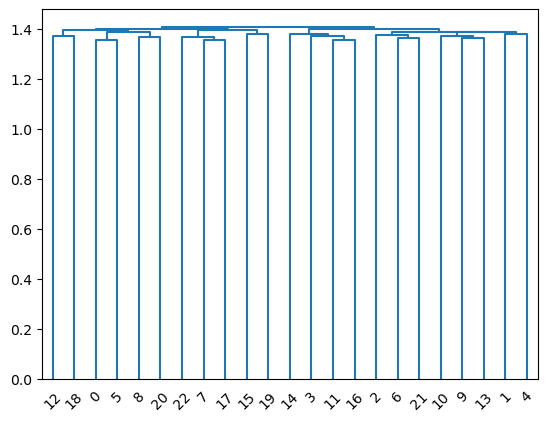

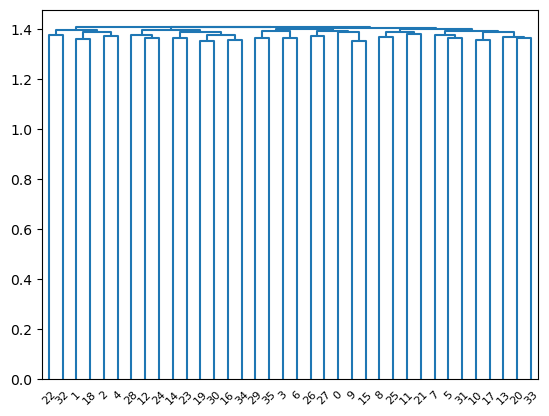

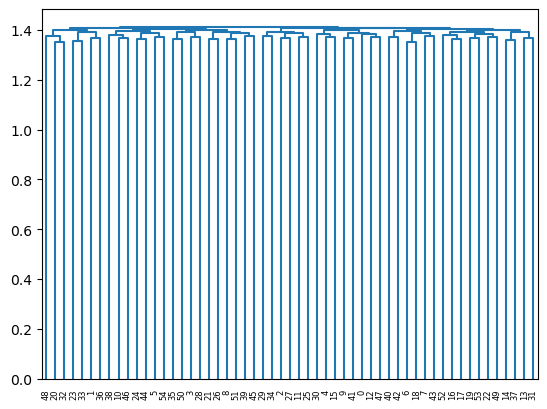

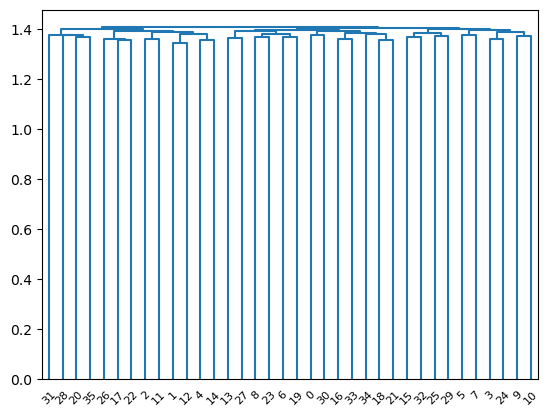

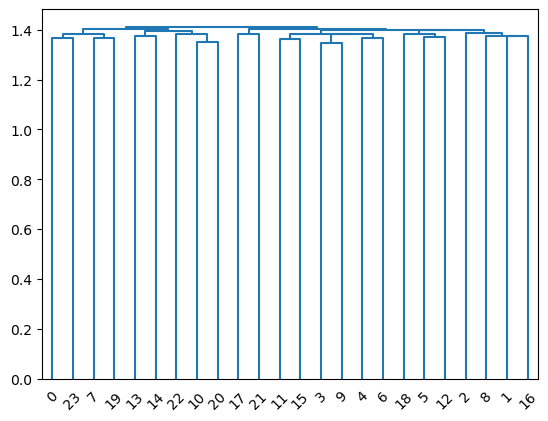

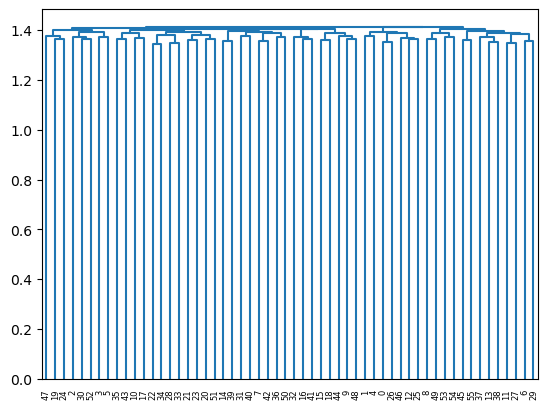

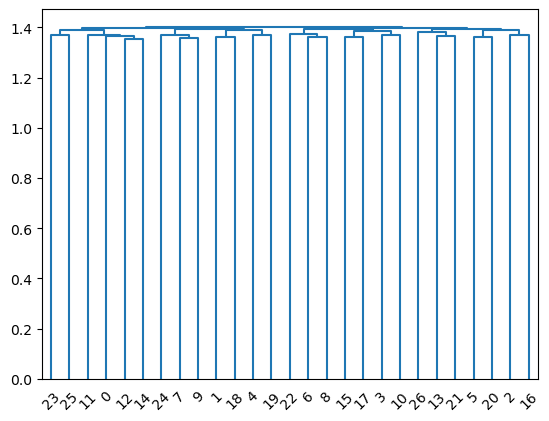

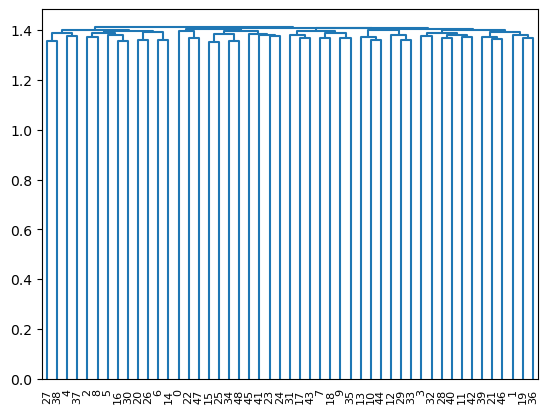

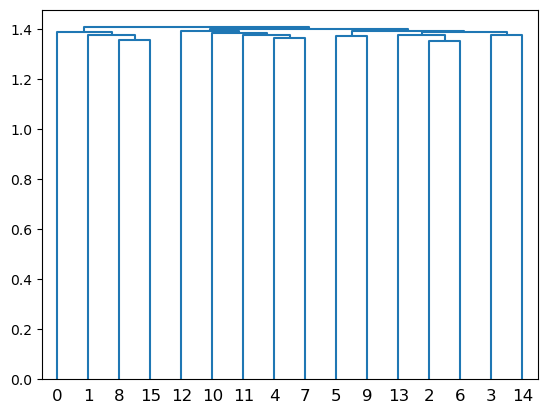

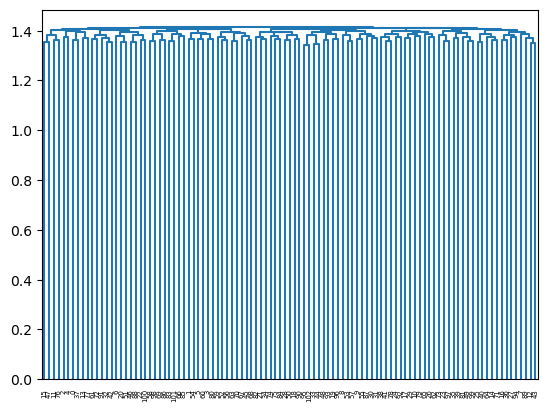

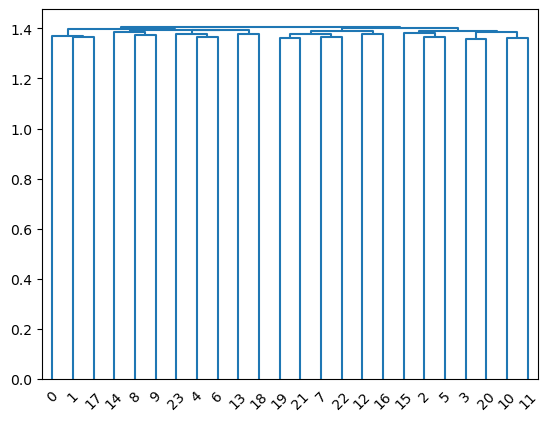

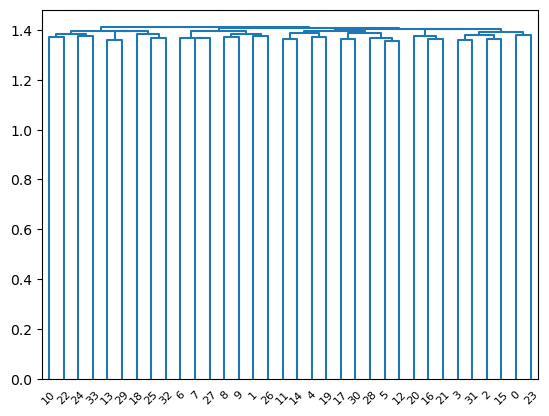

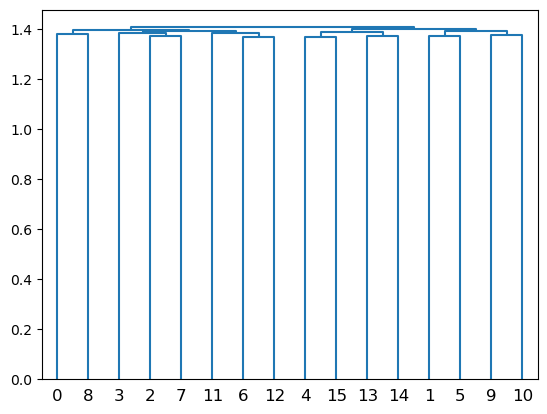

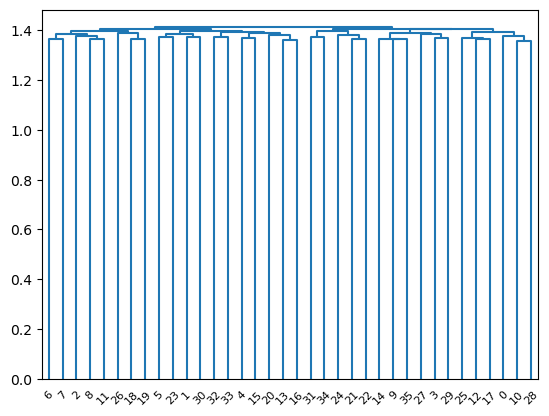

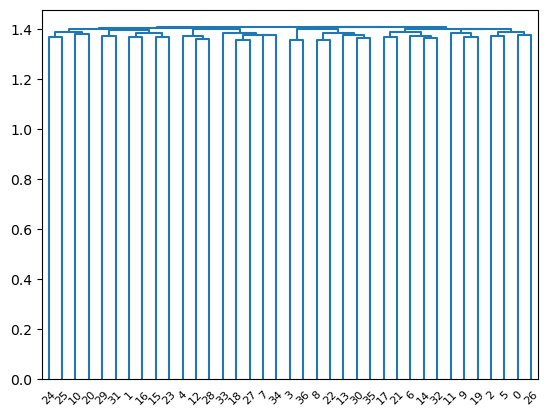

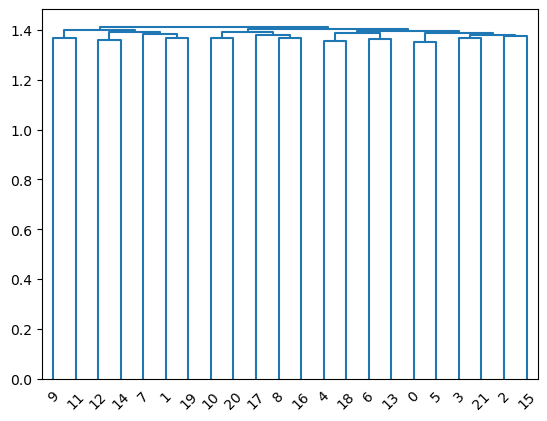

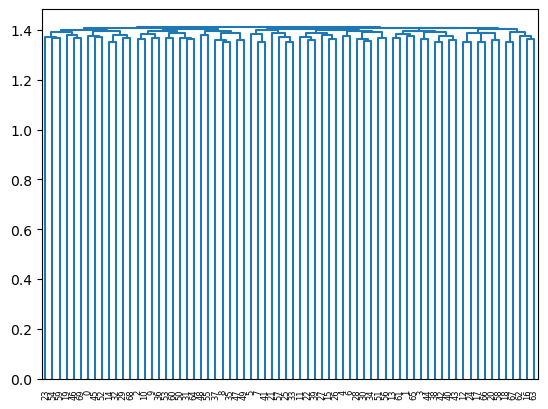

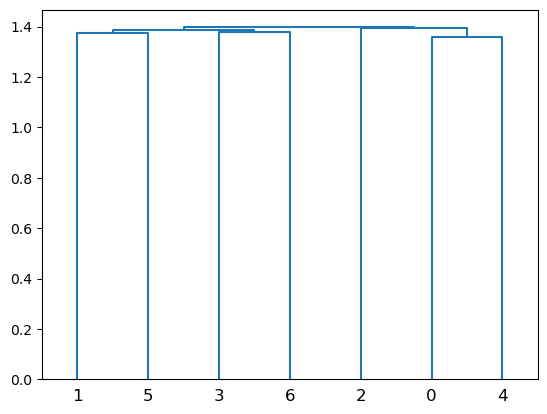

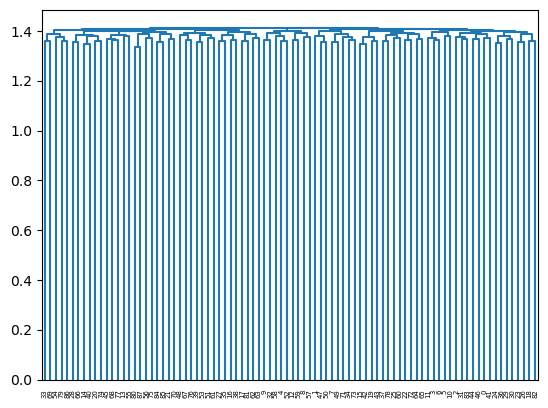

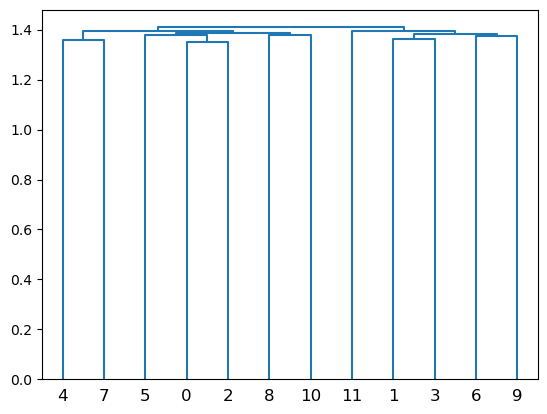

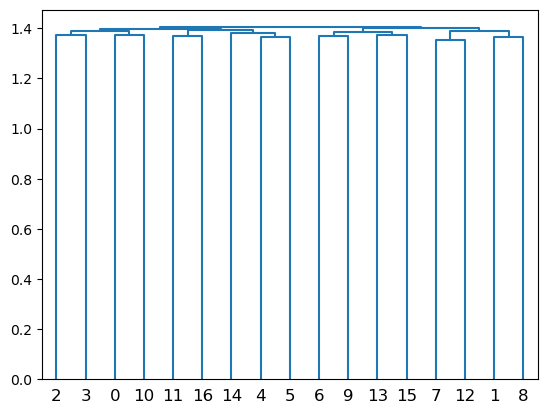

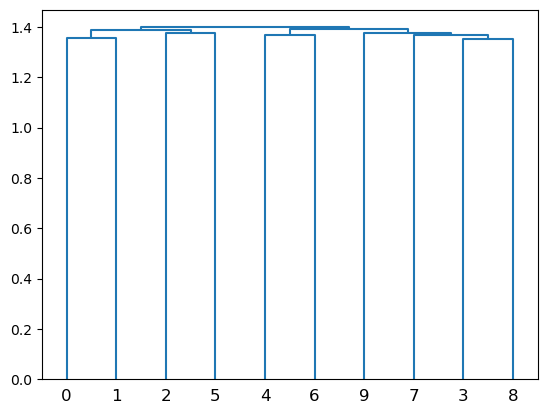

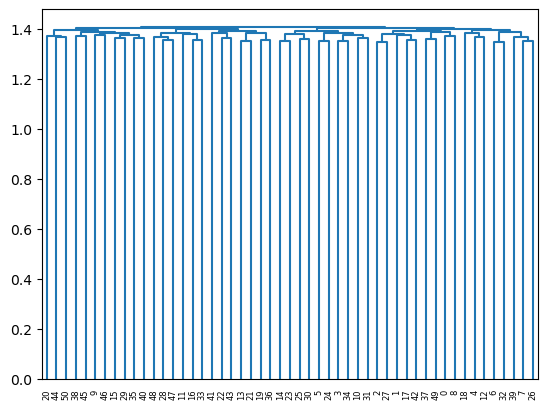

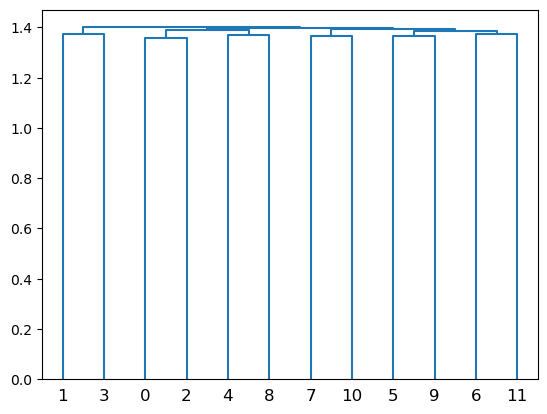

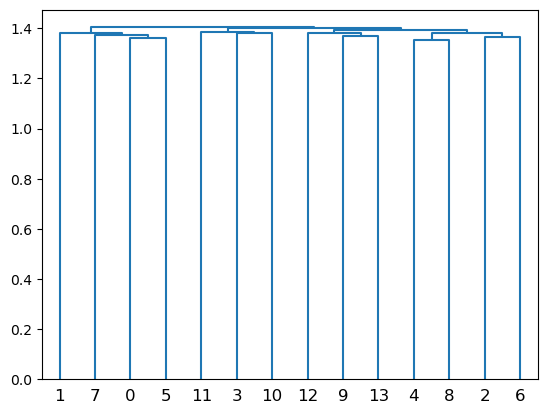

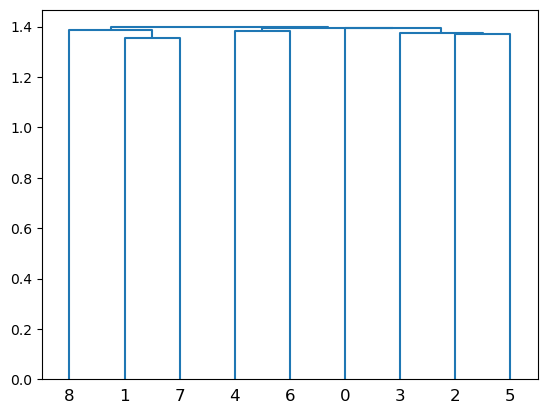

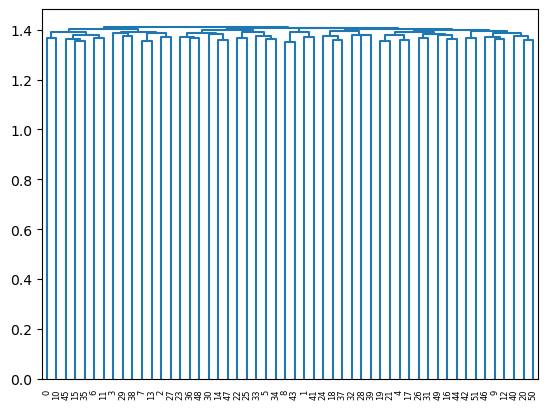

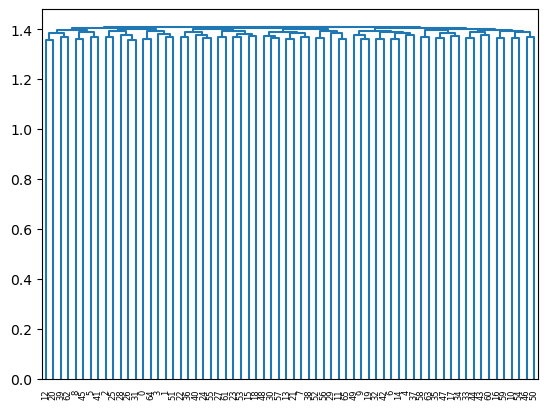

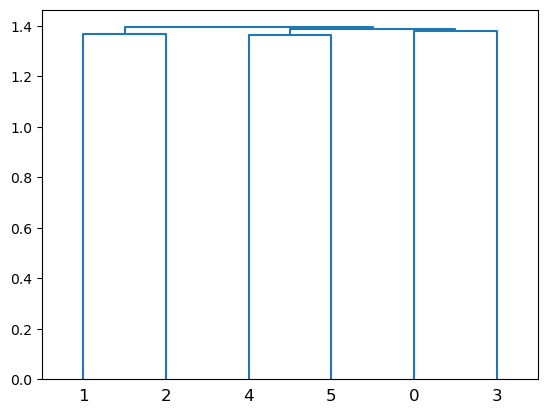

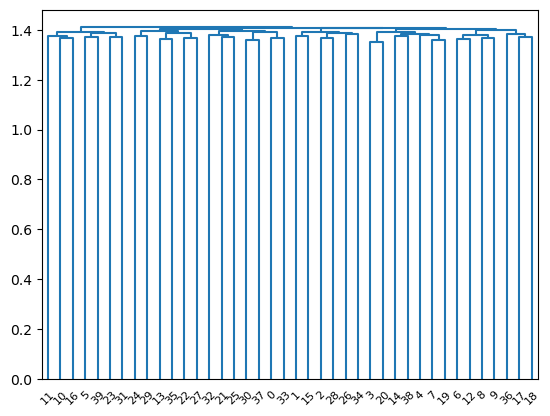

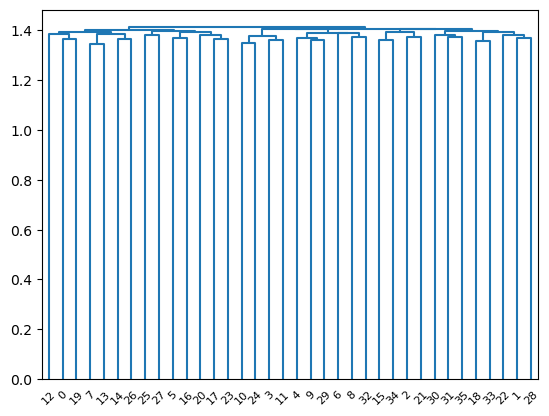

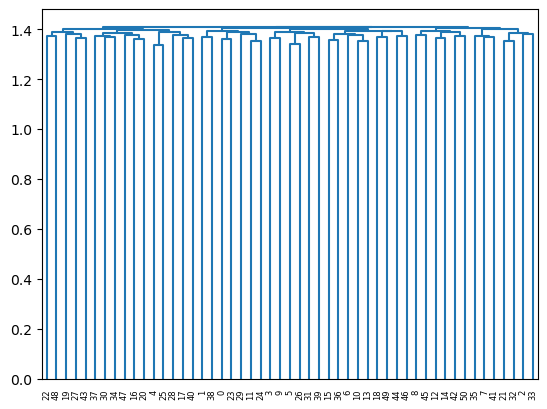

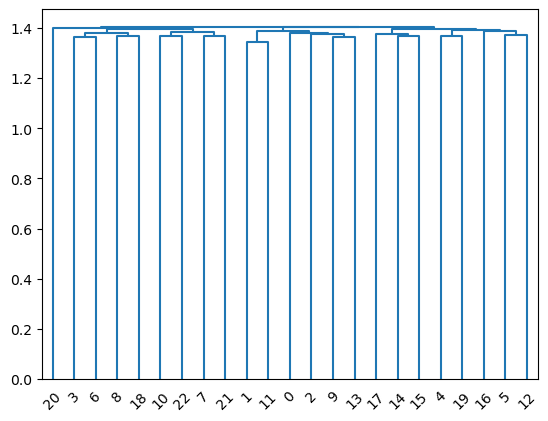

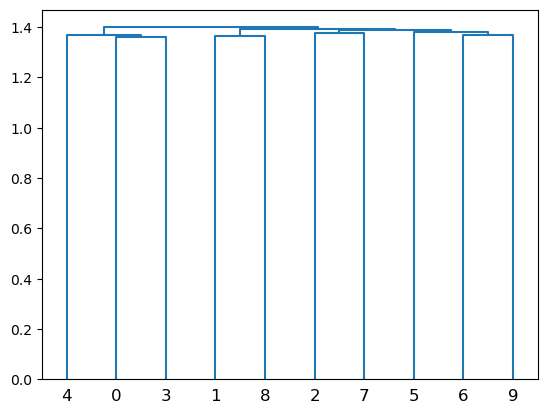

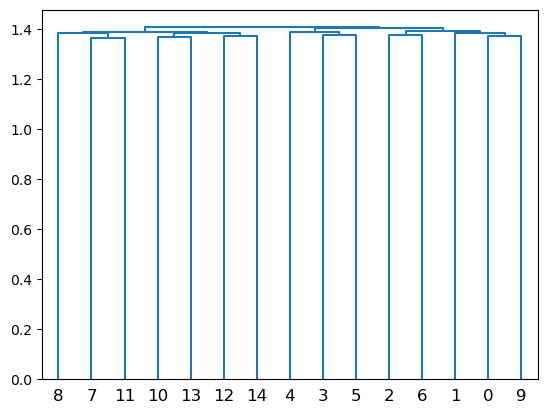

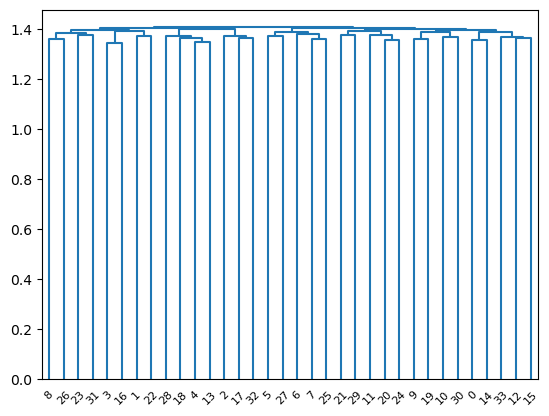

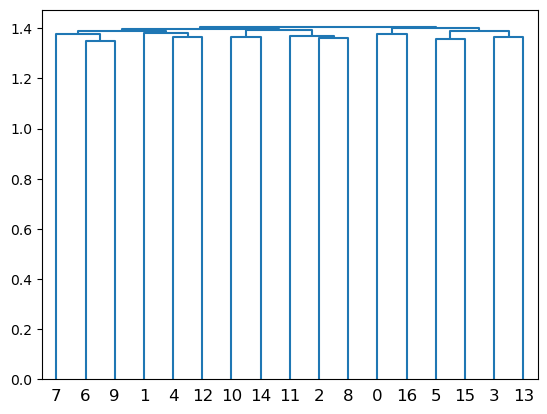

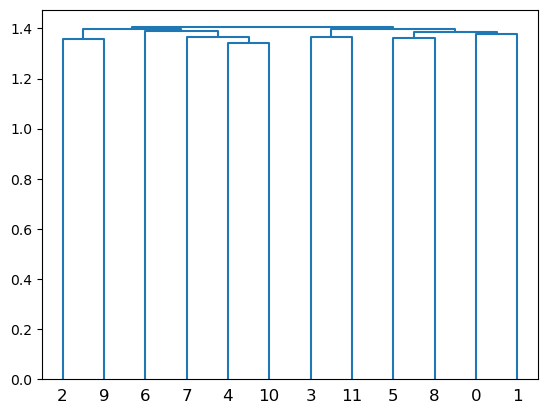

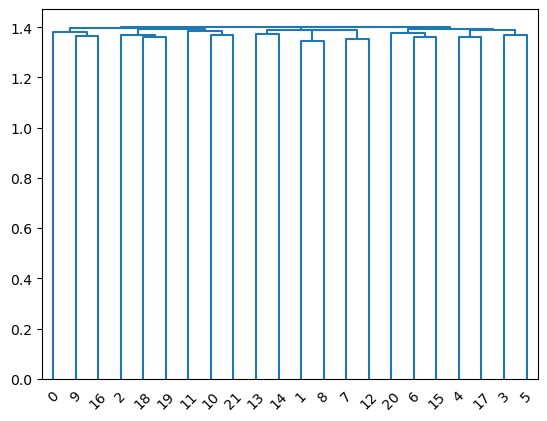

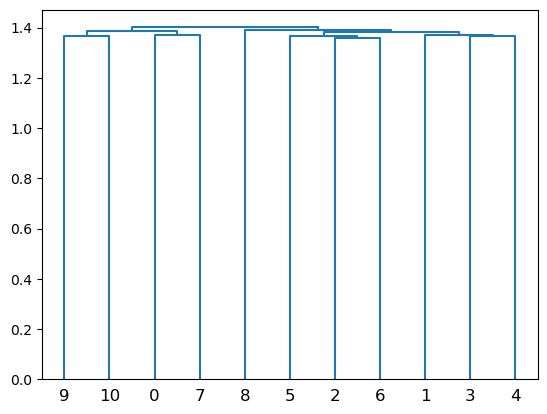

In [28]:
for i in range(650):
    if type(sim_mats[i]) is not int:
        plt.figure()
        HDP = linkage(sim_mats[i], method='complete')
        dn = dendrogram(HDP)